# Import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import seaborn as sns
from torchviz import make_dot, make_dot_from_trace
from skimage import io, transform
from torch import tensor
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output
import sys
sys.path.insert(0, '/home/caitao/Project/dl-localization')
from input_output import Default
from utility import Utility
from torch._six import container_abcs, string_classes, int_classes
import re
np_str_obj_array_pattern = re.compile(r'[SaUO]')
default_collate_err_msg_format = (
    "default_collate: batch must contain tensors, numpy arrays, numbers, "
    "dicts or lists; found {}")


# 1 Common modules

In [65]:
class MinMaxNormalize:
    '''Min max normalization, the new bound is (lower, upper)
    '''
    def __init__(self, lower=0, upper=1):
        assert isinstance(lower, (int, float))
        assert isinstance(upper, (int, float))
        self.lower = lower
        self.upper = upper

    def __call__(self, matrix):
        minn = matrix.min()
        maxx = matrix.max()
        matrix = (matrix - minn) / (maxx - minn)
        if self.lower != 0 or self.upper != 1:
            matrix = self.lower + matrix * (self.upper - self.lower)
        return matrix.astype(np.float32)


class UniformNormalize:
    '''Set a uniform threshold accross all samples
    '''
    def __init__(self, noise_floor):
        self.noise_floor = noise_floor

    def __call__(self, matrix):
        matrix -= self.noise_floor
        matrix /= (-self.noise_floor/2)
        return matrix.astype(np.float32)


class Metrics:
    '''Evaluation metrics
    '''
    @staticmethod
    def localization_error_image_continuous(pred_batch, pred_ntx, truth_batch, index, grid_len, peak_threshold, debug=False):
        '''Continuous -- for single TX
           euclidian error when modeling the output representation is a matrix (image)
           both pred and truth are batches, typically a batch of 32
           now both prediction and truth are continuous numbers
        Args:
            pred_batch:  numpy.ndarray -- size=(N, 1, 100, 100)
            truth_batch: numpy.ndarray -- size=(N, num_tx, 2)
        Return:
            pred_locs -- list<np.ndarray>
            errors    -- list<list>
            misses    -- list
            false     -- list
        '''
        def float_target(pred_matrix, pred_peaks):
            new_pred_peaks = []
            for pred_x, pred_y in pred_peaks:
                sum_weight = 0
                neighbor = []
                for d in [(0, 0), (-1, 0), (0, 1), (1, 0), (0, -1)]:
                    nxt = (pred_x + d[0], pred_y + d[1])
                    if 0 <= nxt[0] < grid_len and 0 <= nxt[1] < grid_len:
                        neighbor.append(((nxt[0] + 0.5, nxt[1] + 0.5), pred[nxt[0]][nxt[1]]))
                        sum_weight += pred_matrix[nxt[0]][nxt[1]]
                pred_x, pred_y = 0, 0
                for n in neighbor:
                    loc = n[0]
                    w   = n[1]
                    pred_x += loc[0] / sum_weight * w
                    pred_y += loc[1] / sum_weight * w
                new_pred_peaks.append((pred_x, pred_y))
            return new_pred_peaks

        pred_locs = []
        errors = []
        misses = []
        falses = []
        for i, pred, pred_n, truth, indx in zip(range(len(pred_batch)), pred_batch, pred_ntx, truth_batch, index):
            # 1: get the multiple predicted locations
            pred = pred[0]           # there is only one channel
            pred_peaks, _ = Utility.detect_peak(pred, np.round(pred_n, 0), peak_threshold)         # get the predictions  TIME: 23 milliseconds
            pred_peaks = float_target(pred, pred_peaks)
            pred_locs.append(pred_peaks)
            # 2: do a matching and get the error
            radius_threshold = Default.grid_length * Default.error_threshold
            error, miss, false = Utility.compute_error(pred_peaks, truth, radius_threshold, False)
            errors.append(error)
            misses.append(miss)
            falses.append(false)
            if debug:
                print(i, indx, 'pred', [(round(loc[0], 2), round(loc[1], 2)) for loc in pred_peaks], '; truth', \
                      [(round(loc[0], 2), round(loc[1], 2)) for loc in truth], ' ; error', error, ' ; miss', miss, ' ; false', false)
        return pred_locs, errors, misses, falses

    @staticmethod
    def localization_error_binary(pred_batch, truth_batch, index, grid_len, debug=False):
        '''Continuous -- for single TX
           euclidian error when modeling the output representation is a matrix (image)
           both pred and truth are batches, typically a batch of 32
           now both prediction and truth are NOT continuous numbers
        Args:
            pred_batch:  numpy.ndarray -- size=(N, 1, 100, 100)
            truth_batch: numpy.ndarray -- size=(N, num_tx, 2)
        Return:
            pred_locs -- list<np.ndarray>
            errors    -- list<list>
            misses    -- list
            false     -- list
        '''
        def mysigmoid(X):
            '''
            Args:
                X -- np.ndarray, in float32
            Return:
                np.ndarray
            '''
            X = np.where(X < -88, -88, X)    # the maximum value of float32 is 3x10^38 (around e^88)
            return 1 / (1 + np.exp(-X))

        def detect_peaks(pred):
            '''
            Args:
                pred -- np.ndarray, n=2
            Return:
                list<(int, int)> -- a list of peaks
            '''
            pred = mysigmoid(pred)
            pred = pred > 0.5
            peaks = np.where(pred == True)
            return [(x, y) for x, y in zip(peaks[0], peaks[1])]

        def float_target(pred_peaks):
            new_pred_peaks = []
            for pred_x, pred_y in pred_peaks:
                pred_x += 0.5
                pred_y += 0.5
                new_pred_peaks.append((pred_x, pred_y))
            return new_pred_peaks

        pred_locs = []
        errors = []
        misses = []
        falses = []
        for i, pred, truth, indx in zip(range(len(pred_batch)), pred_batch, truth_batch, index):
            # 1: get the multiple predicted locations
            pred = pred[0]           # there is only one channel
            pred_peaks = detect_peaks(pred)
            pred_peaks = float_target(pred_peaks)
            pred_locs.append(pred_peaks)
            # 2: do a matching and get the error
            radius_threshold = Default.grid_length * Default.error_threshold
            error, miss, false = Utility.compute_error(pred_peaks, truth, radius_threshold, False)
            errors.append(error)
            misses.append(miss)
            falses.append(false)
            if debug:
                print(i, indx, 'pred', [(round(loc[0], 2), round(loc[1], 2)) for loc in pred_peaks], '; truth', \
                      [(round(loc[0], 2), round(loc[1], 2)) for loc in truth], ' ; error', error, ' ; miss', miss, ' ; false', false)
        return pred_locs, errors, misses, falses

In [3]:
def my_padding(batch, max_len):
    """add zeros to elements that are not maximum length"""
    for i in range(len(batch)):
        diff = max_len - len(batch[i])
        if diff > 0:                      # padding
            zeros = torch.zeros(diff, 2)
            padded = torch.cat((batch[i], zeros), 0)
            batch[i] = padded

def my_collate(batch):
    """Puts each data field into a tensor with outer dimension batch size"""
    elem = batch[0]
    elem_type = type(elem)
    if isinstance(elem, torch.Tensor):
        max_len = len(max(batch, key=len))
        min_len = len(min(batch, key=len))
        if max_len != min_len:
            my_padding(batch, max_len)
        out = None
        if torch.utils.data.get_worker_info() is not None:
            # If we're in a background process, concatenate directly into a
            # shared memory tensor to avoid an extra copy
            numel = sum([x.numel() for x in batch])
            storage = elem.storage()._new_shared(numel)
            out = elem.new(storage)
        return torch.stack(batch, 0, out=out)
    elif elem_type.__module__ == 'numpy' and elem_type.__name__ != 'str_' \
            and elem_type.__name__ != 'string_':
        if elem_type.__name__ == 'ndarray' or elem_type.__name__ == 'memmap':
            # array of string classes and object
            if np_str_obj_array_pattern.search(elem.dtype.str) is not None:
                raise TypeError(default_collate_err_msg_format.format(elem.dtype))

            return my_collate([torch.as_tensor(b) for b in batch])
        elif elem.shape == ():  # scalars
            return torch.as_tensor(batch)
    elif isinstance(elem, float):
        return torch.tensor(batch, dtype=torch.float64)
    elif isinstance(elem, int_classes):
        return torch.tensor(batch)
    elif isinstance(elem, string_classes):
        return batch
    elif isinstance(elem, container_abcs.Mapping):
        return {key: my_collate([d[key] for d in batch]) for key in elem}
    elif isinstance(elem, tuple) and hasattr(elem, '_fields'):  # namedtuple
        return elem_type(*(my_collate(samples) for samples in zip(*batch)))
    elif isinstance(elem, container_abcs.Sequence):
        # check to make sure that the elements in batch have consistent size
        it = iter(batch)
        elem_size = len(next(it))
        if not all(len(elem) == elem_size for elem in it):
            raise RuntimeError('each element in list of batch should be of equal size')
        transposed = zip(*batch)
        return [my_collate(samples) for samples in transposed]

    raise TypeError(default_collate_err_msg_format.format(elem_type))

def my_uncollate(y_num, y_float):
    """this is for uncollating the target_float"""
    y_float_tmp = []
    for ntx, y_f in zip(y_num, y_float):
        y_float_tmp.append(y_f[:ntx])
    return np.array(y_float_tmp, dtype=object)

# 2 Dataset

In [86]:
class SensorInputDatasetTranslation(Dataset):
    '''Sensor reading input dataset -- for multi TX
       Output is image, model as a image segmentation problem
    '''
    def __init__(self, root_dir: str, transform=None):
        '''
        Args:
            root_dir:  directory with all the images
            labels:    labels of images
            transform: optional transform to be applied on a sample
        '''
        self.root_dir = root_dir
        self.transform = transform
        self.length = len(os.listdir(self.root_dir))
        self.sample_per_label = self.get_sample_per_label()

    def __len__(self):
        return self.length * self.sample_per_label

    def __getitem__(self, idx):
        folder = int(idx/self.sample_per_label)
        folder = format(folder, '06d')
        matrix_name = str(idx%self.sample_per_label) + '.npy'
        matrix_path = os.path.join(self.root_dir, folder, matrix_name)
        target_name = str(idx%self.sample_per_label) + '.target.npy'
        target_img2, target_img, target_float = self.get_translation_target(folder, target_name)
        matrix = np.load(matrix_path)
        if self.transform:
            matrix = self.transform(matrix)
        target_num = len(target_float)
        sample = {'matrix': matrix, 'target': target_img, 'target2': target_img2, 'target_float': target_float, 'target_num': target_num, 'index': idx}
        return sample

    def get_sample_per_label(self):
        folder = glob.glob(os.path.join(self.root_dir, '*'))[0]
        samples = glob.glob(os.path.join(folder, '*.npy'))
        targets = glob.glob(os.path.join(folder, '*.target.npy'))
        return len(samples) - len(targets)

    def get_translation_target(self, folder: str, target_name: str):
        '''
        Args:
            folder      -- eg. 000001
            target_name -- eg. 0.target.npy
        Return:
            np.ndarray, n = 2, the pixels surrounding TX will be assigned some values
        '''
        location = np.load(os.path.join(self.root_dir, folder, target_name))
        num_tx = len(location)
        grid  = np.zeros((Default.grid_length, Default.grid_length))
        grid2 = np.zeros((Default.grid_length, Default.grid_length))
        for i in range(num_tx):
            x, y = location[i][0], location[i][1]
            target_float = (x, y)
            x, y = int(x), int(y)
            grid2[x][y] = 1
            neighbor = []
            sum_weight = 0
            for i in [-1, 0, 1]:
                for j in [-1, 0, 1]:
                    nxt = (x + i, y + j)
                    if 0 <= nxt[0] < Default.grid_length and 0 <= nxt[1] < Default.grid_length:
                        weight = 1./Utility.distance((nxt[0] + 0.5, nxt[1] + 0.5), target_float)
                        sum_weight += weight
                        neighbor.append((nxt, weight))
            for n, w in neighbor:
                grid[n[0]][n[1]] += w / sum_weight * len(neighbor) * 3  # 2 is for adding weights
        grid = np.expand_dims(grid, 0)
        grid2 = np.expand_dims(grid2, 0)
        return grid2.astype(np.float32), grid.astype(np.float32), location.astype(np.float32)


tf = T.Compose([
     UniformNormalize(Default.noise_floor),                 # TUNE: Uniform normalization is better than the above minmax normalization
     T.ToTensor()])

# training
i = 0
root_dir = './data/60train'
sensor_input_dataset = SensorInputDatasetTranslation(root_dir=root_dir, transform=tf)
sensor_input_dataloader = DataLoader(sensor_input_dataset, batch_size=32, shuffle=True, num_workers=3, collate_fn=my_collate)
print('matrix shape:', sensor_input_dataset[i]['matrix'].shape)
print('matrix shape:', sensor_input_dataset[i]['matrix'])
print('target:', sensor_input_dataset[i]['target'])
print('target float:', sensor_input_dataset[i]['target_float'])
print('length:', sensor_input_dataset.__len__())

print('---\n')
# testing
root_dir = './data/61test'
sensor_input_test_dataset = SensorInputDatasetTranslation(root_dir=root_dir, transform=tf)
sensor_input_test_dataloader = DataLoader(sensor_input_test_dataset, batch_size=32, shuffle=True, num_workers=3, collate_fn=my_collate)
print('matrix type:', sensor_input_test_dataset[i]['matrix'].dtype)
print('target type:', sensor_input_test_dataset[i]['target'].dtype)
print('target float:', sensor_input_test_dataset[i]['target_float'])
print('target num:', sensor_input_test_dataset[i]['target_num'])
print(sensor_input_test_dataset.__len__())

matrix shape: torch.Size([1, 100, 100])
matrix shape: tensor([[[0.0000, 0.9048, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])
target: [[[0.        0.        0.        ... 0.        0.        0.       ]
  [0.        2.0347643 2.1041484 ... 0.        0.        0.       ]
  [0.        4.430288  5.3237586 ... 0.        0.        0.       ]
  ...
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]]]
target float: [[ 2.8753572  2.0719564]
 [83.21589   75.6414   ]]
length: 92160
---

matrix type: torch.float32
targe

# 3 Model

In [8]:
class NetTranslation4(nn.Module):
    '''Image translation.
       the first CNN is the same as NetTranslation, 
       the second one uses the output of the first CNN and output the # of Tx
       Assuming the input image is 1 x 100 x 100
    '''

    def __init__(self):
        super(NetTranslation4, self).__init__()
        self.conv11 = nn.Conv2d(1, 8,  7, padding=3)   # TUNE: a larger filter decrease miss, decrease localization error
        self.conv12 = nn.Conv2d(8, 32, 7, padding=3)
        self.conv13 = nn.Conv2d(32, 1, 7, padding=3)

    def forward(self, x):
        # first CNN input is 1 x 100 x 100
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        y = self.conv13(x)
        return y

net = NetTranslation4()
print(net)

NetTranslation4(
  (conv11): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv12): Conv2d(8, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv13): Conv2d(32, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
)


In [9]:
"""
In the two CNN in a sequence method. the second CNN that predicts # of TX will affect the output of the first CNN
--> two CNN in a sequence may be a bad idea
--> how about two CNN in parallel
"""


class NetNumTx(nn.Module):
    """this CNN predicts # of TX """

    def __init__(self, max_ntx):
        super(NetNumTx, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, 5)
        self.conv2 = nn.Conv2d(2, 4, 5)
        self.conv3 = nn.Conv2d(4, 8, 5)
        self.groupnorm1 = nn.GroupNorm(1, 2)
        self.groupnorm2 = nn.GroupNorm(2, 4)
        self.groupnorm3 = nn.GroupNorm(4, 8)
        self.fc1 = nn.Linear(648, 32)
        self.fc2 = nn.Linear(32, max_ntx)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.groupnorm1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.groupnorm2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.groupnorm3(self.conv3(x))), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        y = self.fc2(x)
        return y

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

numtx = NetNumTx(max_ntx=2)
print(numtx)

NetNumTx(
  (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
  (groupnorm1): GroupNorm(1, 2, eps=1e-05, affine=True)
  (groupnorm2): GroupNorm(2, 4, eps=1e-05, affine=True)
  (groupnorm3): GroupNorm(4, 8, eps=1e-05, affine=True)
  (fc1): Linear(in_features=648, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)


## Utility

In [7]:
def make_zeros(batch=32, length=100):
    '''for the regulation in the loss function
    '''
    zeros = []
    for _ in range(batch):
        zero = np.zeros((length, length))
        zero = np.expand_dims(zero, 0)
        zeros.append(zero)
    return torch.as_tensor(zeros).to(torch.device('cuda'))


def plot_epoch_stats(train_losses1, train_losses2, train_errors1, train_errors2, test_losses1, test_losses2, test_errors1, test_errors2, test_misses1, test_falses1, test_num_tx):
    '''print the error and such of each epoch
    '''
    clear_output(True)
    plt.figure(figsize=(24, 18))
    plt.subplot(5, 2, 1)
    plt.title('train loss for image translation')
    plt.plot(train_losses1)
    plt.subplot(5, 2, 2)
    plt.title('train errors for image translation')
    train_errors1 = [val for sublist in train_errors1 for val in sublist]  # flatten a 2D matrix
    plt.plot(train_errors1)
    plt.subplot(5, 2, 3)
    plt.title('train loss for num of TX')
    plt.plot(train_losses2)
    plt.subplot(5, 2, 4)
    plt.title('train error for num of TX')
    plt.plot(train_errors2)
    plt.subplot(5, 2, 5)
    plt.title('test loss for image translation')
    plt.plot(test_losses1)
    plt.subplot(5, 2, 6)
    plt.title('test error for image translation')
    test_errors1 = [val for sublist in test_errors1 for val in sublist]
    plt.plot(test_errors1)
    plt.subplot(5, 2, 7)
    plt.title('test loss for num of TX')
    plt.plot(test_losses2)
    plt.subplot(5, 2, 8)
    plt.title('test error for num of TX')
    plt.plot(test_errors2)
    plt.subplot(5, 2, 9)
    plt.title('test miss for image translation')
    plt.plot(np.array(test_misses1)/np.array(test_num_tx))   # implicitly assuming each sample is "equal". Instead it is not. when averaging, samples with higher number of TX should weight more
    plt.subplot(5, 2, 10)
    plt.title('test false alarm for image translation')
    plt.plot(np.array(test_falses1)/np.array(test_num_tx))
    plt.show()
    print('train loss of image translation  =', np.mean(train_losses1))
    print('train loss of num of TX          =', np.mean(train_losses2))
    print('test  loss of image translation  =', np.mean(test_losses1))
    print('test  loss of num of TX          =', np.mean(test_losses2))
    print('train error of image translation =', np.mean(train_errors1))
    print('train error of num of TX         =', np.mean(train_errors2))
    print('test error of image translation  =', np.mean(test_errors1))
    print('test error of num of TX          =', np.mean(test_errors2))
    print('test falses of image translation =', np.sum(test_falses1)/np.sum(test_num_tx))
    print('test misses of image translation =', np.sum(test_misses1)/np.sum(test_num_tx))
    train_losses1_epoch.append((np.mean(train_losses1), np.std(train_losses1)))
    train_losses2_epoch.append((np.mean(train_losses2), np.std(train_losses2)))
    train_errors1_epoch.append((np.mean(train_errors1), np.std(train_errors1)))
    train_errors2_epoch.append((np.mean(train_errors2), np.std(train_errors2)))
    test_losses1_epoch.append((np.mean(test_losses1), np.std(test_losses1)))
    test_losses2_epoch.append((np.mean(test_losses2), np.std(test_losses2)))
    test_errors1_epoch.append((np.mean(test_errors1), np.std(test_errors1)))
    test_errors2_epoch.append((np.mean(test_errors2), np.std(test_errors2)))
    test_misses1_epoch.append((np.sum(test_misses1)/np.sum(test_num_tx)))
    test_falses1_epoch.append((np.mean(test_falses1)/np.sum(test_num_tx)))


def plot_epoch_stats_num_tx(train_losses2, train_errors2, test_losses2, test_errors2, test_num_tx):
    '''print the error and such of each epoch
    '''
    clear_output(True)
    plt.figure(figsize=(24, 10))
    plt.subplot(2, 2, 1)
    plt.title('train loss for num of TX')
    plt.plot(train_losses2)
    plt.subplot(2, 2, 2)
    plt.title('train error for num of TX')
    plt.plot(train_errors2)
    plt.subplot(2, 2, 3)
    plt.title('test loss for num of TX')
    plt.plot(test_losses2)
    plt.subplot(2, 2, 4)
    plt.title('test error for num of TX')
    plt.plot(test_errors2)
    plt.show()
    print('train loss of num of TX          =', np.mean(train_losses2))
    print('test  loss of num of TX          =', np.mean(test_losses2))
    print('train error of num of TX         =', np.mean(train_errors2))
    print('test error of num of TX          =', np.mean(test_errors2))
    train_losses2_epoch.append((np.mean(train_losses2), np.std(train_losses2)))
    train_errors2_epoch.append((np.mean(train_errors2), np.std(train_errors2)))
    test_losses2_epoch.append((np.mean(test_losses2), np.std(test_losses2)))
    test_errors2_epoch.append((np.mean(test_errors2), np.std(test_errors2)))


def plot_epochs(train_losses2, test_losses2, train_errors2, test_errors2):
    print('train loss of num of TX   =', np.mean(train_losses2))
    print('test  loss of num of TX   =', np.mean(test_losses2))
    print('train error of num of TX  =', np.mean(train_errors2))
    print('test error of num of TX   =', np.mean(test_errors2))
    train_losses2_epoch.append((np.mean(train_losses2)))
    train_errors2_epoch.append((np.mean(train_errors2)))
    test_losses2_epoch.append((np.mean(test_losses2)))
    test_errors2_epoch.append((np.mean(test_errors2)))
    clear_output(True)
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title('Loss', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.plot(train_losses2_epoch, label='Train', linewidth=5)
    plt.plot(test_losses2_epoch, label='Test', linewidth=5)
    plt.legend(fontsize=30)
    plt.subplot(1, 2, 2)
    plt.title('Error (1-accuracy)', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.plot(train_errors2_epoch, label='Train', linewidth=5)
    plt.plot(test_errors2_epoch, label='Test', linewidth=5)
    plt.legend(fontsize=30)
    plt.tight_layout()
    plt.show()

# Training

## Try A better CNN Predicting the Number of TX

In [73]:
class NetNumTx2(nn.Module):
    """this CNN predicts # of TX """

    def __init__(self, max_ntx):
        super(NetNumTx2, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, 5, padding=2)
        self.conv2 = nn.Conv2d(2, 4, 5, padding=2)
        self.conv3 = nn.Conv2d(4, 8, 5, padding=2)
        self.conv4 = nn.Conv2d(8, 16, 5, padding=2)
        self.norm1 = nn.GroupNorm(1, 2)
        self.norm2 = nn.GroupNorm(2, 4)
        self.norm3 = nn.GroupNorm(4, 8)
        self.norm4 = nn.GroupNorm(8, 16)
        self.fc1 = nn.Linear(576, 50)
        self.fc2 = nn.Linear(50, max_ntx)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.norm1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.norm2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.norm3(self.conv3(x))), 2)
        x = F.max_pool2d(F.relu(self.norm4(self.conv4(x))), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        y = self.fc2(x)
        return y

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


numtx = NetNumTx2(max_ntx=5)
print(numtx)

NetNumTx2(
  (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(2, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (norm1): GroupNorm(1, 2, eps=1e-05, affine=True)
  (norm2): GroupNorm(2, 4, eps=1e-05, affine=True)
  (norm3): GroupNorm(4, 8, eps=1e-05, affine=True)
  (norm4): GroupNorm(8, 16, eps=1e-05, affine=True)
  (fc1): Linear(in_features=576, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=5, bias=True)
)


In [118]:
class NetNumTx3(nn.Module):
    """this CNN predicts # of TX """

    def __init__(self, max_ntx):
        super(NetNumTx3, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, 3, padding=1)
        self.conv2 = nn.Conv2d(2, 4, 3, padding=1)
        self.conv3 = nn.Conv2d(4, 8, 3, padding=1)
        self.conv4 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv5 = nn.Conv2d(16, 16, 3, padding=1)
        self.norm1 = nn.GroupNorm(1, 2)
        self.norm2 = nn.GroupNorm(2, 4)
        self.norm3 = nn.GroupNorm(4, 8)
        self.norm4 = nn.GroupNorm(8, 16)
        self.norm5 = nn.GroupNorm(8, 16)
        self.fc1 = nn.Linear(144, 8)
        self.fc2 = nn.Linear(8, max_ntx)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.norm1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.norm2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.norm3(self.conv3(x))), 2)
        x = F.max_pool2d(F.relu(self.norm4(self.conv4(x))), 2)
        x = F.max_pool2d(F.relu(self.norm5(self.conv5(x))), 2)
        x = x.view(-1, self.num_flat_features(x))
#         print('before x ', x.shape)
        x = F.relu(self.fc1(x))
#         print('after x ', x.shape)
        y = self.fc2(x)
        return y

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features



model = NetNumTx3(5)
X = X.data.cpu()
a = model(X)

train loss of num of TX   = 0.022432490546311277
test  loss of num of TX   = 0.09231471028053623
train error of num of TX  = 0.007063802083333333
test error of num of TX   = 0.026421440972222224


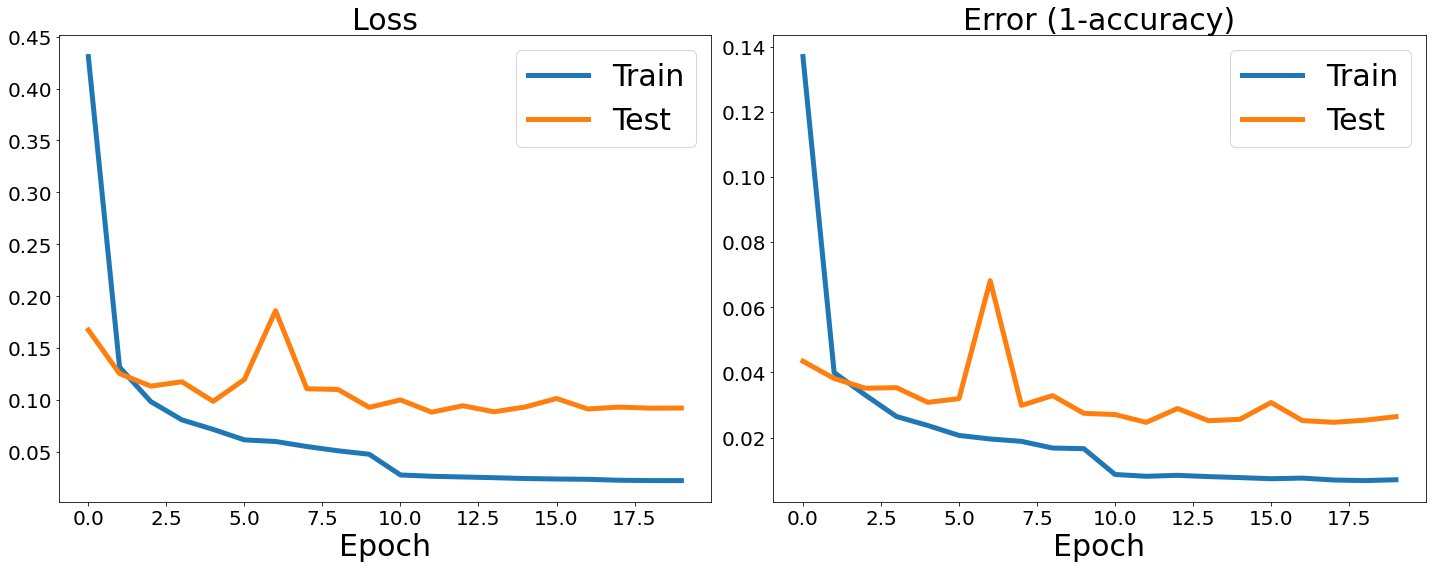

In [119]:
# try a better CNN on predicting the Number of TX

path1 = 'model/model1-11.12.pt'
path2 = 'model/model2-11.19-2.pt'
model2_minloss = 1000

device = torch.device('cuda')
model1   = NetTranslation4()
model1.load_state_dict(torch.load(path1))
model1   = model1.to(device)
model1.eval()

max_ntx    = 5
model2     = NetNumTx3(max_ntx)
model2     = model2.to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
cross_entro_loss = nn.CrossEntropyLoss()
scheduler  = optim.lr_scheduler.StepLR(optimizer2, step_size=10, gamma=0.1)

num_epochs = 20
train_losses2_epoch = []
train_errors2_epoch = []
test_losses2_epoch  = []
test_errors2_epoch  = []
test_num_tx = []
print_every, error_every = 100, 1

for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    train_losses2, train_errors2 = [], []
    test_losses2, test_errors2   = [], []
    test_num_tx = []
    model2.train()
    for t, sample in enumerate(sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        y_num   = sample['target_num'].to(device)
        y_num2  = np.array(sample['target_num'])
        y_float = np.array(sample['target_float'])
        y_float = my_uncollate(y_num2, y_float)
        indx = sample['index']

        pred_matrix = model1(X)
        pred_ntx = model2(pred_matrix)              # the model for num TX

        loss2 = cross_entro_loss(pred_ntx, y_num-1)  # 1 TX is class 0, 2 TX is class 1
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()

        train_losses2.append(loss2.item())
        _, pred_ntx = pred_ntx.data.cpu().max(1)
        pred_ntx = (pred_ntx + 1).numpy()    # class 0 means 1 TX, class 1 means 2 TX etc...
        if t % error_every == 0:
            ntx_correct = (pred_ntx == y_num2).sum()
            total = len(pred_ntx)
            train_errors2.append(1 - ntx_correct / total)
        if t % print_every == 0:
            print(f't = {t}, loss_num_tx = {loss2.item()},')

    model2.eval()
    for t, sample in enumerate(sensor_input_test_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        y_num   = sample['target_num'].to(device)
        y_num2  = np.array(sample['target_num'])
        y_float = np.array(sample['target_float'])
        y_float = my_uncollate(y_num2, y_float)
        indx = sample['index']

        pred_matrix = model1(X)
        pred_ntx    = model2(pred_matrix)              # the model for num TX
        loss2 = cross_entro_loss(pred_ntx, y_num-1)  # 1 TX is class 0, 2 TX is class 1

        test_losses2.append(loss2.item())
        _, pred_ntx = pred_ntx.data.cpu().max(1)
        pred_ntx = (pred_ntx + 1).numpy()    # class 0 means 1 TX, class 1 means 2 TX etc...
        if t % error_every == 0:
            test_num_tx.extend(list(y_num2))
            ntx_correct = (pred_ntx == y_num2).sum()
            total = len(pred_ntx)
            test_errors2.append(1 - ntx_correct * 1.0 / total)

    if np.mean(test_losses2) < model2_minloss:
        torch.save(model2.state_dict(), path2)
        model2_minloss = np.mean(test_losses2)

    scheduler.step()

    clear_output(True)
    print('train loss of num of TX   =', np.mean(train_losses2))
    print('test  loss of num of TX   =', np.mean(test_losses2))
    print('train error of num of TX  =', np.mean(train_errors2))
    print('test error of num of TX   =', np.mean(test_errors2))
    train_losses2_epoch.append((np.mean(train_losses2)))
    train_errors2_epoch.append((np.mean(train_errors2)))
    test_losses2_epoch.append((np.mean(test_losses2)))
    test_errors2_epoch.append((np.mean(test_errors2)))
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title('Loss', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.plot(train_losses2_epoch, label='Train', linewidth=5)
    plt.plot(test_losses2_epoch, label='Test', linewidth=5)
    plt.legend(fontsize=30)
    plt.subplot(1, 2, 2)
    plt.title('Error (1-accuracy)', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.plot(train_errors2_epoch, label='Train', linewidth=5)
    plt.plot(test_errors2_epoch, label='Test', linewidth=5)
    plt.legend(fontsize=30)
    plt.tight_layout()
    plt.show()

In [120]:
print('Train loss')
for e in train_losses2_epoch:
    print(e)
print('\nTrain error')
for e in train_errors2_epoch:
    print(e)
print('\nTest loss')
for e in test_losses2_epoch:
    print(e)
print('\nTest error')
for e in test_errors2_epoch:
    print(e)

Train loss
0.4307974862982519
0.13170141191480475
0.09855277015772622
0.0808814155117337
0.07174706343778073
0.06166198248421198
0.060096012436285186
0.055232823114137214
0.05114493025636572
0.047795500054821284
0.027853983044931536
0.026605771654835228
0.02592534447071052
0.02522487380782776
0.024423880425880878
0.0239771533964813
0.02367223659180632
0.022769022901168987
0.022454973175950323
0.022432490546311277

Train error
0.13692491319444444
0.039952256944444445
0.033040364583333336
0.026453993055555555
0.023719618055555555
0.02065972222222222
0.019574652777777778
0.01884765625
0.016796875
0.0166015625
0.008680555555555556
0.00812717013888889
0.008420138888888888
0.008029513888888888
0.007725694444444445
0.007378472222222222
0.007573784722222222
0.0069878472222222225
0.006803385416666667
0.007063802083333333

Test loss
0.16744406012973437
0.125493086821128
0.1134325788928739
0.1176107820728147
0.09876023583233796
0.11984750159778439
0.1860501493146229
0.11090377282885634
0.11017852

In [163]:
# test all samples

# evaluation for all test samples

# path2 = 'model/model2-11.12-2.pt'
# path2 = 'model/model2-11.16.pt'
path2 = 'model/model2-11.16-2.pt'

device = torch.device('cuda')
max_ntx = 5
model2 = NetNumTx2(max_ntx)
model2.load_state_dict(torch.load(path2))
model2.to(device)
model2 = model2.to(device)

model2.eval()

test_index, test_losses2 = [], []
ntx_correct, ntx_total = 0, 0
tx_num_total = 0
test_index_ntx_wrong = []

for t, sample in enumerate(sensor_input_test_dataloader):
    if t % 10 == 9:
        print(t, end=' ')
    X = sample['matrix'].to(device)
    y = sample['target'].to(device)
    y_num   = sample['target_num'].to(device)
    y_num2  = np.array(sample['target_num'])
    y_float = np.array(sample['target_float'])
    y_float = my_uncollate(y_num2, y_float)
    indx = sample['index']

    pred_ntx    = model2(X)              # the model for num TX

    loss2 = cross_entro_loss(pred_ntx, y_num-1)  # 1 TX is class 0, 2 TX is class 1
    test_losses2.append(loss2.item())
    _, pred_ntx = pred_ntx.data.cpu().max(1)
    pred_ntx = (pred_ntx + 1).numpy()    # class 0 means 1 TX, class 1 means 2 TX etc...
    test_index.extend(indx.numpy())
    ntx_correct += (pred_ntx == y_num2).sum()
    ntx_total += len(pred_ntx)
    tx_num_total += y_num2.sum()
    for idx, boolean in zip(indx, pred_ntx == y_num2):
        if boolean == False:
            test_index_ntx_wrong.append(idx)

print()
print('Loss is {}'.format(np.mean(test_losses2)))
print('Num of TX prediction accuracy = {}'.format(ntx_correct * 1.0 / ntx_total))

9 19 29 39 49 59 69 79 89 99 109 119 129 139 149 159 169 179 189 199 209 219 229 239 249 259 269 279 289 299 309 319 329 339 349 359 369 379 389 399 409 419 429 439 449 459 469 479 489 499 509 519 529 539 549 559 569 
Loss is 0.24838642815524914
Num of TX prediction accuracy = 0.9320746527777778


NetNumTx1 -- model2-11.12-2.pt

Loss is 0.7180426505567497
Num of TX prediction accuracy = 0.7639431423611112

NetNumTx2 -- model2-11.16.pt

Loss is 0.3378385482051861
Num of TX prediction accuracy = 0.9206271701388888

## Assume CNN1 is trained, and do another CNN1, which uses BCEWithLogitsLoss

In [67]:
def show_epochs():
    print('train loss =', np.mean(train_losses2))
    print('test  loss =', np.mean(test_losses2))
    train_losses2_epoch.append((np.mean(train_losses2)))
    test_losses2_epoch.append((np.mean(test_losses2)))
    test_errors2_epoch.append((np.mean(test_errors2)))
    test_misses2_epoch.append((np.sum(test_misses2) / np.sum(test_num_tx)))
    test_falses2_epoch.append((np.sum(test_falses2) / np.sum(test_pred_num)))
    clear_output(True)

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 3, 1)
    plt.title('Loss', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.plot(train_losses2_epoch, label='Train', linewidth=5)
    plt.plot(test_losses2_epoch,  label='Test', linewidth=5)
    plt.legend(fontsize=20)

    plt.subplot(1, 3, 2)
    plt.title('Localization Error', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.plot(test_errors2_epoch, label='Test', linewidth=5)
    plt.legend(fontsize=20)

    plt.subplot(1, 3, 3)
    plt.title('Miss & False Rate', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.plot(test_misses2_epoch, label='Miss Rate', linewidth=5)
    plt.plot(test_falses2_epoch, label='False Alarm Rate', linewidth=5)
    plt.legend(fontsize=20)

    plt.tight_layout()
    plt.show()

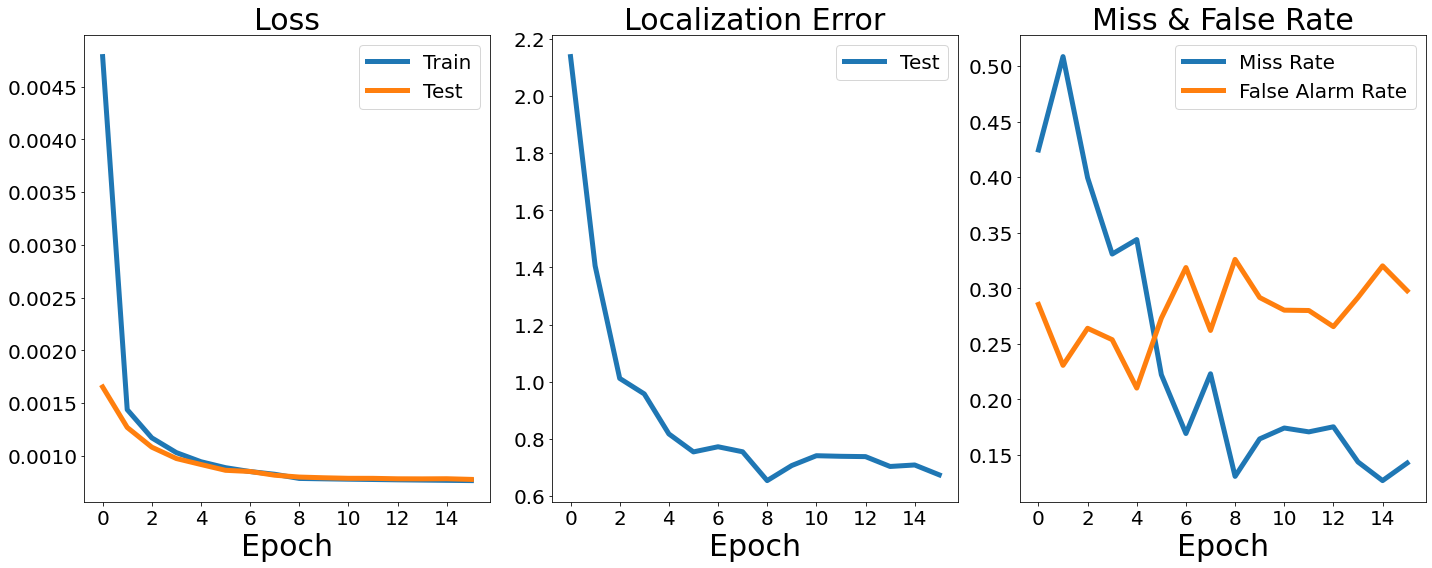

In [69]:
# %%time
# image translation problem
device     = torch.device('cuda')

path1 = 'model/model1-11.12.pt'
path2 = 'model/model2-11.18.pt'
model2_minloss = 1000

model1   = NetTranslation4()
model1.load_state_dict(torch.load(path1))
model1   = model1.to(device)
model1.eval()

max_ntx  = 5
model2   = NetTranslation4()
model2   = model2.to(device)
pos_weight = tensor([2]).to(device)
bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
scheduler2 = optim.lr_scheduler.StepLR(optimizer2, step_size=8, gamma=0.1)

num_epochs = 16
train_losses2_epoch = []
train_errors2_epoch = []
test_losses2_epoch  = []
test_errors2_epoch  = []
test_misses2_epoch, test_falses2_epoch  = [], []
test_num_tx = []
print_every = 200
error_every = 10
zeros  = make_zeros(batch=32, length=100)
alpha  = 0    # control regulation


for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    train_losses2 = []
    test_losses2, test_errors2, test_misses2, test_falses2, test_num_tx, test_pred_num  = [], [], [], [], [], []
    model2.train()
    for t, sample in enumerate(sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        y2 = sample['target2'].to(device)
        y_num   = sample['target_num'].to(device)
        y_num2  = np.array(sample['target_num'])
        y_float = np.array(sample['target_float'])
        y_float = my_uncollate(y_num2, y_float)
        indx = sample['index']

        pred_matrix  = model1(X)              # the model for iamge translation
        pred_matrix2 = model2(X)              # the model for ...

        loss2 = bce_loss(pred_matrix2, y2)
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()

        train_losses2.append(loss2.item())
        if t % print_every == 0:
            print(f't = {t}, loss_matrix = {loss2.item()}')

    model2.eval()
    for t, sample in enumerate(sensor_input_test_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        y2 = sample['target2'].to(device)
        y_num   = sample['target_num'].to(device)
        y_num2  = np.array(sample['target_num'])
        y_float = np.array(sample['target_float'])
        y_float = my_uncollate(y_num2, y_float)
        indx = sample['index']

        pred_matrix  = model1(X)              # the model for iamge translation
        pred_matrix2 = model2(X)              # the model for ...

        loss2 = bce_loss(pred_matrix2, y2)
        test_losses2.append(loss2.item())
        if t % print_every == 0:
            print(f't = {t}, loss_matrix = {loss2.item()}')
        if t % error_every == 0:
            pred_batch  = pred_matrix2.data.cpu().numpy()
            pred_locs, errors, misses, falses = Metrics.localization_error_binary(pred_batch, y_float, indx, Default.grid_length, debug=False)
            test_pred_num.extend([len(locs) for locs in pred_locs])
            test_num_tx.extend(list(y_num2))
            test_errors2.extend(errors)
            test_misses2.extend(misses)
            test_falses2.extend(falses)

    scheduler2.step()
    test_errors2 = [val for sublist in test_errors2 for val in sublist]  # flatten an 2D list
    show_epochs()

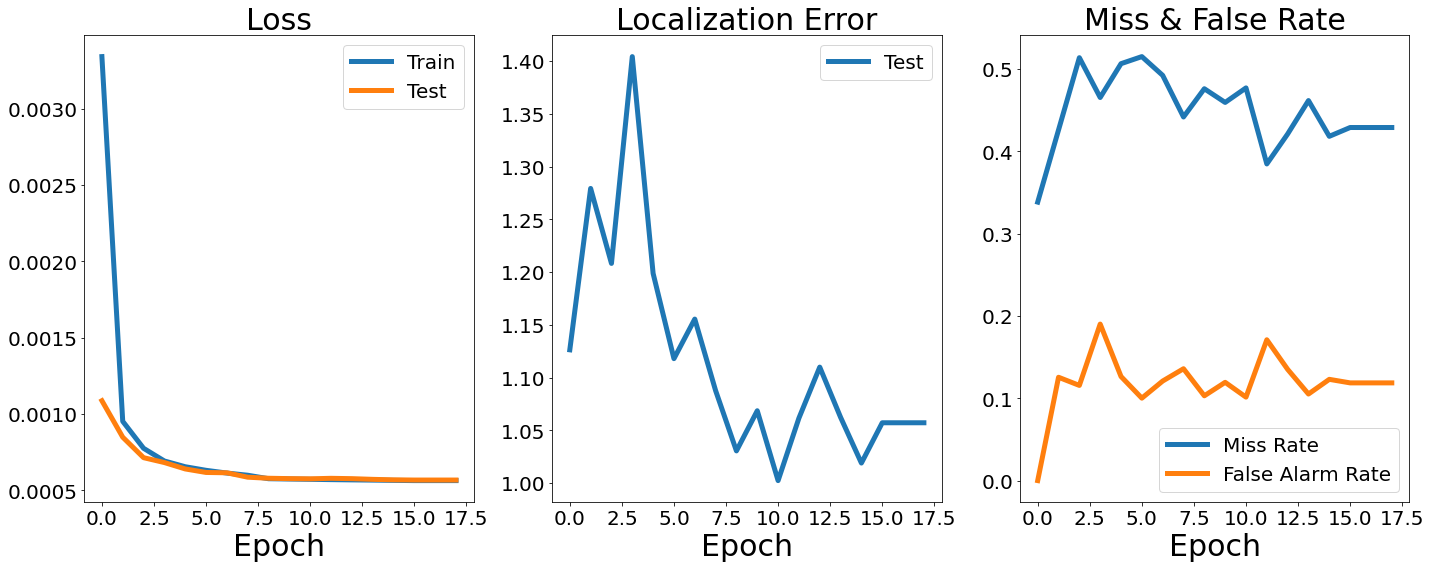

In [68]:
pos_weight = 1
show_epochs()

# Evaluation

pred num of peaks [0 3 0 2 2 0 1 1 4 3 5 1 0 1 1 1 1 5 4 3 3 0 3 3 2 1 0 3 2 1 0 3]
true num of peaks [2 5 2 2 3 1 2 1 4 4 4 2 1 3 1 3 3 3 5 4 3 3 4 4 3 4 5 4 5 1 1 2]
number of TX accuracy 0.1875
0 1 2 3 4 5 6 7 

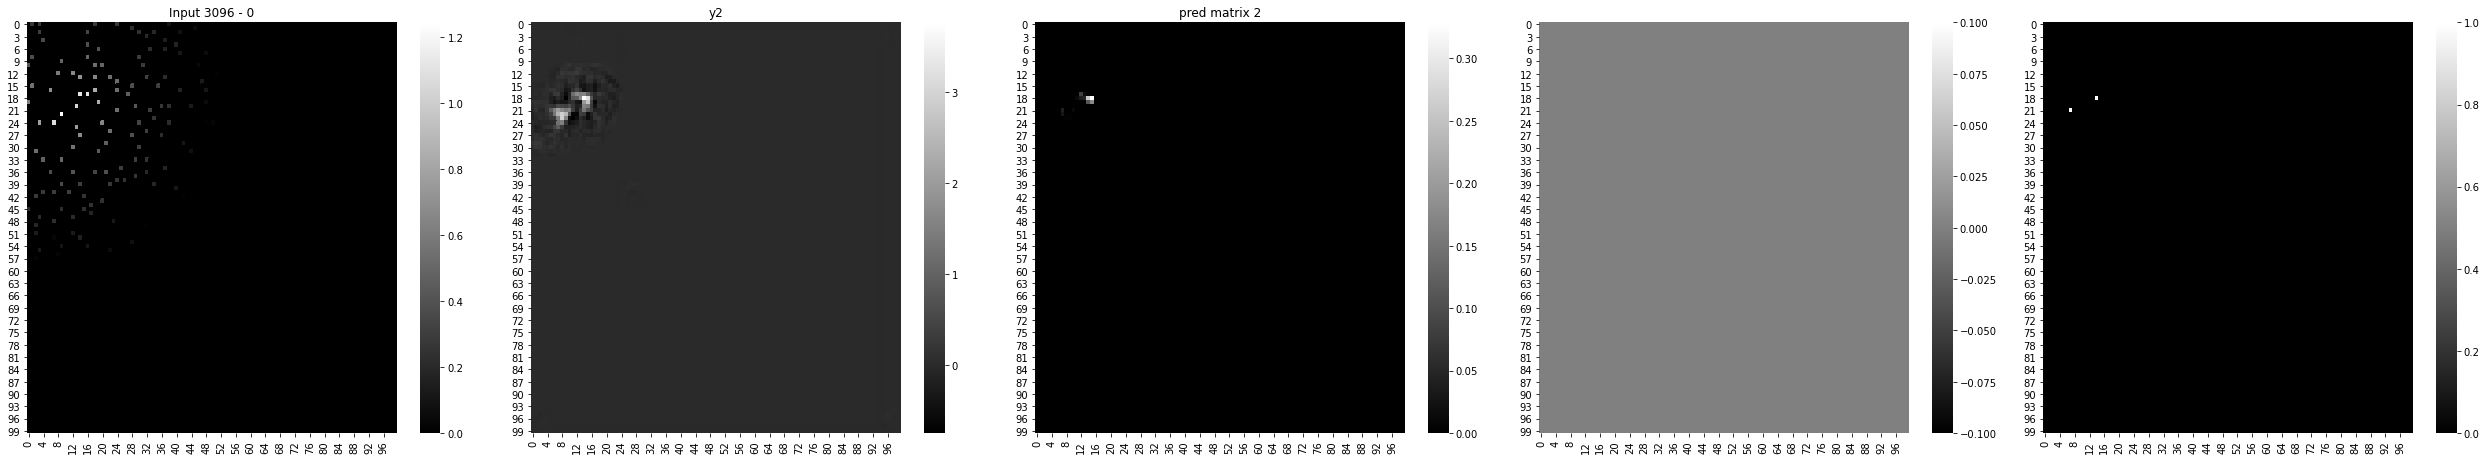

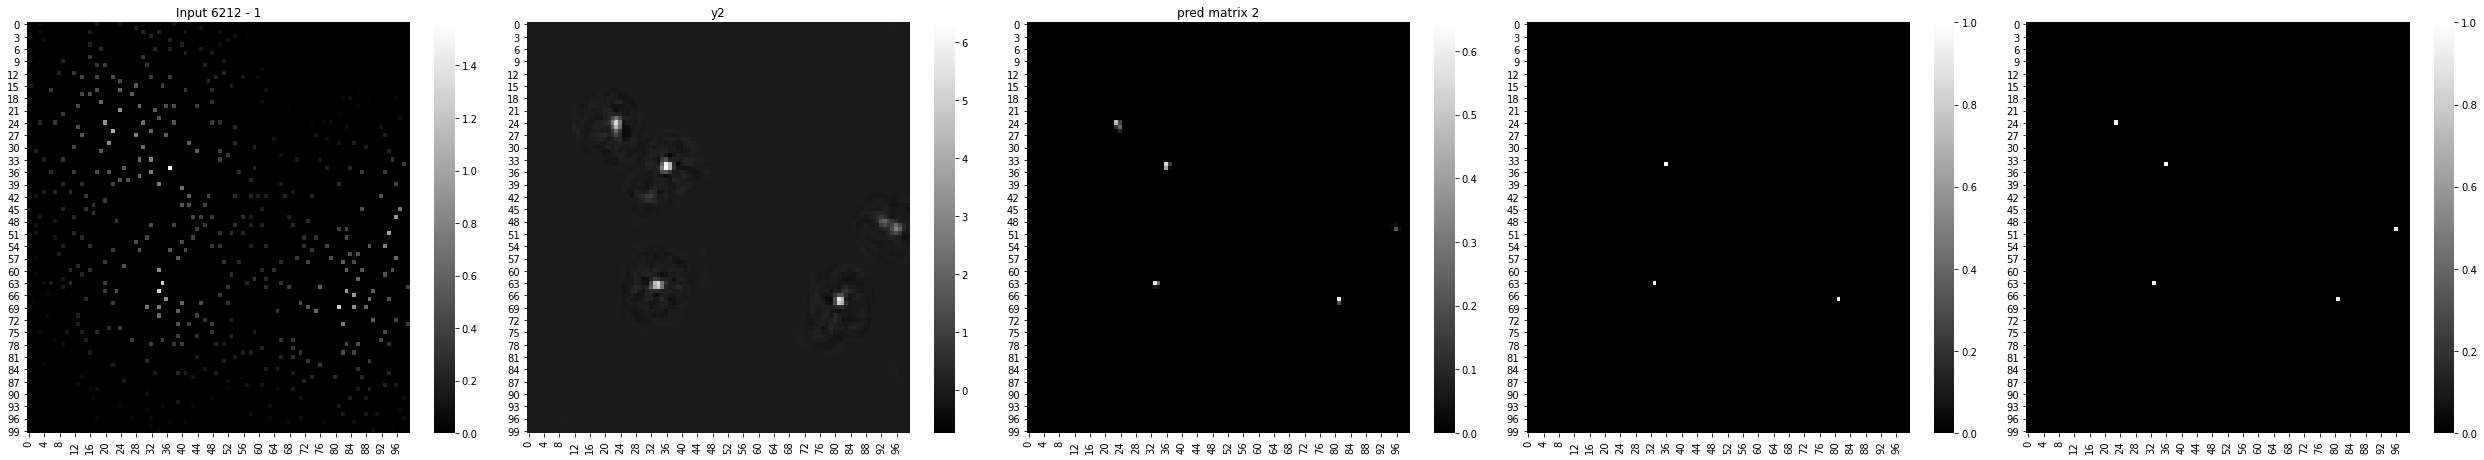

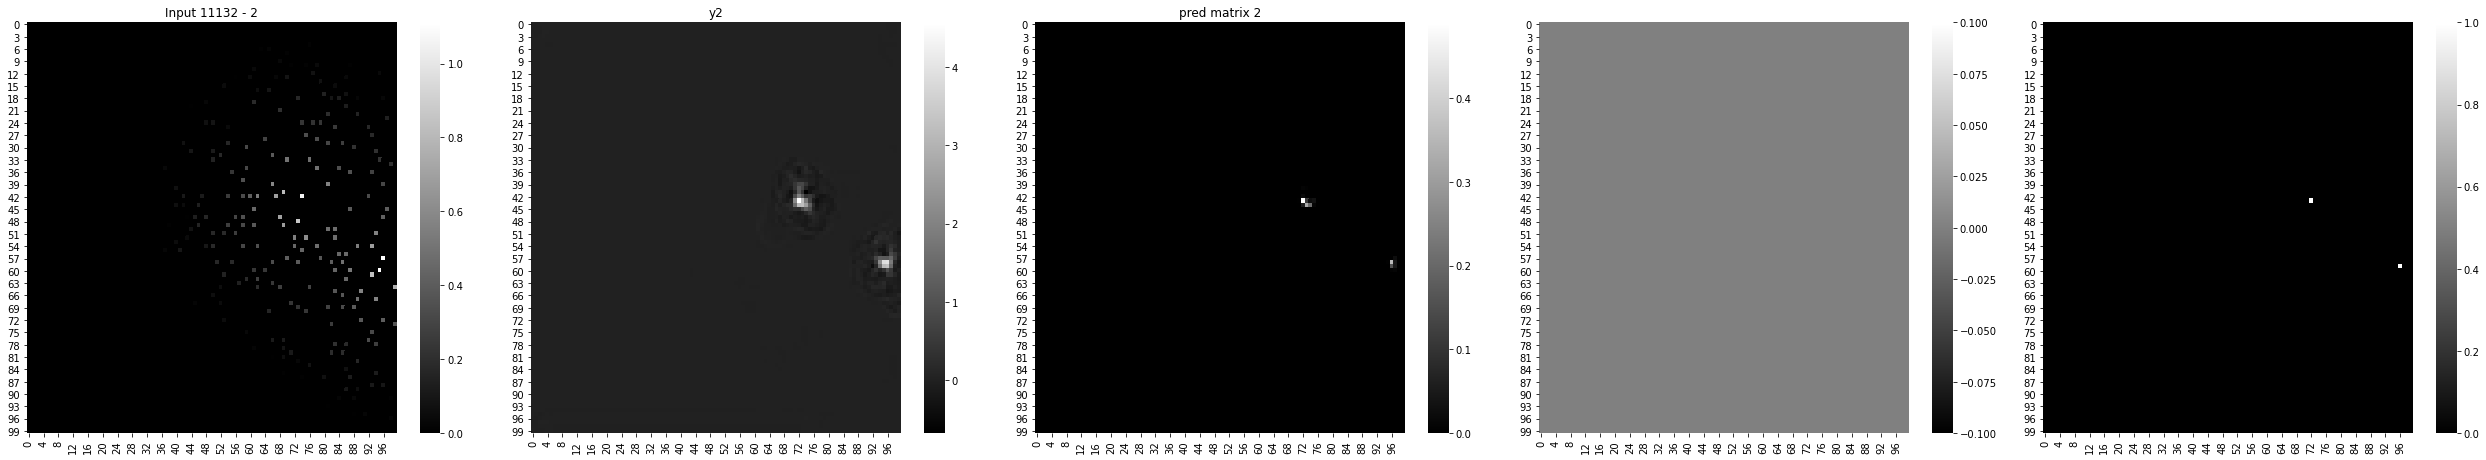

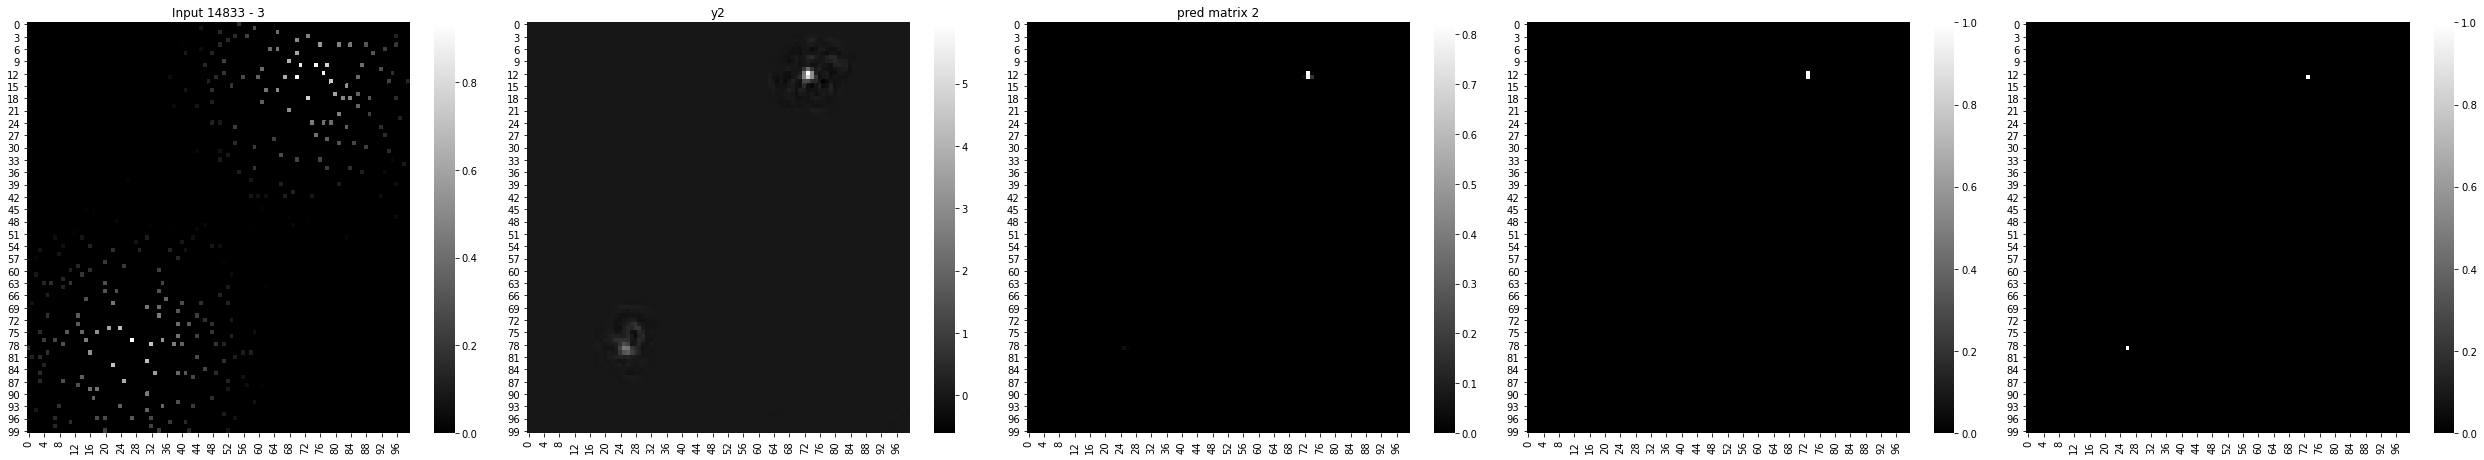

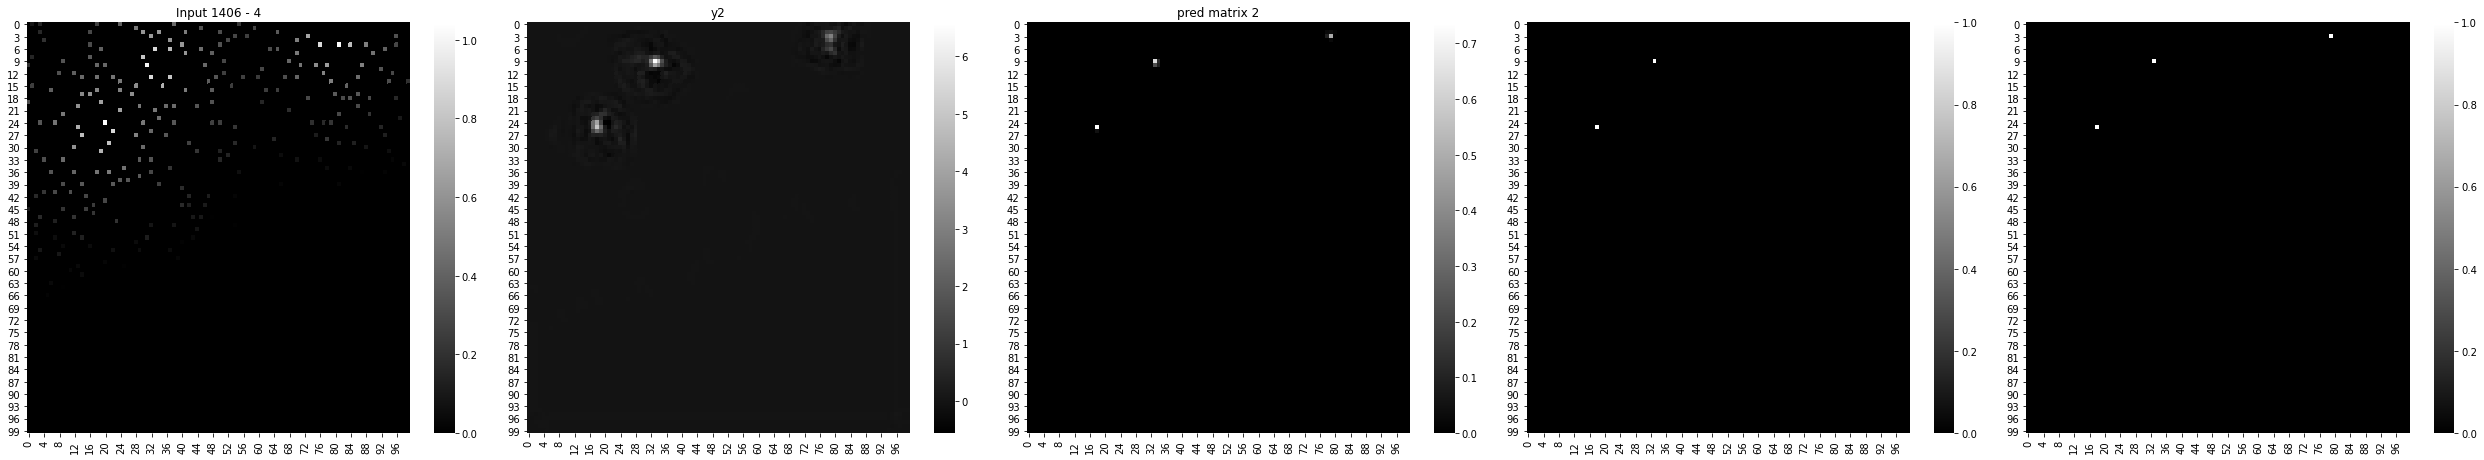

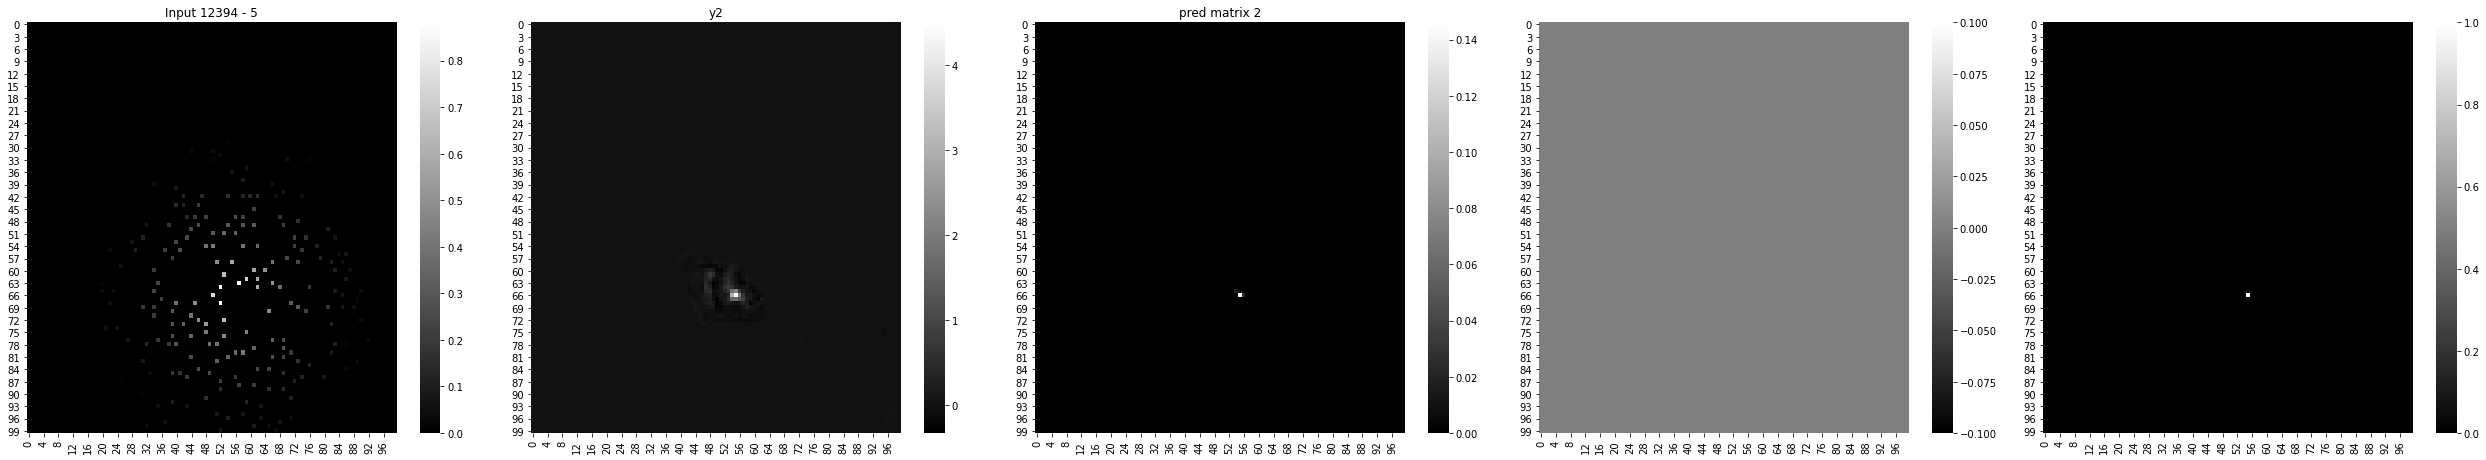

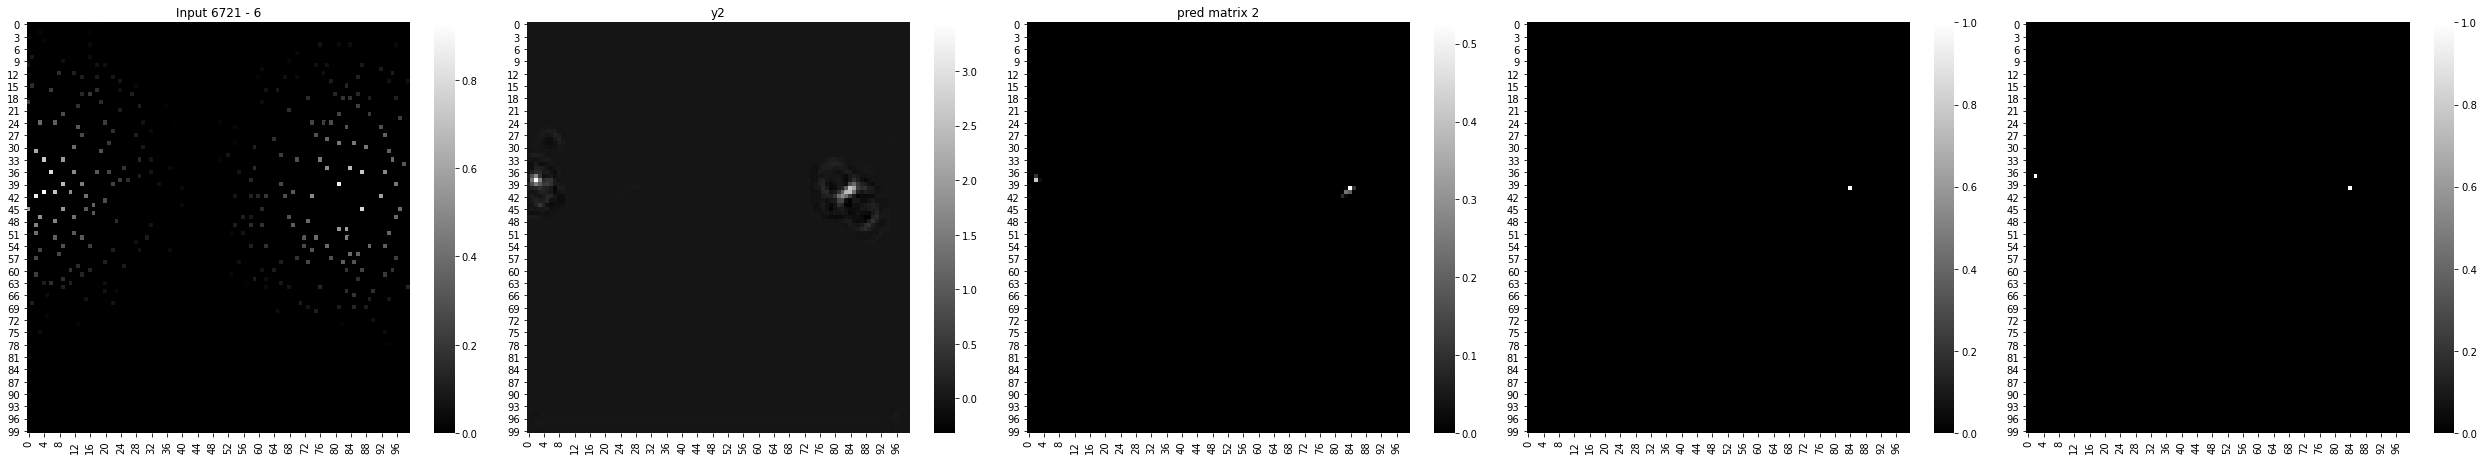

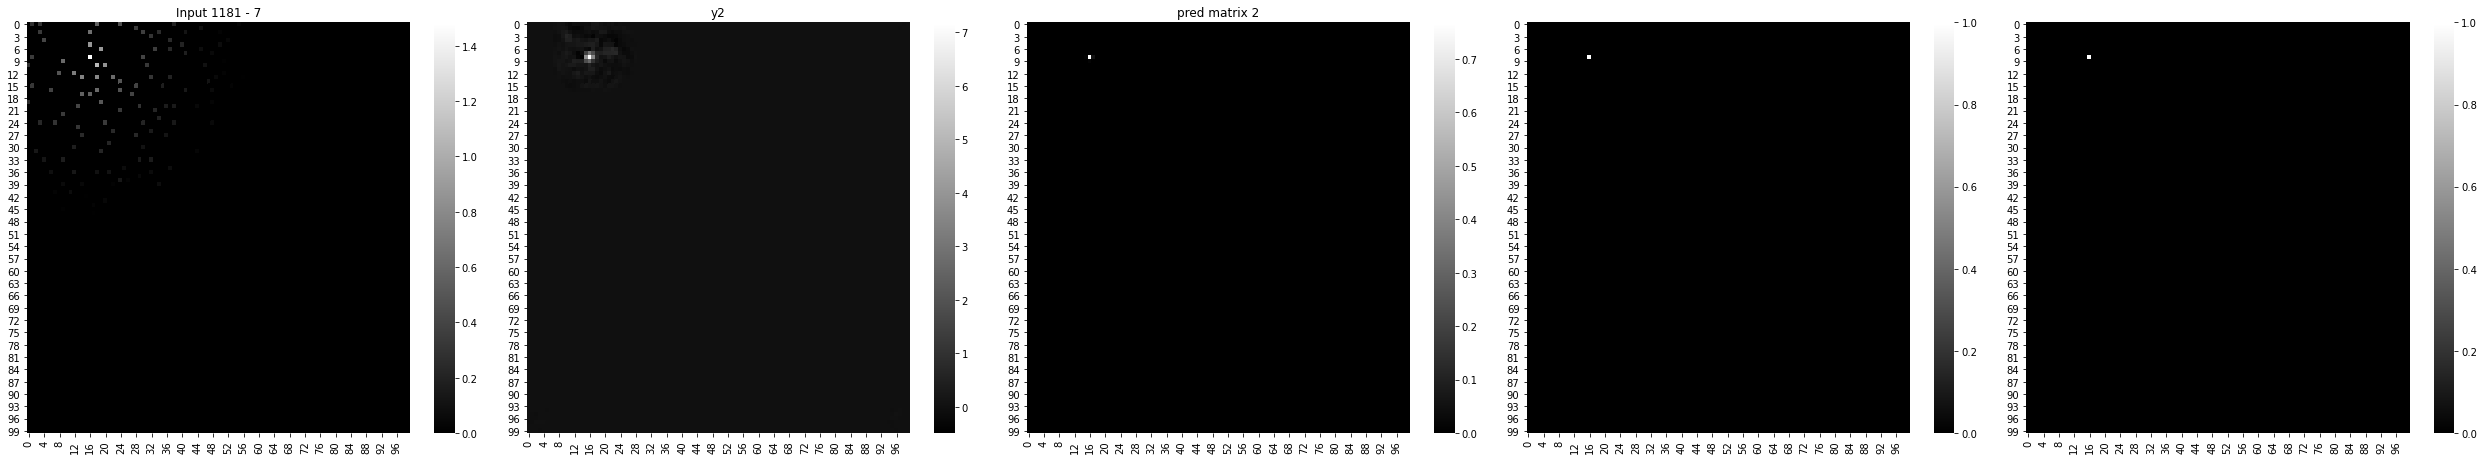

In [16]:
# evaluation for one random batch
plt.rcParams.update({'figure.max_open_warning': 0})
CUDA_LAUNCH_BLOCKING="1"

test_index = []
model1.eval()
model2.eval()
for t, sample in enumerate(sensor_input_test_dataloader):
    X = sample['matrix'].to(device)
    y = sample['target'].to(device)
    y2 = sample['target2'].to(device)
    y_num   = sample['target_num'].to(device)
    y_num2  = np.array(sample['target_num'])
    y_float = np.array(sample['target_float'])
    y_float = my_uncollate(y_num2, y_float)
    indx = sample['index']

    pred_matrix  = model1(X)              # the model for iamge translation
    pred_matrix2 = model2(X)              # the model for ...

    loss2 = bce_loss(pred_matrix2, y2)

    test_index.extend(indx.numpy())
    break

X = X.data.cpu().numpy()
pred_matrix_copy = pred_matrix.data.cpu().numpy()
pred_matrix2_copy = pred_matrix2.data.cpu().numpy()
y = y.data.cpu().numpy()
y2_copy = y2.data.cpu().numpy()

peak_num = num_pred(pred_matrix2_copy)
print('pred num of peaks', peak_num)
print('true num of peaks', y_num2)
num_correct = (peak_num == y_num2).sum()
total = len(y_num2)
print('number of TX accuracy', num_correct / total)

for i in range(int(len(X)/4)):
    myplot4(i, test_index[i], X[i], pred_matrix_copy[i], pred_matrix2_copy[i], y[i], y2_copy[i])
    print(i, end=' ')

In [15]:
def myplot4(i, indx, X, pred_matrix, pred_matrix2, y, y2):
    fig, axs = plt.subplots(1, 5, figsize=(35, 6.5))
    sns.heatmap(X[0], cmap='gray', annot=False, ax=axs[0])
    sns.heatmap(pred_matrix[0], cmap='gray', annot=False, ax=axs[1])
    pred_matrix2 = mysigmoid(pred_matrix2)
    sns.heatmap(pred_matrix2[0], cmap='gray', annot=False, ax=axs[2])
    pred_matrix2 = pred_matrix2 > 0.5
    sns.heatmap(pred_matrix2[0], cmap='gray', annot=False, ax=axs[3])
    sns.heatmap(y2[0], cmap='gray', annot=False, ax=axs[4])
    axs[0].set_title(f'Input {indx} - {i}')
    axs[1].set_title('pred matrix 1')
    axs[2].set_title('pred matrix 2')
    axs[1].set_title('pred matrix 2 (0,1)')
    axs[1].set_title('y2')
    fig.tight_layout()

In [164]:
# evaluation for all test samples

path1 = 'model/model1-11.12.pt'
path2 = 'model/model2-11.16-2.pt'

device = torch.device('cuda')
model1 = NetTranslation4()
model1.load_state_dict(torch.load(path1))
model1 = model1.to(device)
max_ntx = 5
model2 = NetNumTx2(max_ntx)
model2.load_state_dict(torch.load(path2))
model2.to(device)
model2 = model2.to(device)

model1.eval()
model2.eval()

test_index, test_errors1, test_misses1, test_falses1 = [], [], [], []
ntx_correct, ntx_total = 0, 0
tx_num_total = 0
test_index_ntx_wrong = []

for t, sample in enumerate(sensor_input_test_dataloader):
    if t % 10 == 9:
        print(t, end=' ')
    X = sample['matrix'].to(device)
    y = sample['target'].to(device)
    y_num   = sample['target_num'].to(device)
    y_num2  = np.array(sample['target_num'])
    y_float = np.array(sample['target_float'])
    y_float = my_uncollate(y_num2, y_float)
    indx = sample['index']

    pred_matrix = model1(X)              # the model for iamge translation
    pred_ntx    = model2(X)              # the model for num TX

    pred_matrix = pred_matrix.data.cpu().numpy()
    _, pred_ntx = pred_ntx.data.cpu().max(1)
    pred_ntx = (pred_ntx+1).numpy()      # class 0 means 1 TX, class 1 means 2 TX etc...

    errors, misses, falses = Metrics.localization_error_image_continuous(pred_matrix, pred_ntx, y_float, indx, Default.grid_length, 1)
    test_errors1.extend(errors)
    test_misses1.extend(misses)
    test_falses1.extend(falses)
    test_index.extend(indx.numpy())
    ntx_correct += (pred_ntx == y_num2).sum()
    ntx_total += len(pred_ntx)
    tx_num_total += y_num2.sum()
    for idx, boolean in zip(indx, pred_ntx == y_num2):
        if boolean == False:
            test_index_ntx_wrong.append(idx)

print()
test_errors1_tmp = [val for sublist in test_errors1 for val in sublist]
print('error', np.mean(test_errors1_tmp), np.std(test_errors1_tmp))
print('miss ', np.sum(test_misses1) / tx_num_total)
print('false', np.sum(test_falses1) / tx_num_total)
print('Num of TX prediction accuracy = {}'.format(ntx_correct * 1.0 / ntx_total))

9 19 29 39 49 59 69 79 89 99 109 119 129 139 149 159 169 179 189 199 209 219 229 239 249 259 269 279 289 299 309 319 329 339 349 359 369 379 389 399 409 419 429 439 449 459 469 479 489 499 509 519 529 539 549 559 569 
error 0.4291618207623682 0.48288928968728856
miss  0.012199118750227595
false 0.006736826772513747
Num of TX prediction accuracy = 0.9320746527777778


model1-11.12.pt & model2-11.16-2.pt
* using a different set of sensors

error 0.4291618207623682 0.48288928968728856
miss  0.012199118750227595
false 0.006736826772513747
Num of TX prediction accuracy = 0.9320746527777778

model1-11.12.pt & model2-11.16-3.pt
* model1-11.16-3.pt is not well, so use an older version of model1

error 0.4014268100592038 0.5028958483469218
miss  0.002960449121793599
false 0.002816036969510984
Num of TX prediction accuracy = 0.9976671006944444

model1-11.16-3.pt & model2-11.16-3.pt
* using lr_scheduler and NumTxNet2 (better than NumTxNet), but the model1-11.16-3 is bad

error 0.5187925670736164 0.7593544621760513
miss  0.012293084463057566
false 0.007365019766413344
Num of TX prediction accuracy = 0.9976671006944444

model1-11.12.pt & model2.11.12-2
* using another set of sensors

error 0.4129955132368109 0.37693758008787215
miss  0.04675721932923055
false 0.003514074505662576
Num of TX prediction accuracy = 0.7639431423611112

model1-11.12.pt & model2.11.12-2

error 0.3980281844097833 0.4841600812226158
miss  0.0058486921674458904
false 0.0013538639276495117
Num of TX prediction accuracy = 0.99072265625

model-11.12-2.pt (no regulation), edge = 2

error 0.4166837566224261 0.4991828992308827
miss  0.008484213946603607
false 0.0017871003844973554
Num of TX prediction accuracy = 0.99072265625

model-11.12.pt (regulation alpha = 0.0001), edge = 2

error 0.39614567762105557 0.47199536281142523
miss  0.006877628752459519
false 0.0013358124086141848
Num of TX prediction accuracy = 0.9878472222222222

model1-11.10.pt (regulation alpha = 0.0001)
model2-11.11.pt

error 0.4063343126720838 0.529690663848824
miss  0.008506034124011653
false 0.0026466916354556803
Num of TX prediction accuracy = 0.98505

model-11.11-2.pt

error 0.4262103585993057 0.5091830545187477
miss  0.012201414898044112
false 0.002546816479400749
Num of TX prediction accuracy = 0.9836

model-11.11.pt (regulation alpha=0.01)

error 0.41485570904563196 0.5067546659464742
miss  0.010703287557220142
false 0.0031294215563878484
Num of TX prediction accuracy = 0.98505

model-11.10.pt (no regulation)

error 0.40407929619853045 0.5169914664871702
miss  0.009954223886808156
false 0.002430295464003329
Num of TX prediction accuracy = 0.9819

In [180]:
for idx in np.array(test_index_ntx_wrong):
    print(idx, end='  ')

17567  12167  15452  14043  16169  1348  8876  9288  15521  1095  4239  17283  12817  8462  6154  18042  2303  13808  14820  2244  12085  1462  17104  8901  15193  3097  8881  16397  5229  383  17437  15156  1304  17649  10068  13572  863  16179  13447  10364  9012  944  10684  912  15725  16667  8090  4607  15447  14779  4092  15358  18131  16243  17787  9329  5306  8440  7528  1338  8747  4215  17674  6011  4182  7049  3361  3278  14476  472  14527  2063  4487  3478  8624  13215  1571  14970  651  15579  7185  14000  11333  1600  14606  16123  17856  3793  16908  7160  7209  14993  5164  12415  7952  8234  17657  9316  6203  12336  3354  17462  17769  5924  903  14589  17284  7788  2401  18052  9401  4329  18220  13307  4583  13057  17836  10152  359  8813  1605  5558  12372  18238  14951  7972  480  14894  3767  16503  15842  16100  2460  14339  13076  5549  4007  4970  3845  111  13381  593  1156  7734  327  17777  8608  5458  9103  7690  823  2443  7389  10859  1809  3626  12982  

In [13]:
# OBSERVATION: big errors happens in the edge and corners.

for indx, errors, miss, false in zip(test_index, test_errors, test_misses, test_falses):
    if max(errors) > 3 or miss > 0 or false > 0:
        print(indx, errors, miss, false)

977 [0.2496, 12.1932] 0 0
19824 [0.3258] 1 0
11368 [0.2633] 1 0
18782 [1.3831, 13.3894] 0 0
10083 [0.7158, 12.3542] 0 0
14900 [0.1621, 13.5345] 0 0
5785 [0.9813] 1 0
4888 [0.5369, 6.3445] 0 0
15549 [0.3587, 12.713] 0 0
4109 [0.7079, 16.138] 0 0
3730 [1.2951, 8.1183] 0 0
12882 [0.6515, 10.4055] 0 0
5594 [0.8726, 8.2959] 0 0
7403 [1.2535, 10.316] 0 0
7962 [0.5189, 7.6124] 0 0
9572 [1.3827, 13.431] 0 0
12043 [0.3887, 10.9694] 0 0
8329 [0.205, 10.8616] 0 0
15922 [0.3454, 9.3949] 0 0
3415 [0.0127, 11.4417] 0 0
16340 [0.2986, 14.9793] 0 0
7616 [0.56, 8.3817] 0 0
10005 [0.505] 1 0
18056 [1.8772] 1 0
7221 [1.2482, 9.4152] 0 0
12298 [0.5027, 8.3651] 0 0
8992 [1.0007, 7.4849] 0 0
10908 [0.3836] 1 0
10065 [0.3094, 13.2885] 0 0
8934 [0.2118, 5.2948] 0 0
15130 [1.6757, 8.3572] 0 0
7310 [0.2663, 10.5104] 0 0
12588 [0.8585] 1 0
19780 [1.3151, 10.0109] 0 0
14702 [0.6747] 1 0
10303 [0.3268, 10.1875] 0 0
11382 [4.5833] 1 0
7428 [0.1589, 7.0429] 0 0
5778 [1.0475] 1 1
3493 [0.2789] 1 0
14672 [0.5901, 11.3

In [68]:
# folder = '2TXupbound-20-min-dist'
# np.savetxt(f'result/{folder}/train_losses1.txt', test_losses1_epoch)
# np.savetxt(f'result/{folder}/train_errors.txt', test_losses2_epoch)
# np.savetxt(f'result/{folder}/test_loss.txt', test_errors1_epoch)
# np.savetxt(f'result/{folder}/test_errors.txt', test_errors2_epoch)
# np.savetxt(f'result/{folder}/test_misses.txt', test_misses1_epoch)
# np.savetxt(f'result/{folder}/test_falses.txt', test_falses1_epoch)

In [17]:
def myplot(X, pred, pred_n, y, indx, i):
    fig, axs = plt.subplots(1, 3, figsize=(30, 8))
    sns.heatmap(X[0], cmap='gray', annot=False, ax=axs[0])
    sns.heatmap(pred[0], cmap='gray', annot=False, ax=axs[1])
    sns.heatmap(y[0], cmap='gray', annot=False, ax=axs[2])
    axs[0].set_title(f'{indx} - {i}')
    axs[1].set_title(f'# of predict TX {pred_n:.2f}')
    fig.tight_layout()

def myplot3(pred, y, y_float):
    '''
    Args:
        pred    -- array like -- 2d dimension pred matrix
        y       -- array like -- 2d dimension true matrix
        y_float -- array like -- (num_tx, 2), second dimension 2 means a pair of (x, y)
    '''
    print(y_float)
    fig, axs = plt.subplots(1, len(y_float), figsize=(25, 5))
    for i in range(len(y_float)):
        a, b = y_float[i]
        a, b = int(a), int(b)
        a1 = a-5 if a >= 5 else 0
        a2 = a+5 if a <= Default.grid_length-5 else Default.grid_length
        b1 = b-5 if b >= 5 else 0
        b2 = b+5 if b <= Default.grid_length-5 else Default.grid_length
        print(f'pred {i} ({a1}, {a2}), ({b1}, {b2})')
        sns.heatmap(pred[a1:a2,b1:b2], cmap='gray', annot=True, ax=axs[i])
        axs[i].set_title(f'pred {i} ({a}, {b})')
    fig.tight_layout()
    fig, axs = plt.subplots(1, len(y_float), figsize=(25, 5))
    for i in range(len(y_float)):
        a, b = y_float[i]
        a, b = int(a), int(b)
        a1 = a-5 if a >= 5 else 0
        a2 = a+5 if a <= Default.grid_length-5 else Default.grid_length
        b1 = b-5 if b >= 5 else 0
        b2 = b+5 if b <= Default.grid_length-5 else Default.grid_length
        print(f'y    {i} ({a1}, {a2}), ({b1}, {b2})')
        sns.heatmap(y[a1:a2, b1:b2], cmap='gray', annot=True, ax=axs[i])
        axs[i].set_title(f'y   {i} ({a}, {b})')
    fig.tight_layout()

loss matrix = 0.03549924120306969
loss num tx = 2.24088454246521
pred raw tensor([[ -86.2134, -129.9771,  -15.5851,    8.7896,    6.6612]],
       device='cuda:0', grad_fn=<AddmmBackward>)
pred ntx [4]
0 15968 pred [(64.46, 58.77), (76.68, 28.52), (83.4, 91.38), (85.69, 18.6)] ; truth [(85.77, 18.43), (83.14, 91.18), (64.33, 59.16), (72.53, 62.4), (77.0, 29.16)]  ; error [0.187, 0.3285, 0.411, 0.7142]  ; miss 1  ; false 0
[[85.77319  18.434893]
 [83.13575  91.18188 ]
 [64.33393  59.158585]
 [72.531975 62.403095]
 [76.99734  29.15838 ]]
pred 0 (80, 90), (13, 23)
pred 1 (78, 88), (86, 96)
pred 2 (59, 69), (54, 64)
pred 3 (67, 77), (57, 67)
pred 4 (71, 81), (24, 34)
y    0 (80, 90), (13, 23)
y    1 (78, 88), (86, 96)
y    2 (59, 69), (54, 64)
y    3 (67, 77), (57, 67)
y    4 (71, 81), (24, 34)


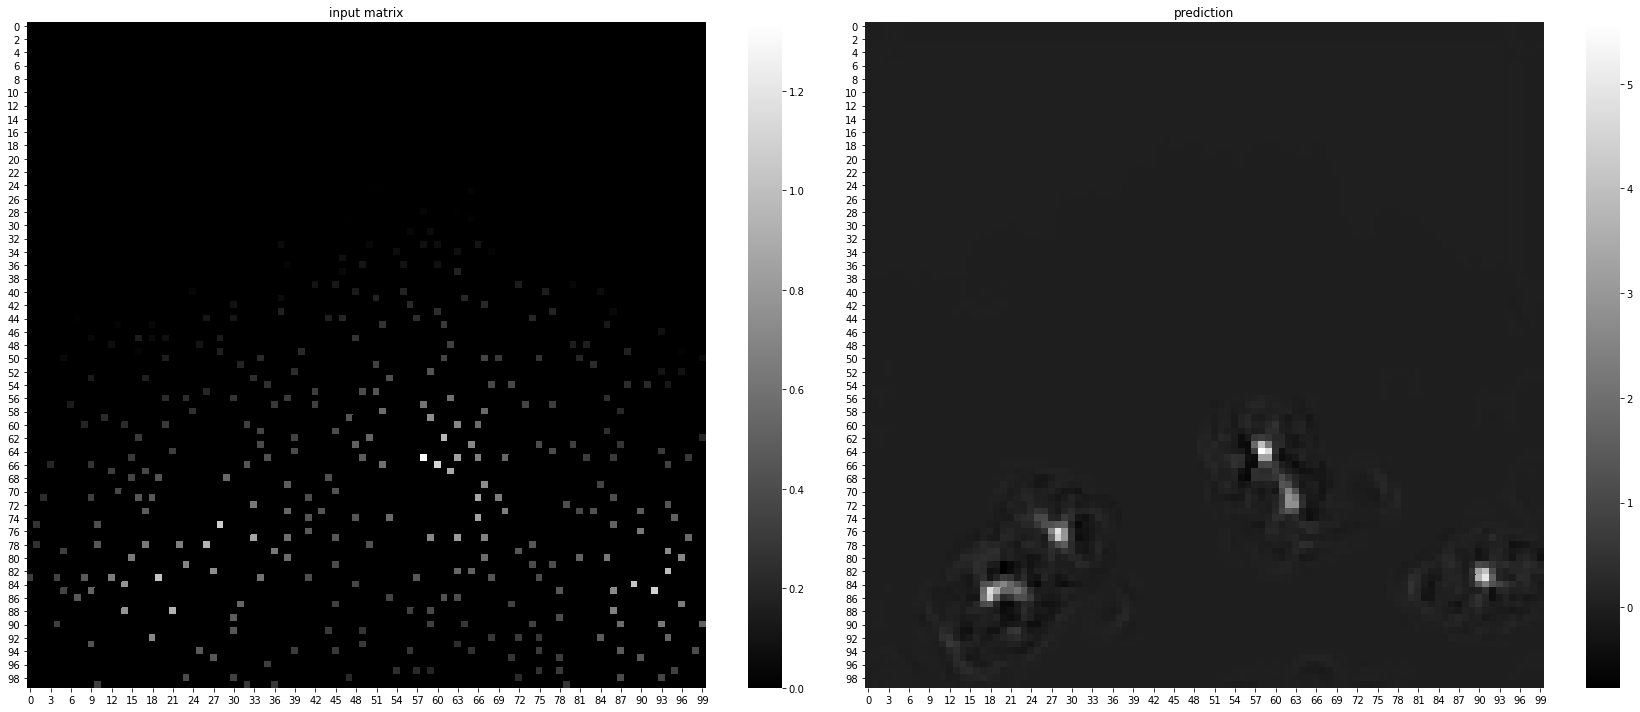

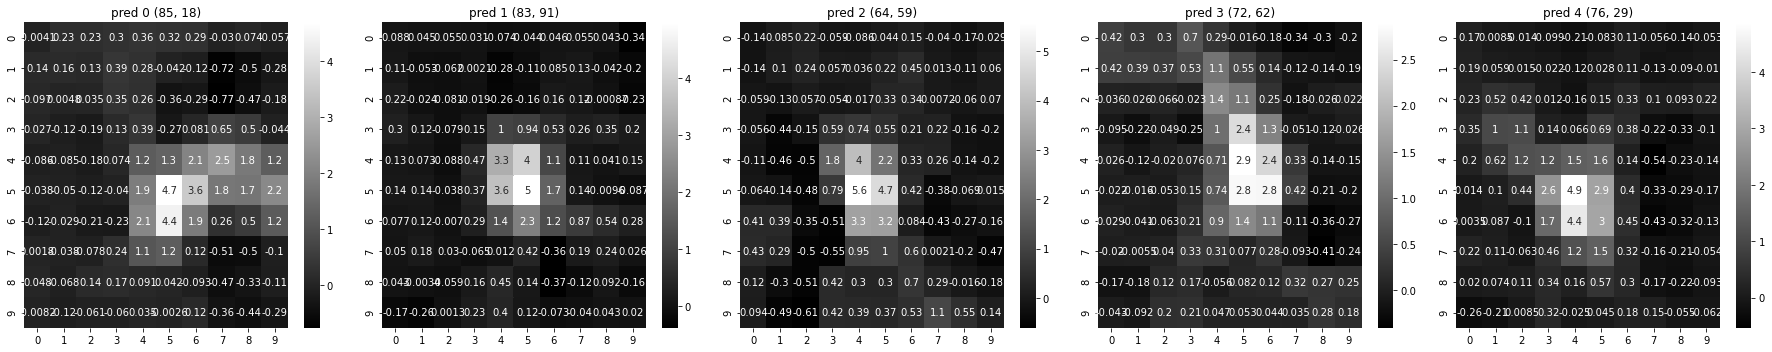

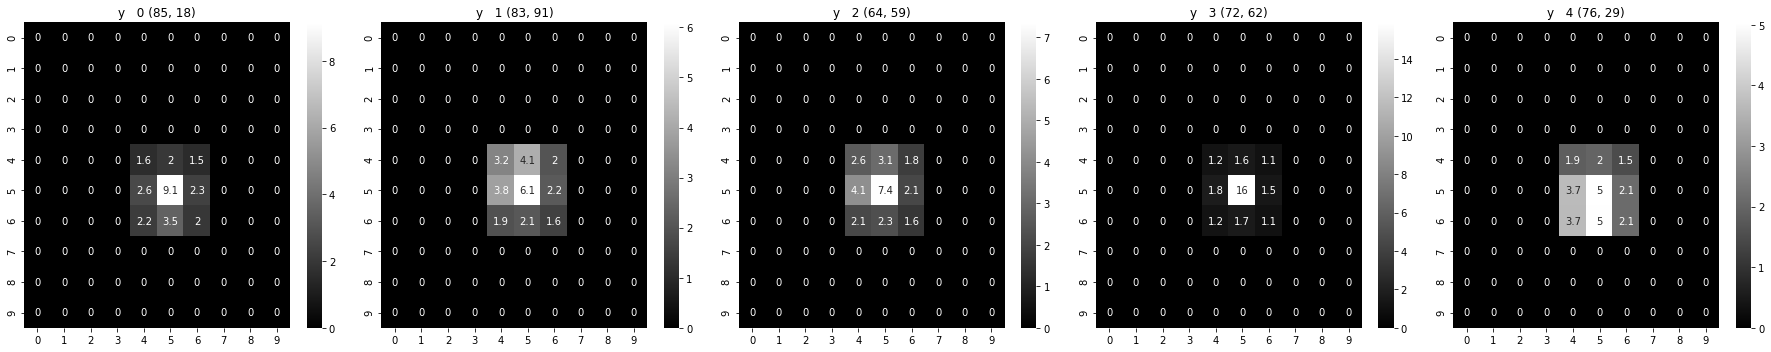

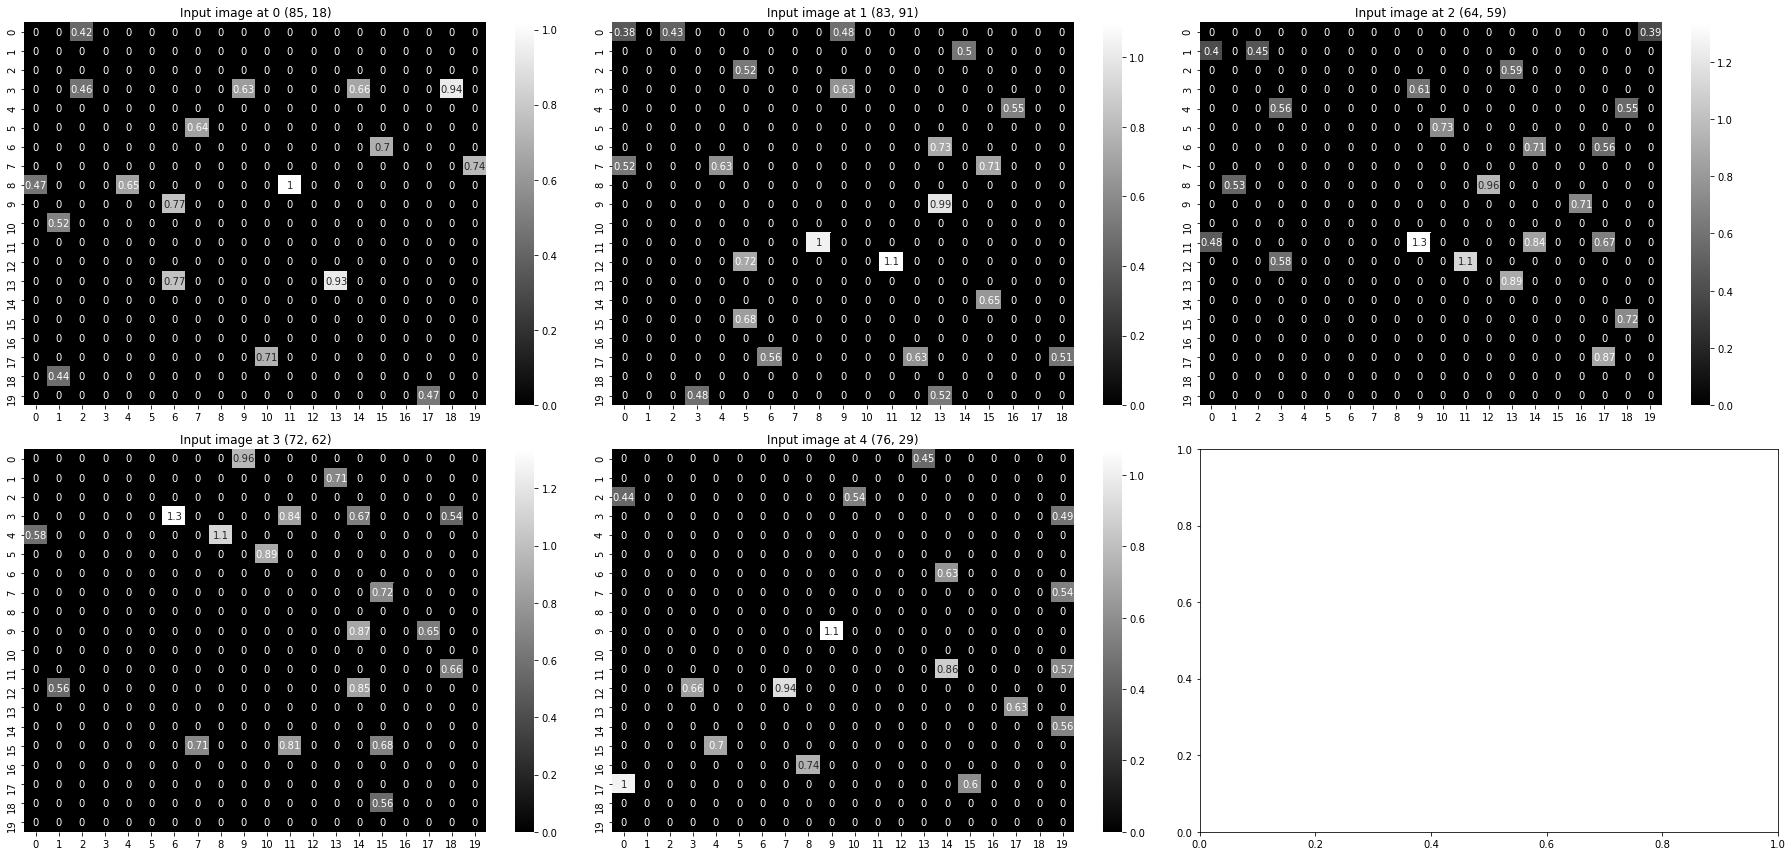

In [20]:
# Test for one sample

# idx = 15668  # two TX close, one peak covers the other
# idx = 7329  # two TX close, one peak covers the other
# idx = 18327    # one TX cannot meet peak threshold at low sensor density area
# idx = 2418   # edge issue
# idx = 8662    # one TX cannot meet peak threshold at low sensor density area
# idx = 12289   # one TX cannot meet peak threshold at low sensor density area
# idx = 12215 # too close to call (tctc)
# idx = 11221     # num of TX wrong, but peak finding is right

idx = 17567    # three TX close to each other
idx = 15968

def one_sample(idx):
    device = torch.device('cuda')
    model1.eval()
    model2.eval()
    sample = sensor_input_test_dataset[idx]
    X = torch.as_tensor(sample['matrix'])
    X = X.unsqueeze(0).to(device)            # increase dimension to a batch
    y = torch.as_tensor(sample['target'])
    y = y.unsqueeze(0).to(device)            # increase dimension to a batch
    y_num = torch.as_tensor(sample['target_num'])
    y_num = y_num.unsqueeze(0).to(device)    # increase dimension to a batch
    y_f = np.expand_dims(sample['target_float'], 0)
    indx = np.expand_dims(np.array(sample['index']), 0)

    pred_matrix = model1(X)
    pred_ntx    = model2(X)

    loss_matrix = criterion1(pred_matrix, y)
    loss_num_tx = criterion2(pred_ntx, y_num-1)
    print('loss matrix =', loss_matrix.item())
    print('loss num tx =', loss_num_tx.item())

    pred_matrix = pred_matrix.data.cpu().numpy()
    print('pred raw', pred_ntx)
    _, pred_ntx = pred_ntx.data.cpu().max(1)
    pred_ntx = (pred_ntx+1).numpy()    # class 0 means 1 TX, class 1 means 2 TX etc...
    print('pred ntx', pred_ntx)
    errors, misses, falses = Metrics.localization_error_image_continuous(pred_matrix.copy(), pred_ntx, y_f, indx, Default.grid_length, peak_threshold=1, debug=True)

    pred_matrix = pred_matrix[0][0]
    fig, axs = plt.subplots(1, 2, figsize=(24, 10))
    X = X[0][0].data.cpu().numpy()
    sns.heatmap(X, cmap='gray', ax=axs[0])
    axs[0].set_title('input matrix')
    sns.heatmap(pred_matrix, cmap='gray', ax=axs[1])
    axs[1].set_title('prediction')
    plt.tight_layout()
    np.savetxt('test.txt', pred_matrix)
    y = y.data.cpu().numpy()[0][0]
    y_f = y_f[0]
    myplot3(pred_matrix, y, y_f)

    fig, axes = plt.subplots(2, int(len(y_f)/2 + 0.5), figsize=(25, 12))
    for i in range(len(y_f)):
        a, b = y_f[i]
        a, b = int(a), int(b)
        a1 = a-10 if a >= 10 else 0
        a2 = a+10 if a <= Default.grid_length-10 else Default.grid_length
        b1 = b-10 if b >= 10 else 0
        b2 = b+10 if b <= Default.grid_length-10 else Default.grid_length
        sns.heatmap(X[a1:a2,b1:b2], cmap='gray', annot=True, ax=axes.flat[i])
        axes.flat[i].set_title(f'Input image at {i} ({a}, {b})')
    fig.tight_layout()

one_sample(idx)

<AxesSubplot:>

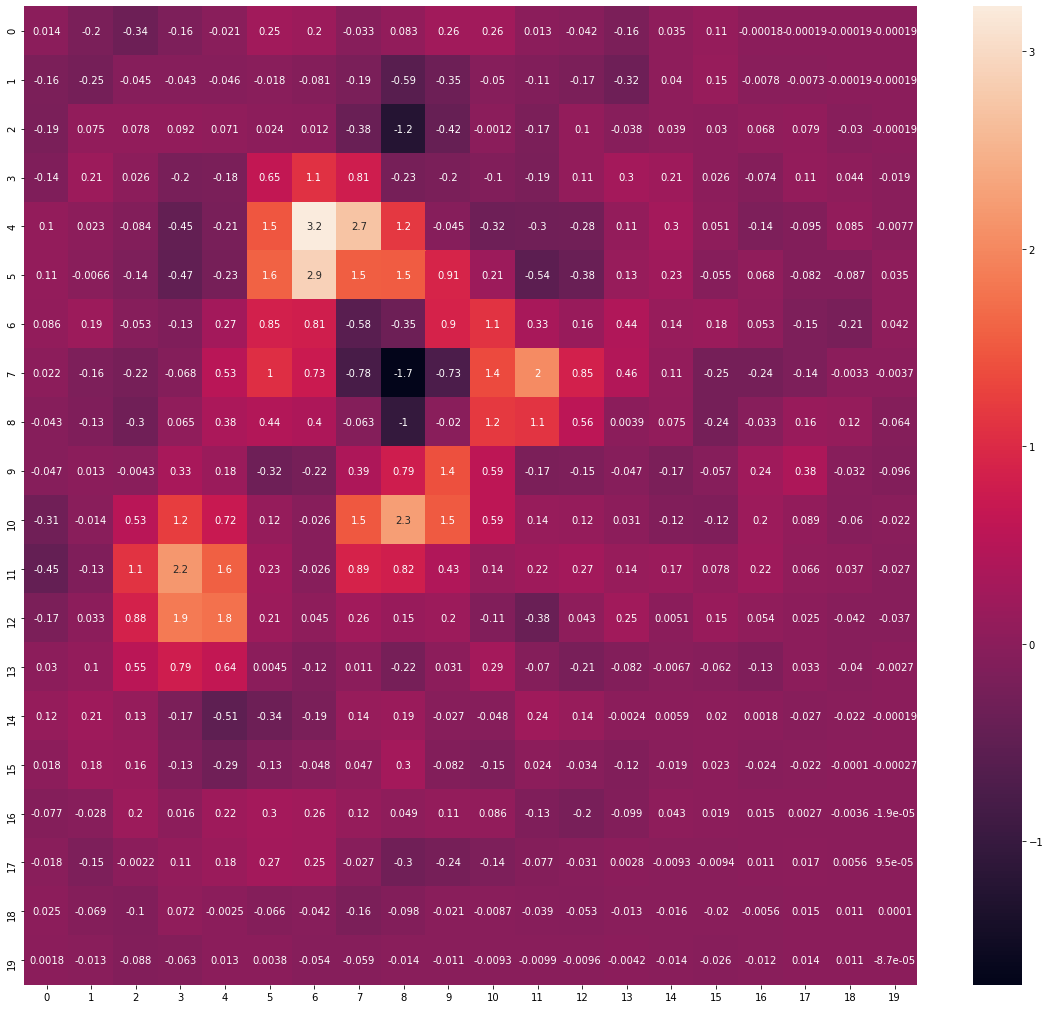

In [182]:
pred = np.loadtxt('test.txt')
fig, ax = plt.subplots(1, 1, figsize=(20, 18))
sns.heatmap(pred[0:20, 40:60], annot=True, ax=ax)

In [18]:
# Test for one random batch
plt.rcParams.update({'figure.max_open_warning': 0})
CUDA_LAUNCH_BLOCKING="1"

criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()

model1.eval()
model2.eval()
for t, sample in enumerate(sensor_input_test_dataloader):
    X = sample['matrix'].to(device)
    y = sample['target'].to(device)
    y_num = sample['target_num'].to(device)
    y_num2  = np.array(sample['target_num'])
    y_float = np.array(sample['target_float'])
    y_float = my_uncollate(y_num2, y_float)
    indx = np.array(sample['index'])

    pred_matrix = model1(X)
    pred_ntx    = model2(X)

    loss_matrix = criterion1(pred_matrix, y)
    loss_num    = criterion2(pred_ntx, y_num-1)
    print('loss matrix =', loss_matrix.item())
    print('loss num    =', loss_num.item())

    losses = []
    for i, pred, yy in zip(range(len(y)), pred_matrix, y):
        pred, yy = pred[0].data.cpu().numpy(), yy[0].data.cpu().numpy()
        loss = Metrics.loss(pred, yy)
        losses.append((i, loss))
    losses.sort(key=lambda x:x[1])
    for idx, (i, loss) in enumerate(losses):
        print('{}: matrix loss = {}'.format(i, loss), end='   ')
        if idx % 4 == 3: 
            print()
    print()
    pred_matrix = pred_matrix.data.cpu().numpy()   # not using .numpy() will cause big issue
    _, pred_ntx = pred_ntx.data.cpu().max(1)
    pred_ntx = (pred_ntx+1).numpy()    # class 0 means 1 TX, class 1 means 2 TX etc...
    errors, misses, falses = Metrics.localization_error_image_continuous(pred_matrix, pred_ntx, y_float, indx, Default.grid_length, peak_threshold=1, debug=True)
    errors = [val for sublist in errors for val in sublist]
    print('error', np.mean(errors), np.std(errors))
    print('miss ', np.sum(misses)/np.sum(y_num2))
    print('false', np.sum(falses)/np.sum(y_num2))
    break

X    = X.data.cpu().numpy()
# pred_matrix = pred_matrix.data.cpu().numpy()
# pred_ntx = pred_ntx.data.cpu().numpy()
y    = y.data.cpu().numpy()
indx = sample['index']

loss matrix = 0.016937414184212685
loss num    = 0.6076226234436035
8: matrix loss = 0.0025923847198486326   24: matrix loss = 0.003969903945922852   19: matrix loss = 0.004389812088012695   7: matrix loss = 0.008315574645996094   
0: matrix loss = 0.008754876708984375   2: matrix loss = 0.009578660583496094   13: matrix loss = 0.010373213195800781   14: matrix loss = 0.010702577972412109   
30: matrix loss = 0.01155973358154297   9: matrix loss = 0.011566868591308593   10: matrix loss = 0.011585707092285156   23: matrix loss = 0.011724624633789062   
5: matrix loss = 0.012506843566894531   6: matrix loss = 0.01361346435546875   17: matrix loss = 0.01383391876220703   4: matrix loss = 0.014171504211425781   
18: matrix loss = 0.014351441955566407   28: matrix loss = 0.014357725524902344   31: matrix loss = 0.01446954345703125   15: matrix loss = 0.016356358337402344   
11: matrix loss = 0.0170271240234375   27: matrix loss = 0.017028018188476563   12: matrix loss = 0.01750244445800781 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

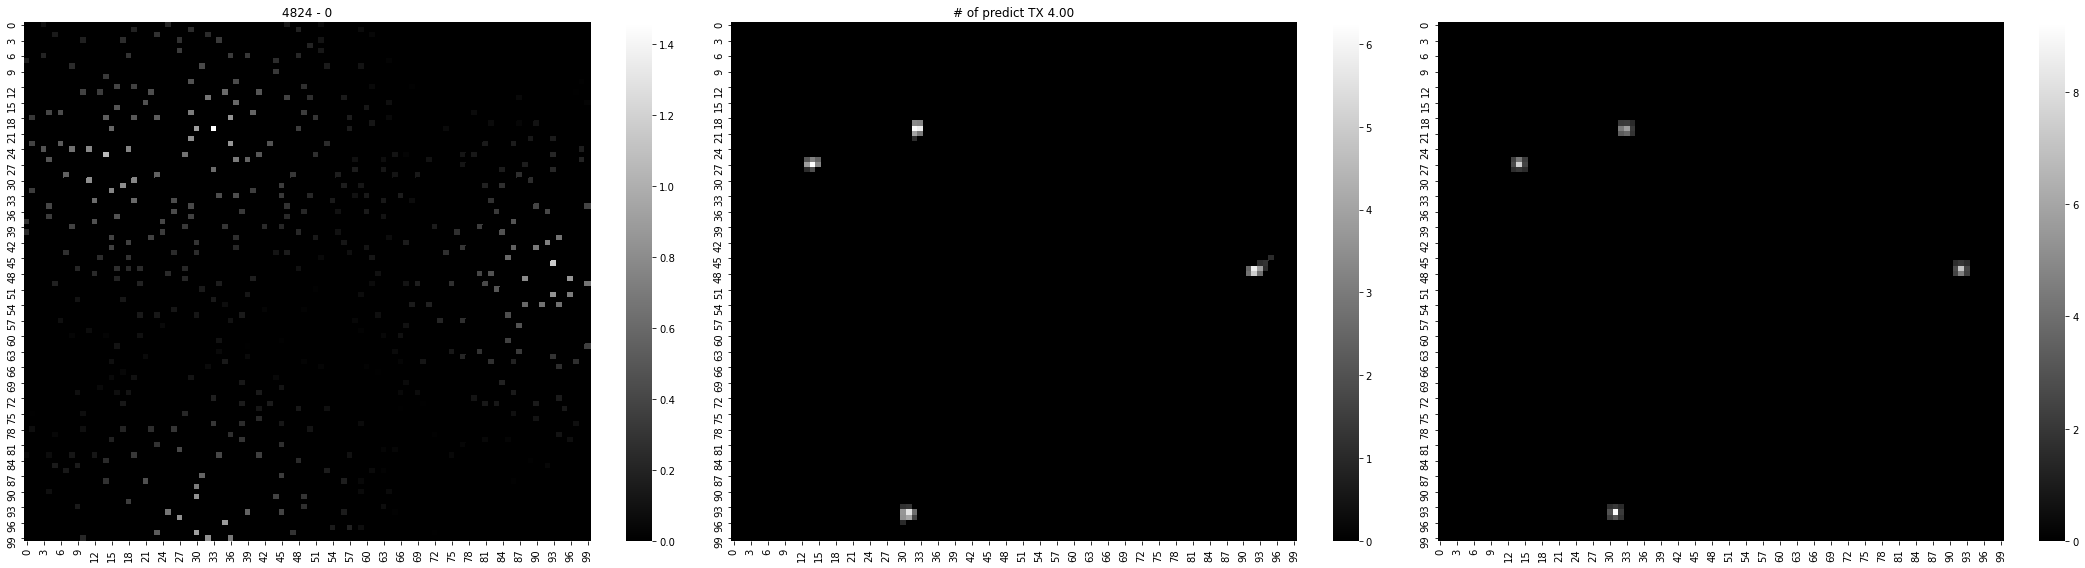

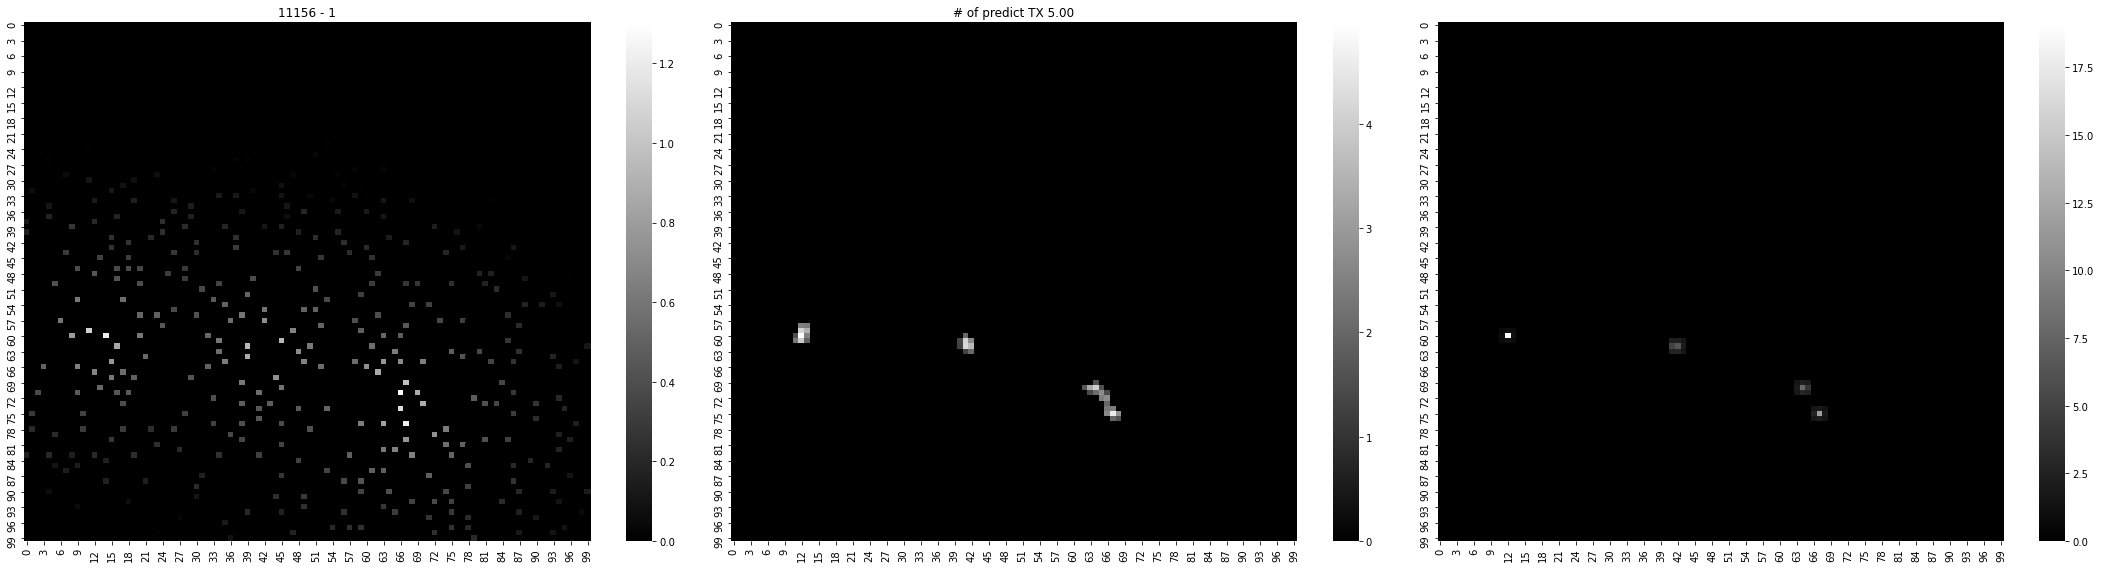

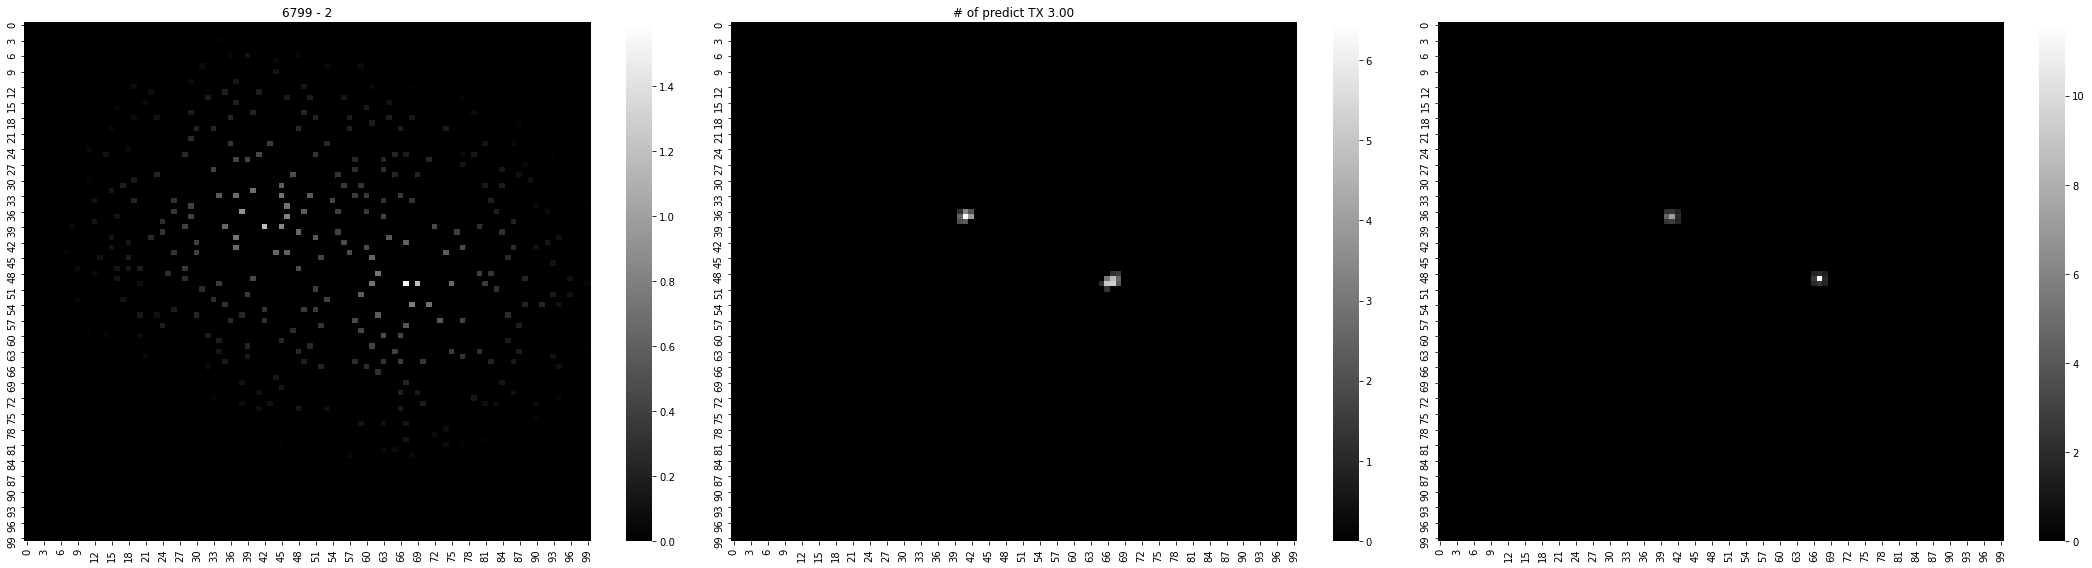

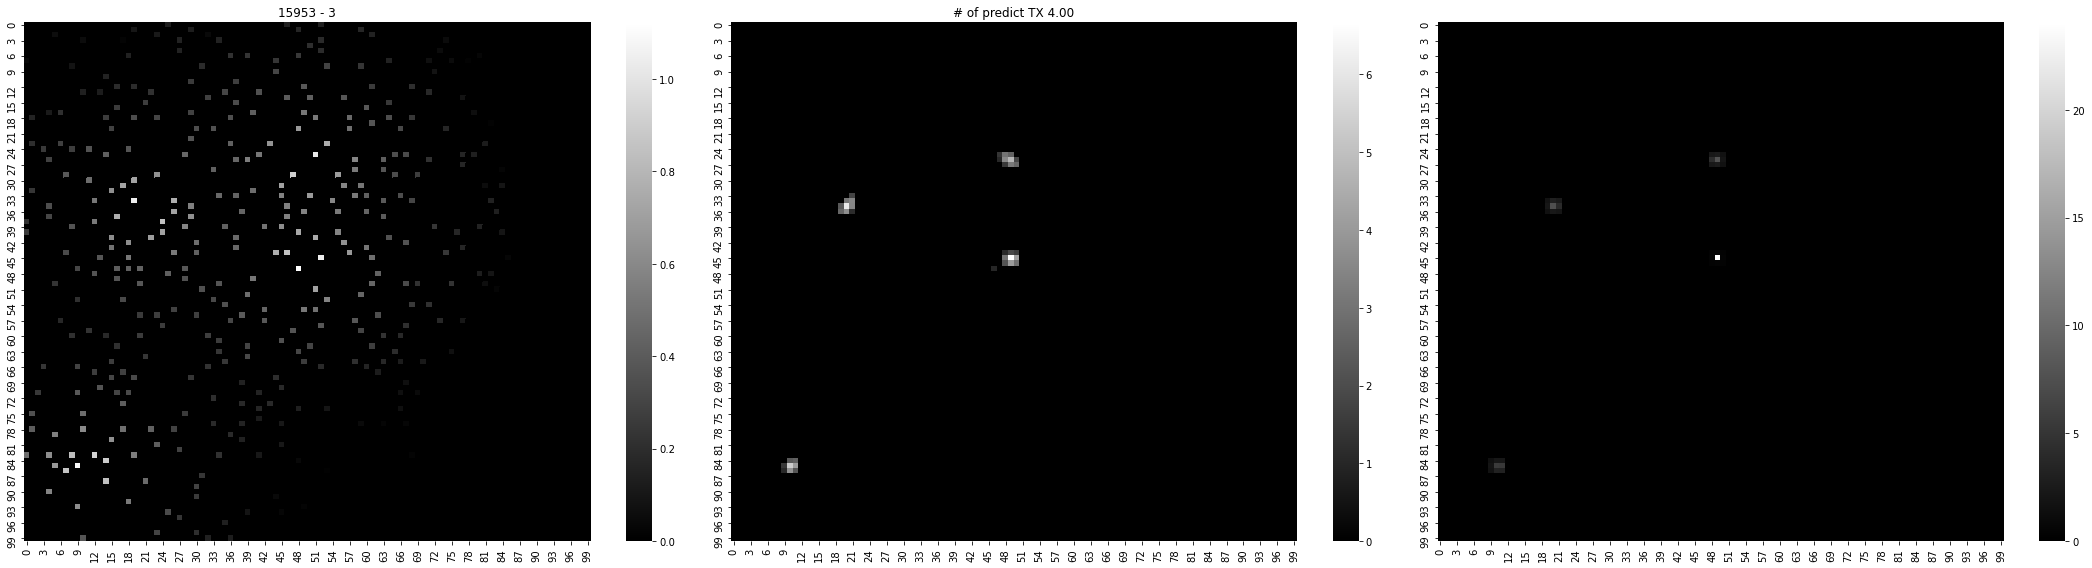

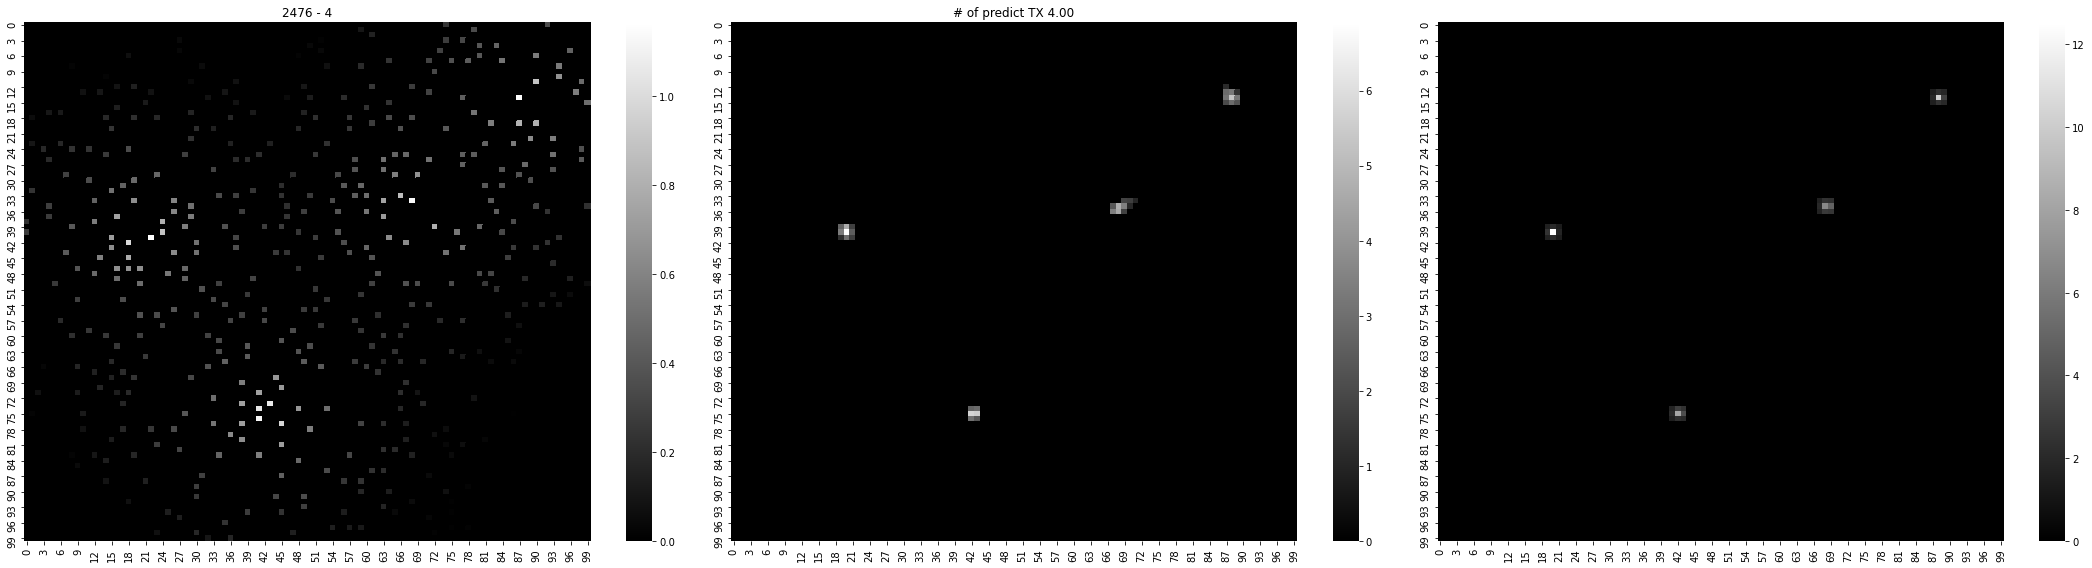

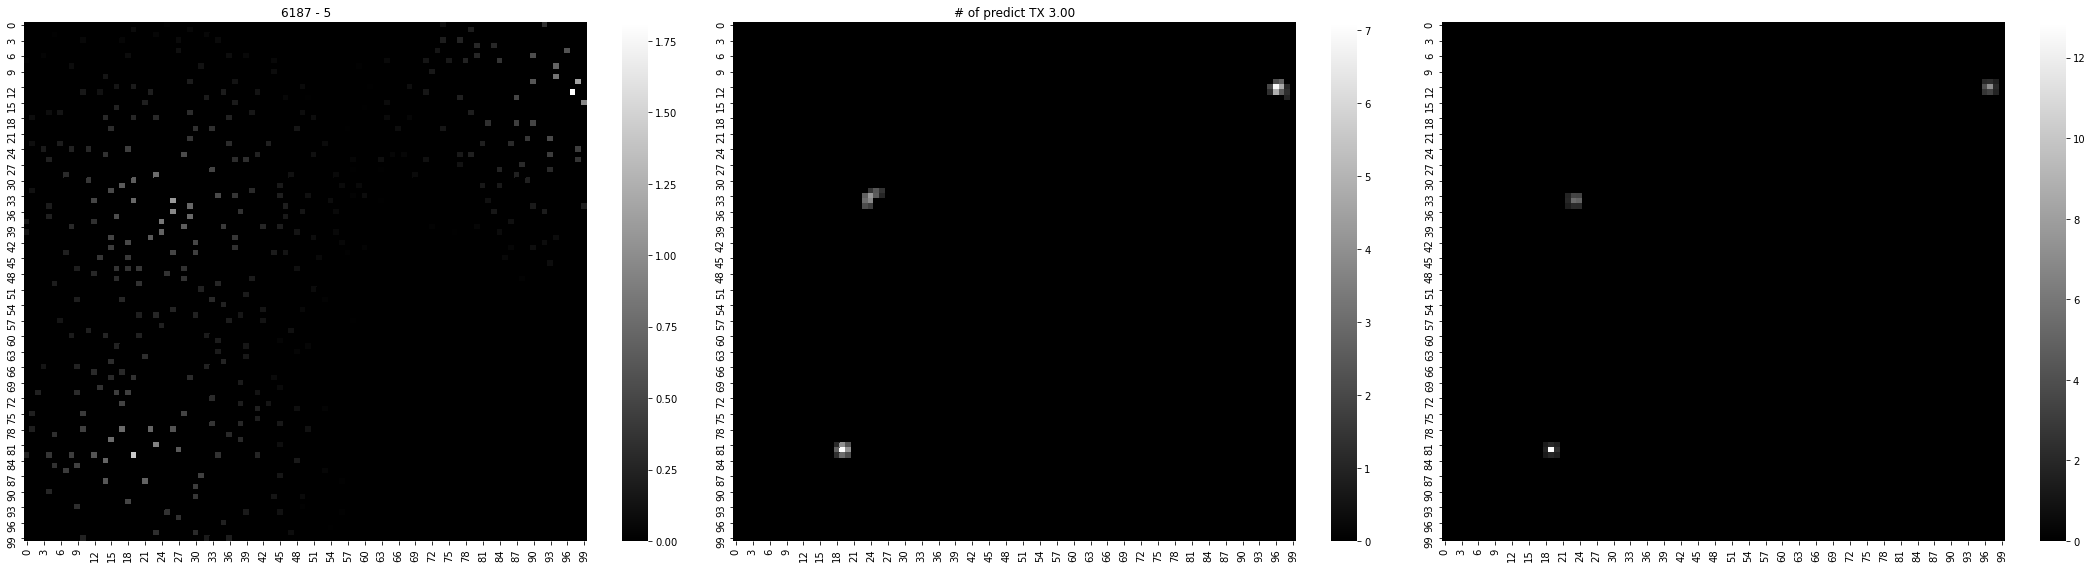

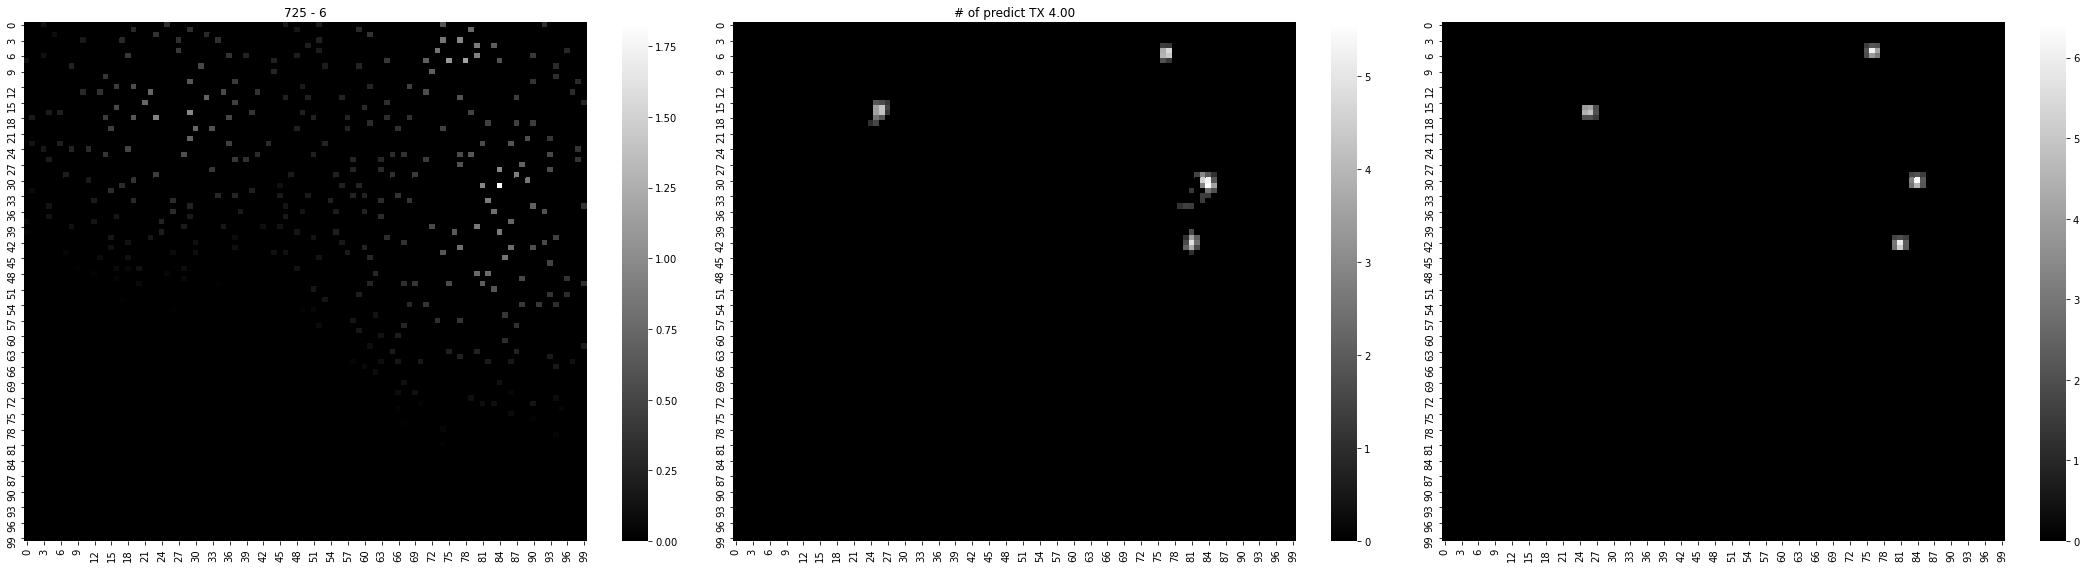

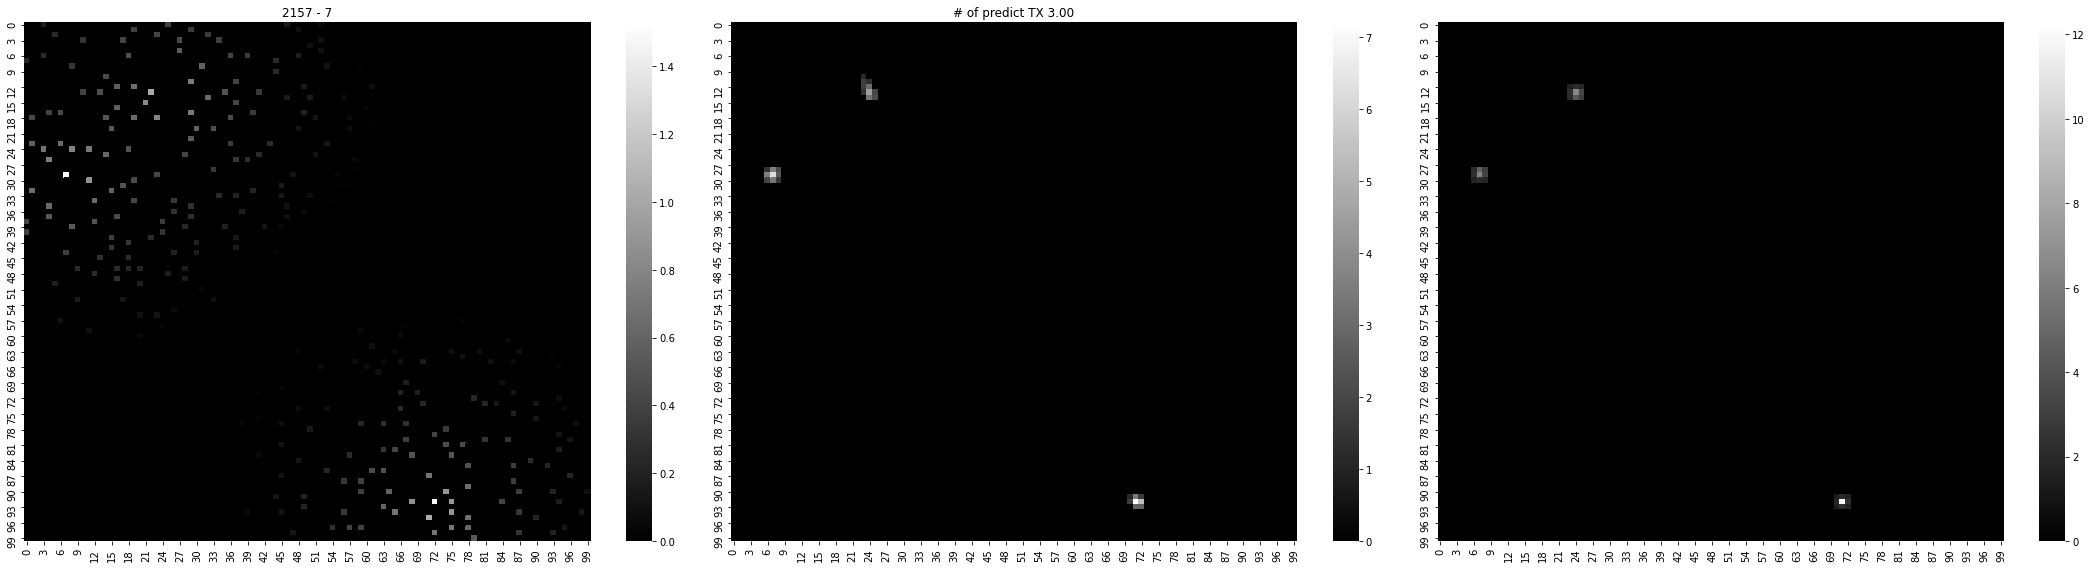

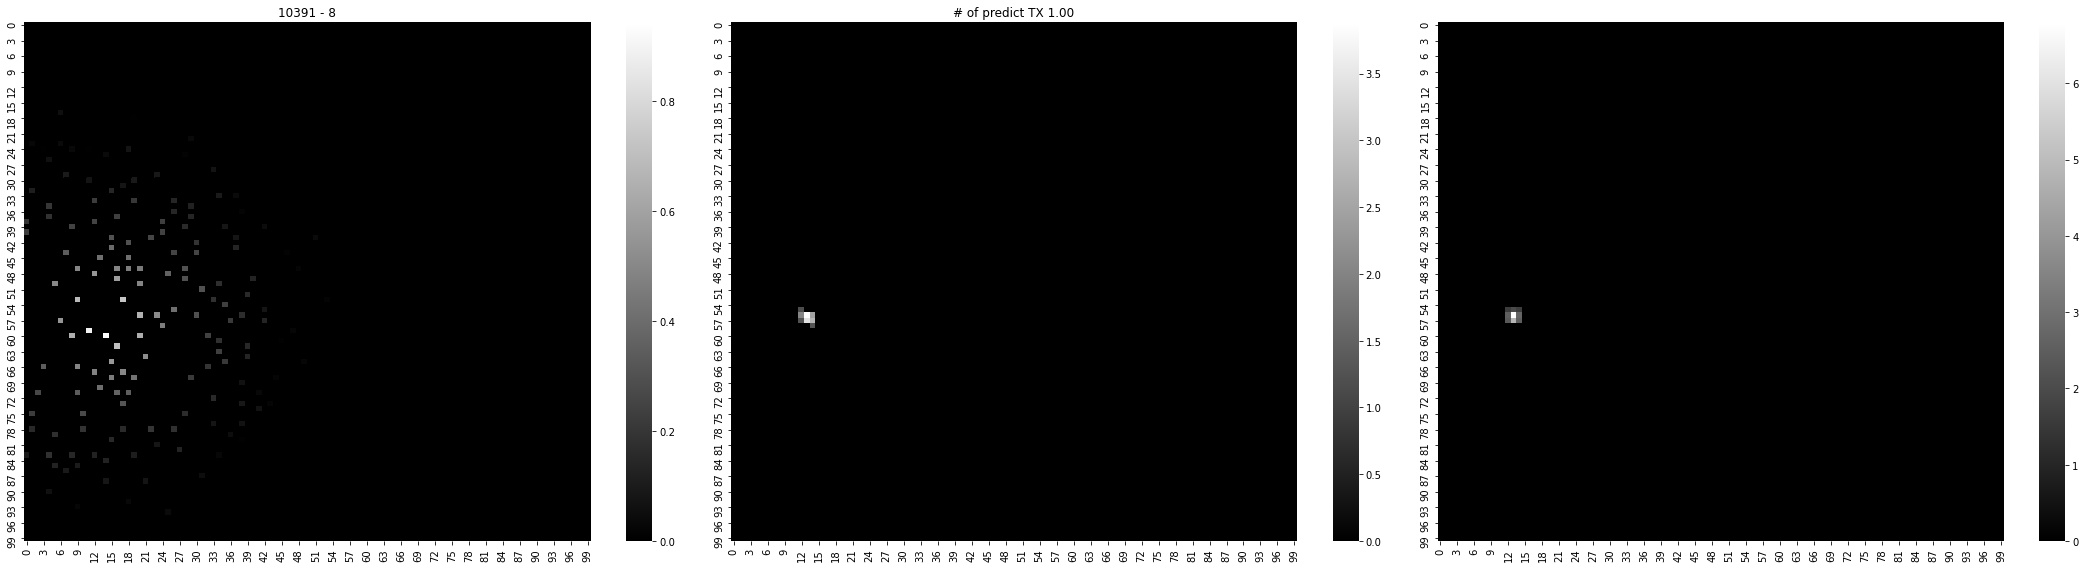

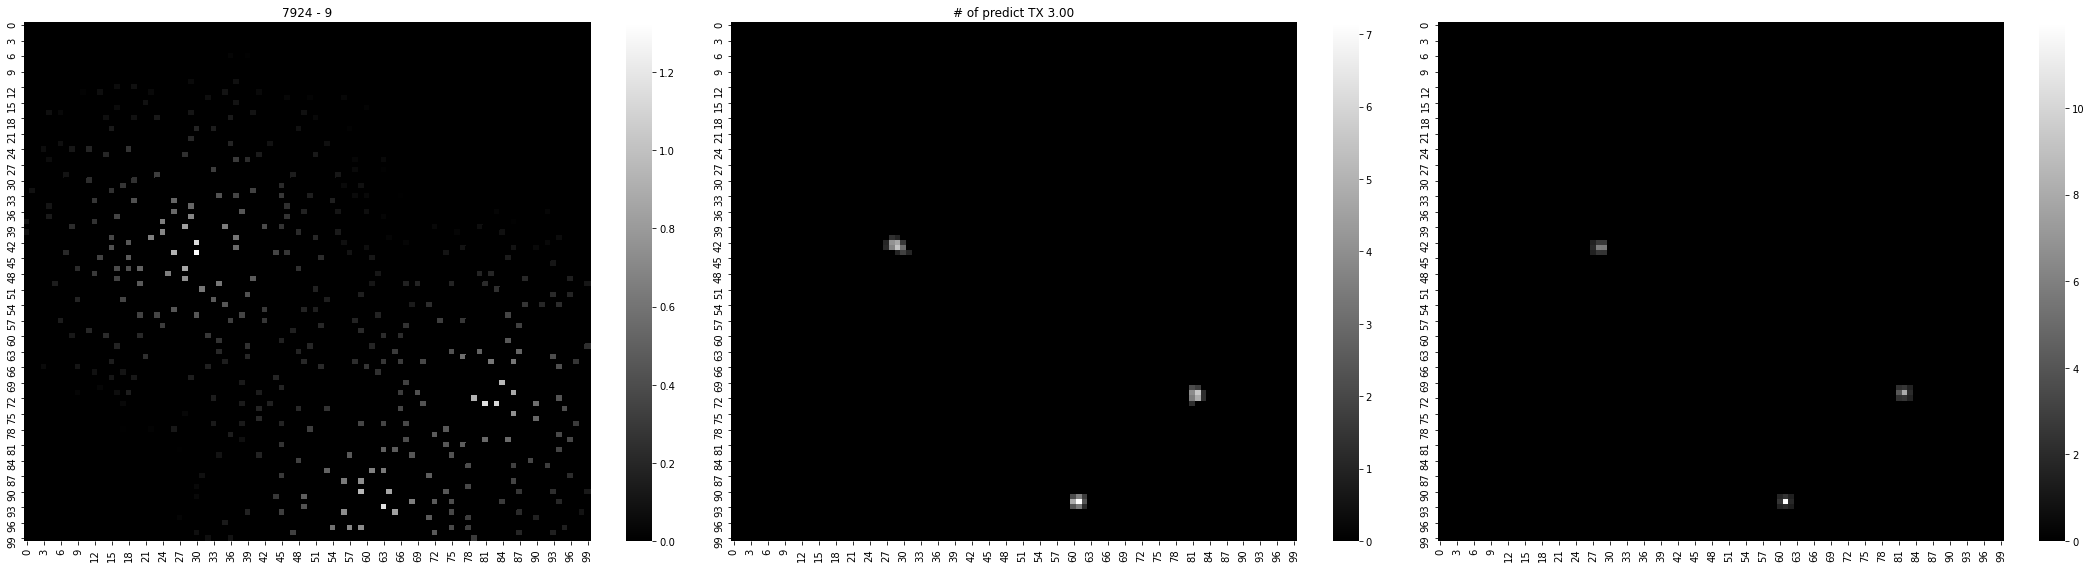

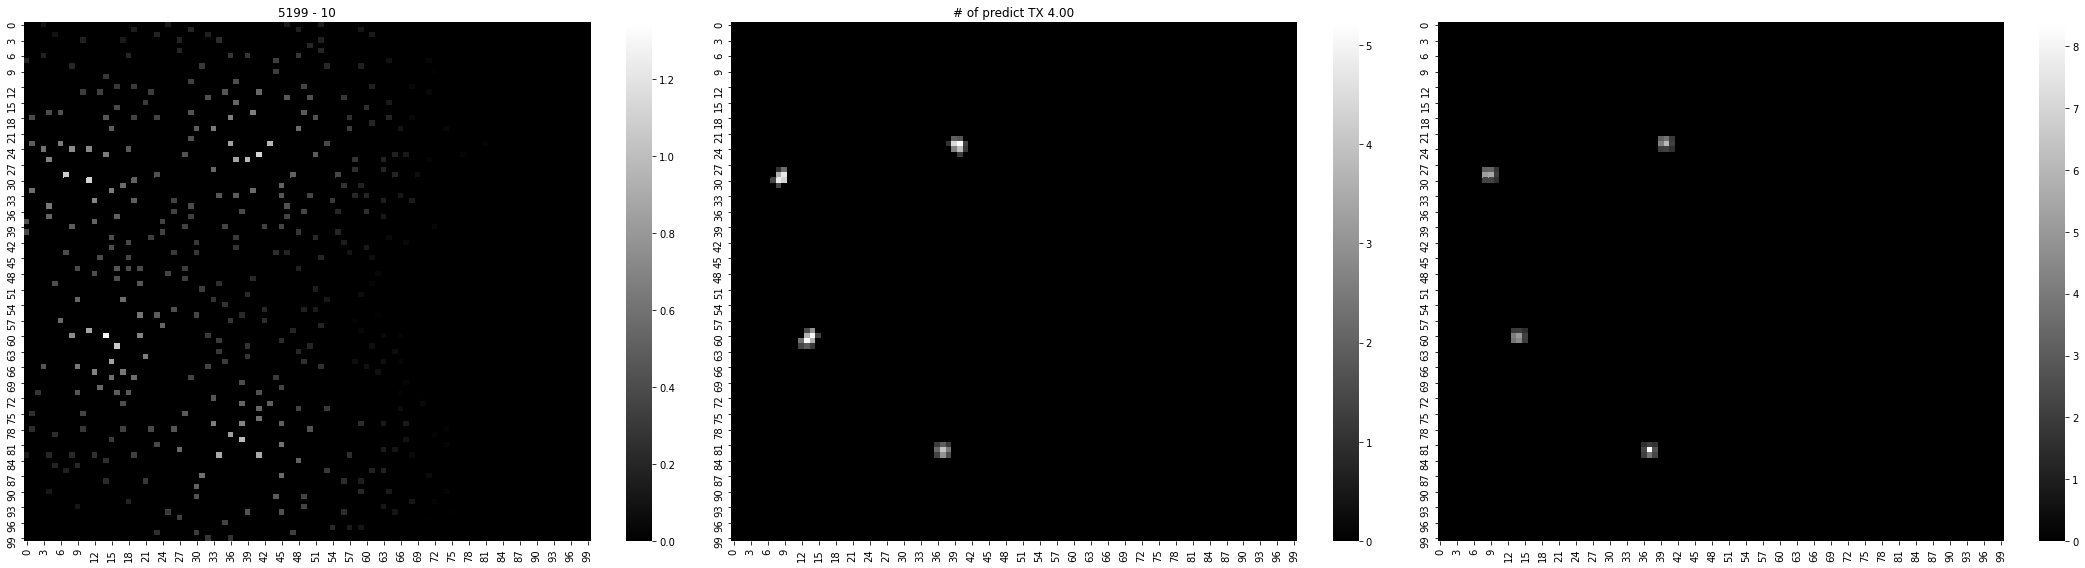

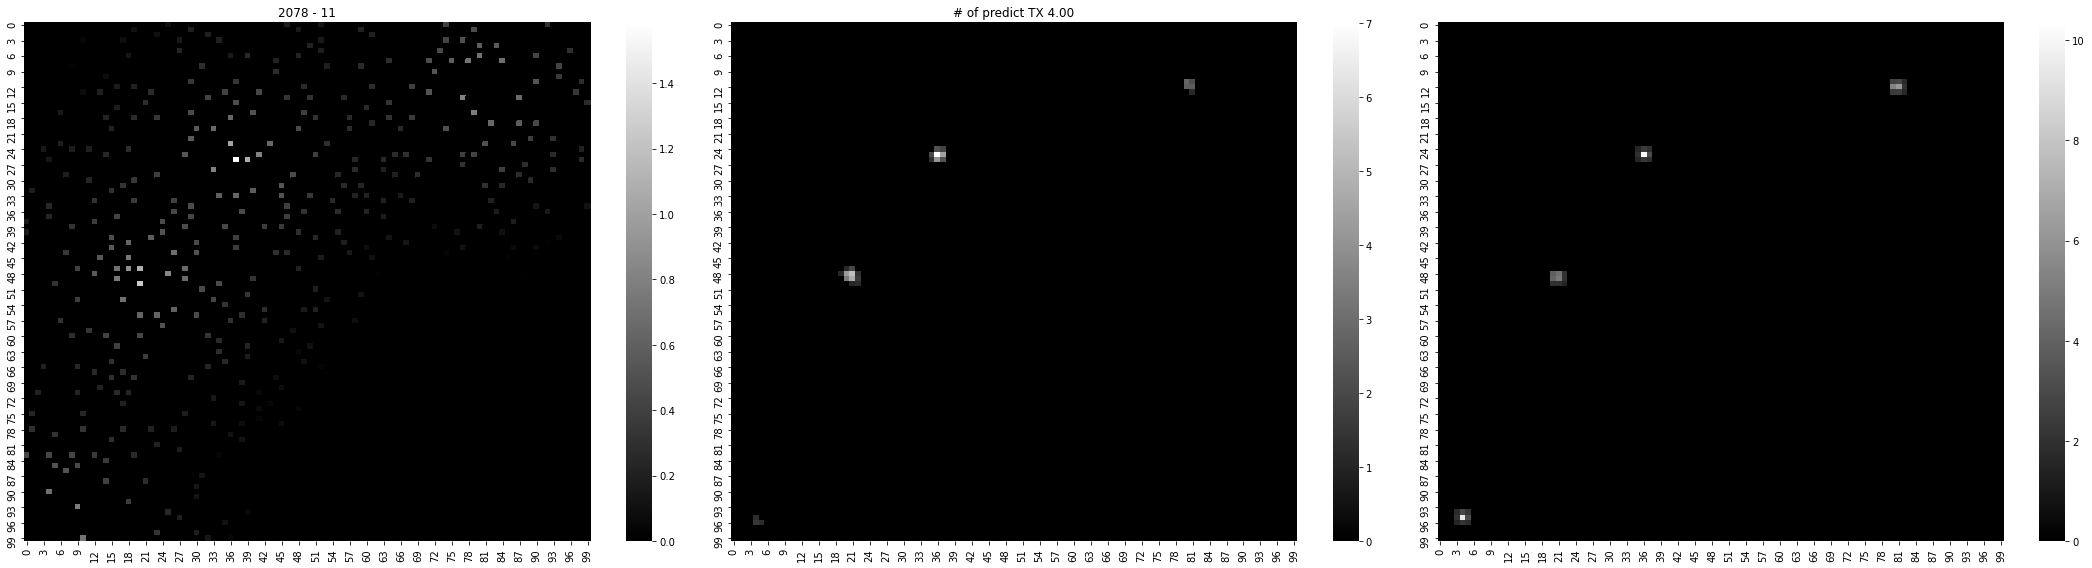

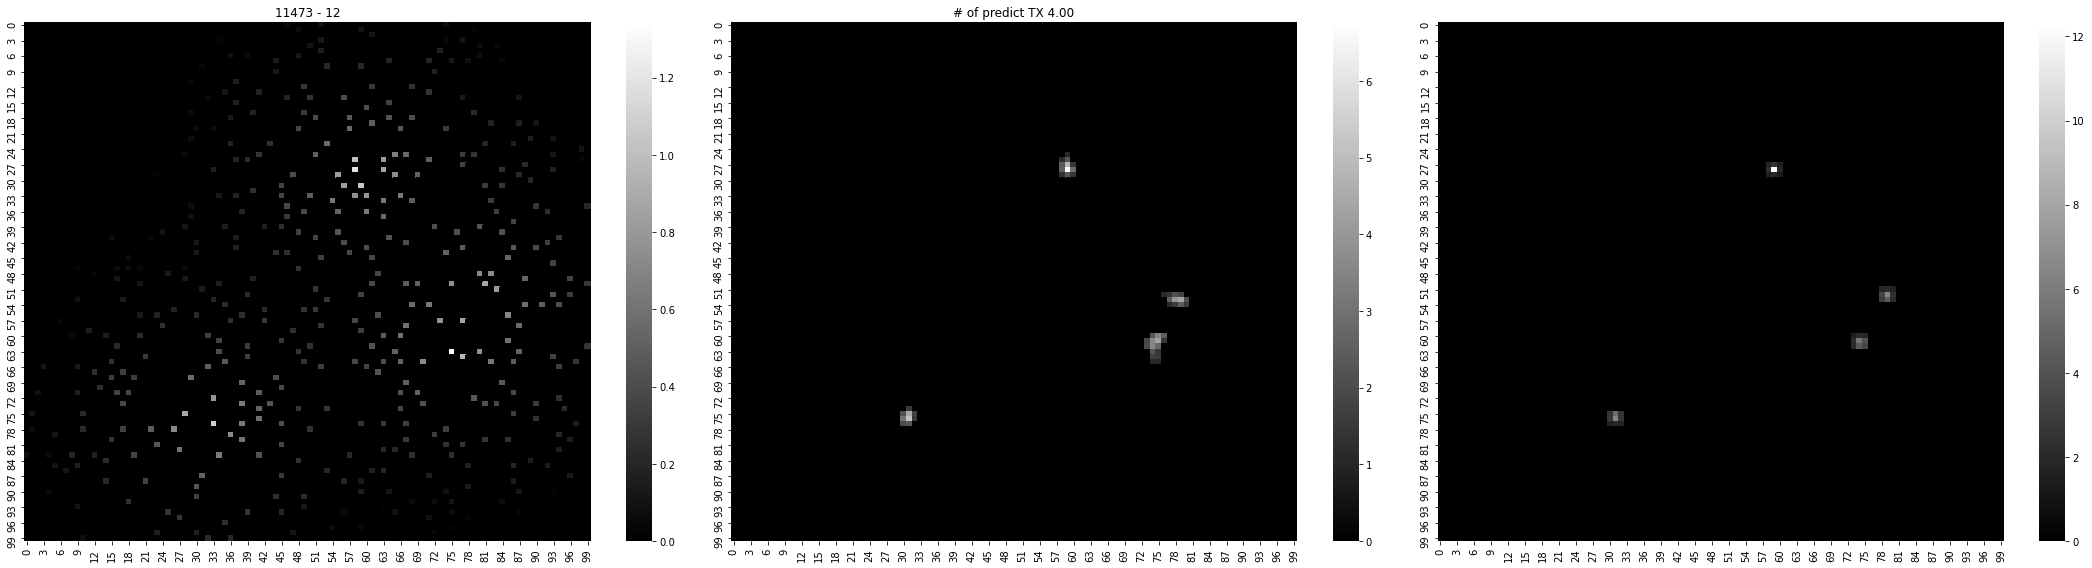

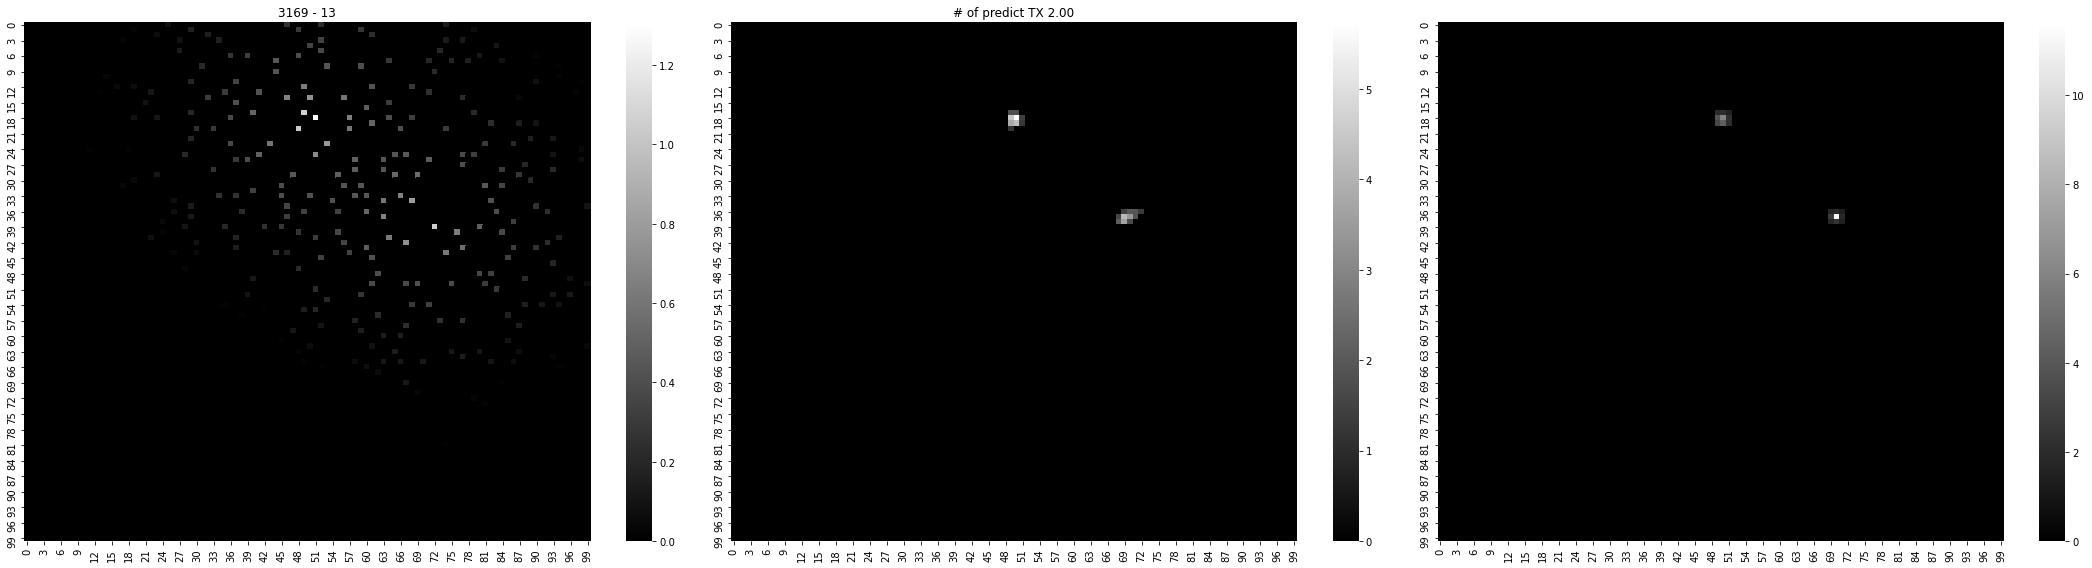

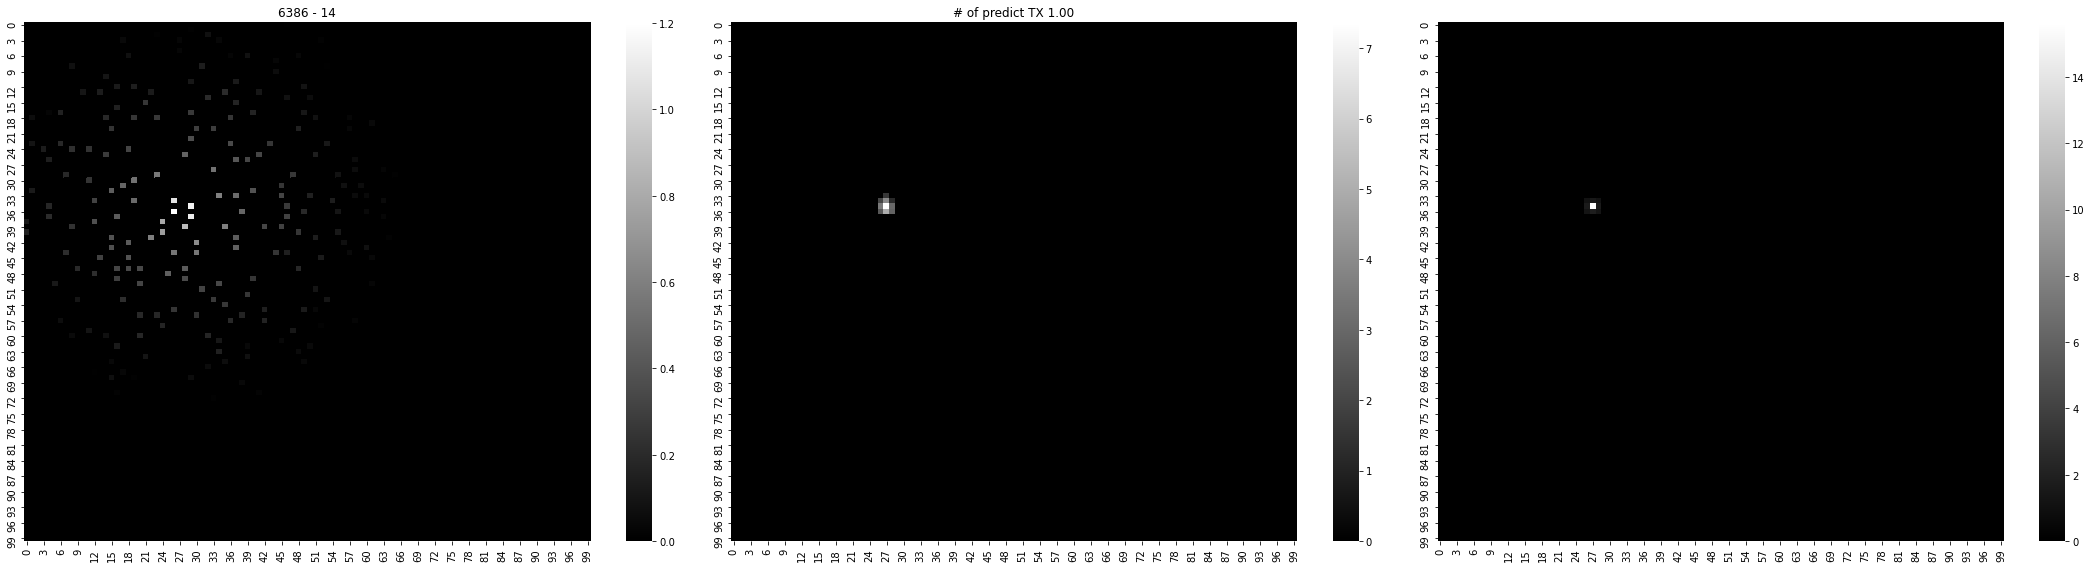

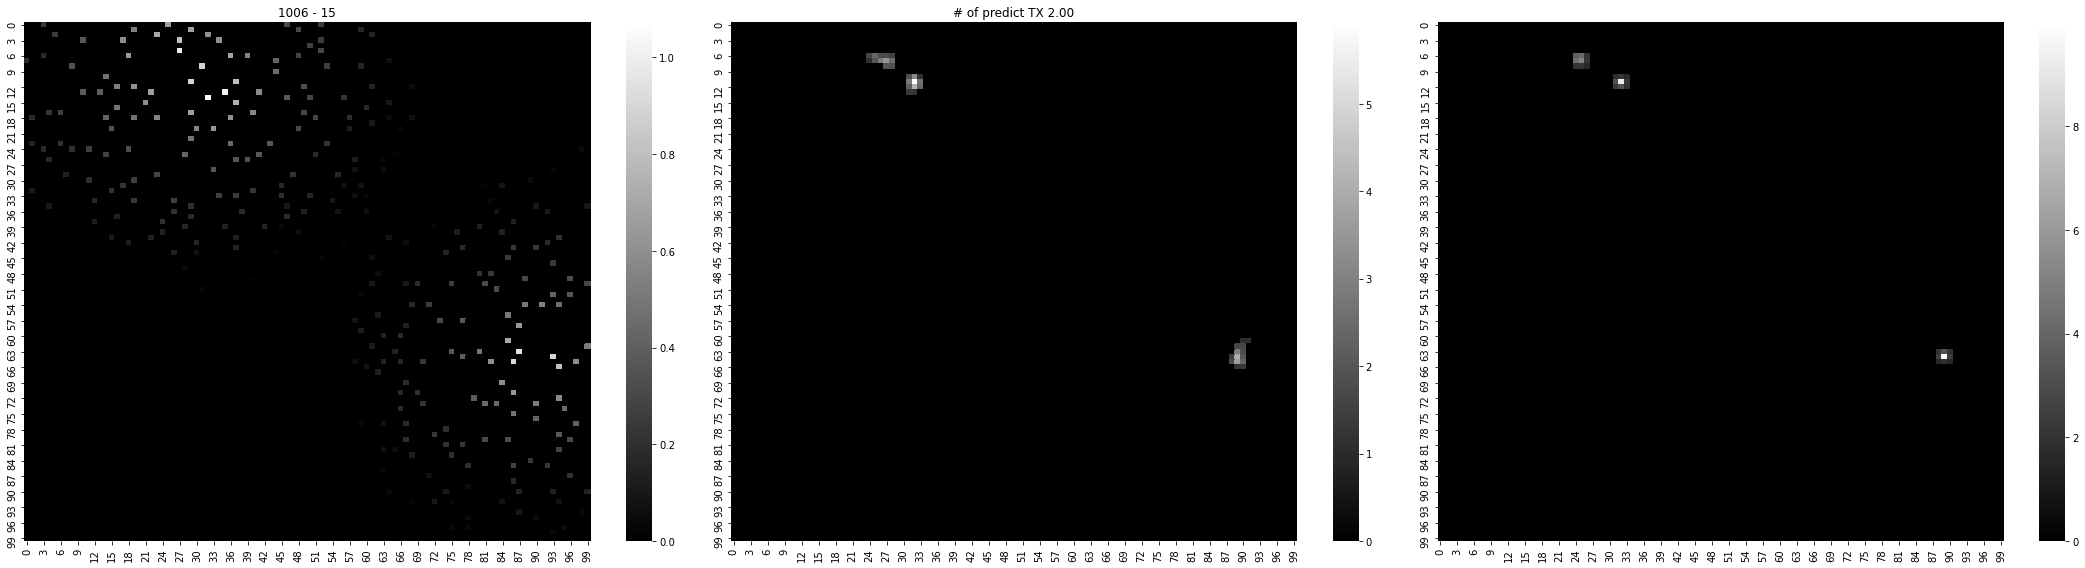

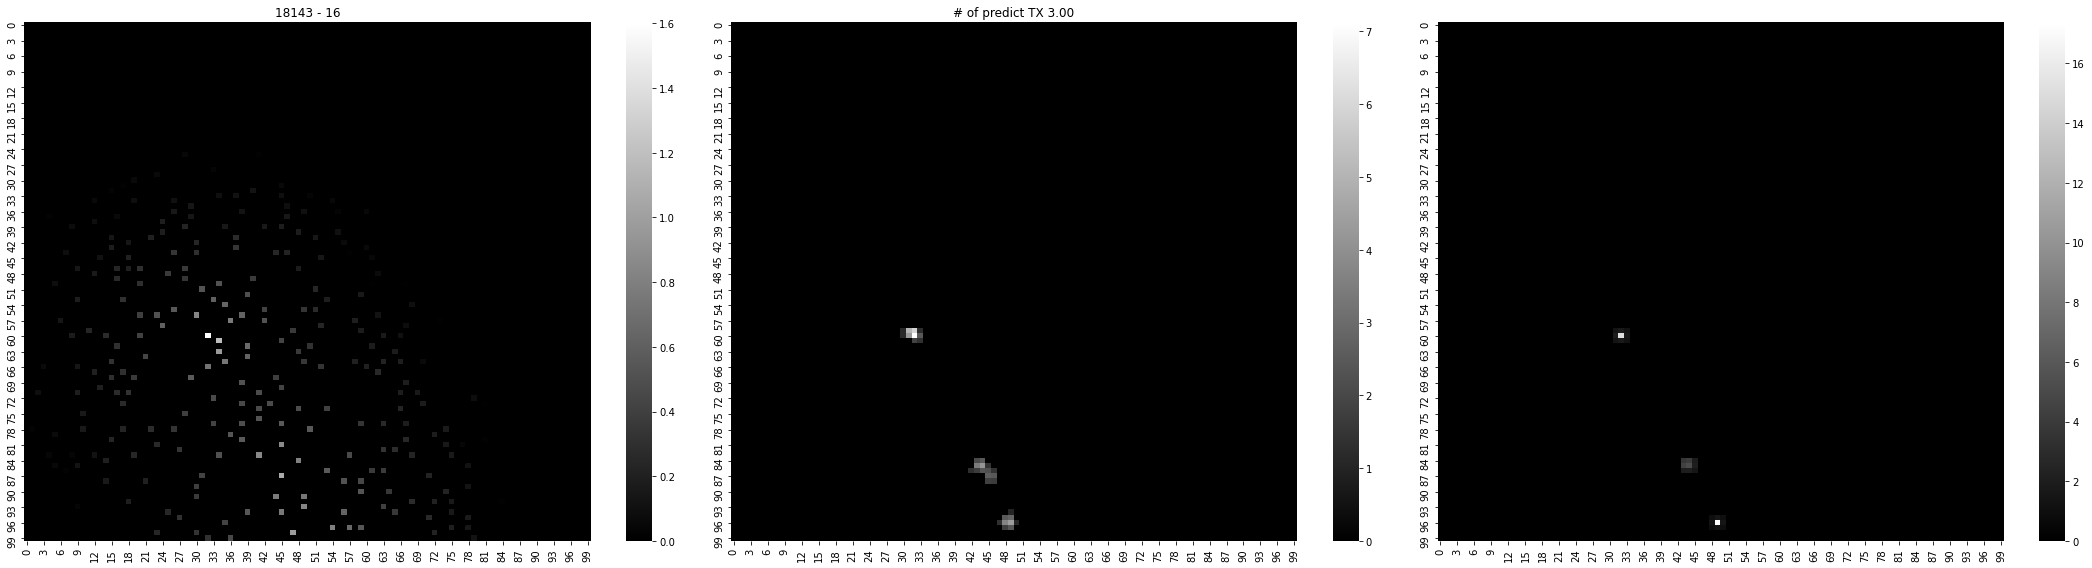

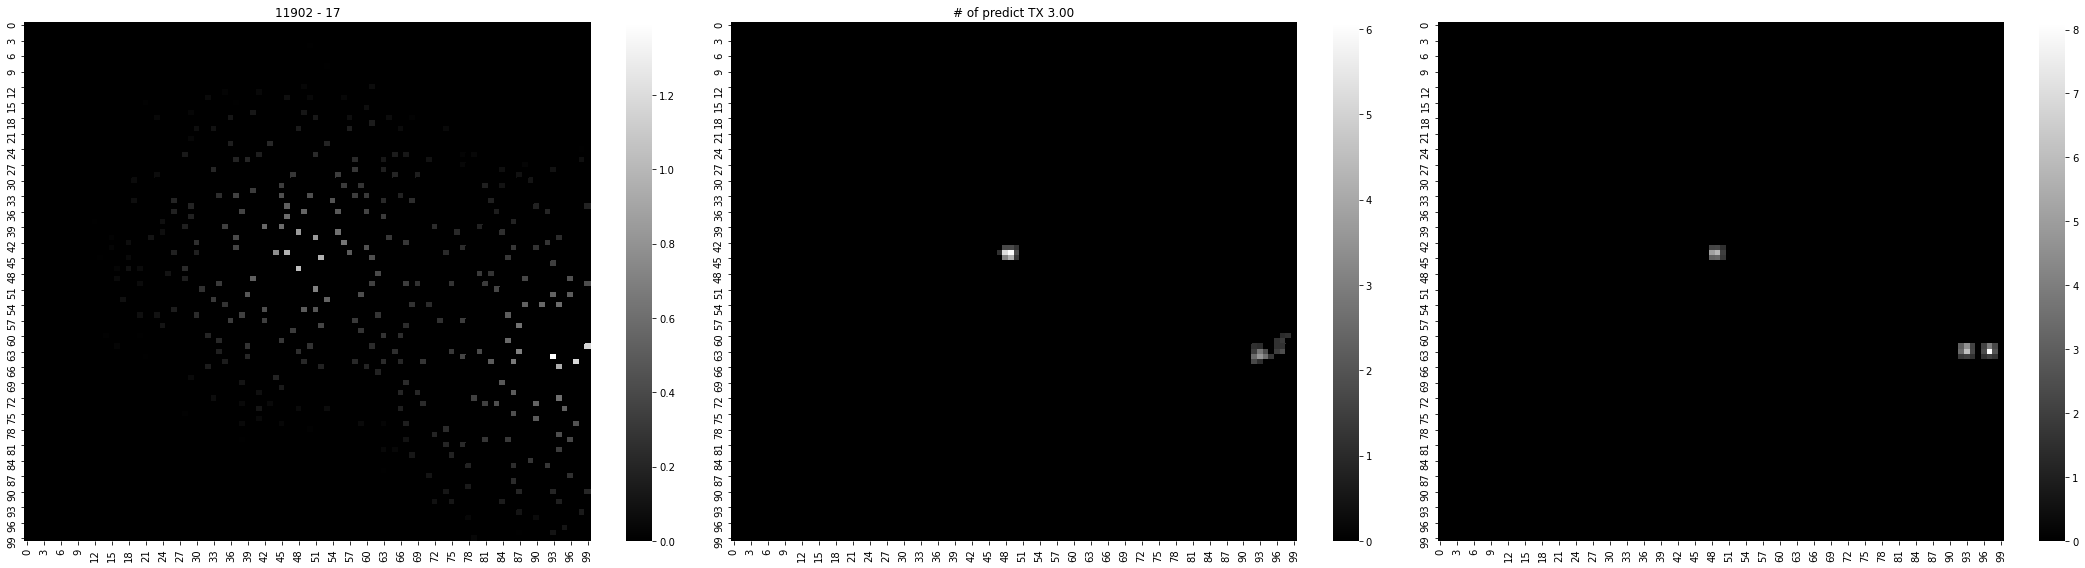

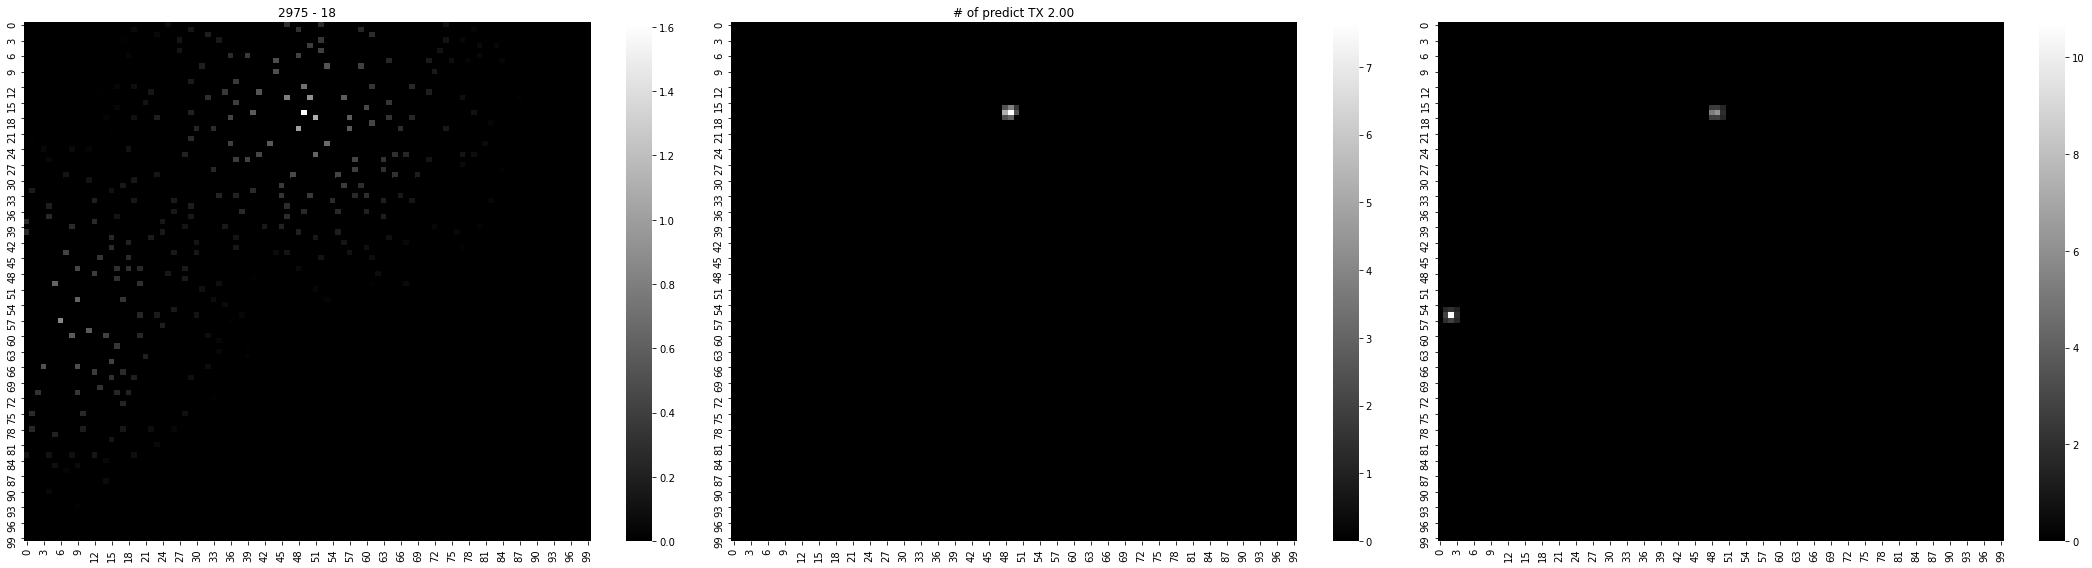

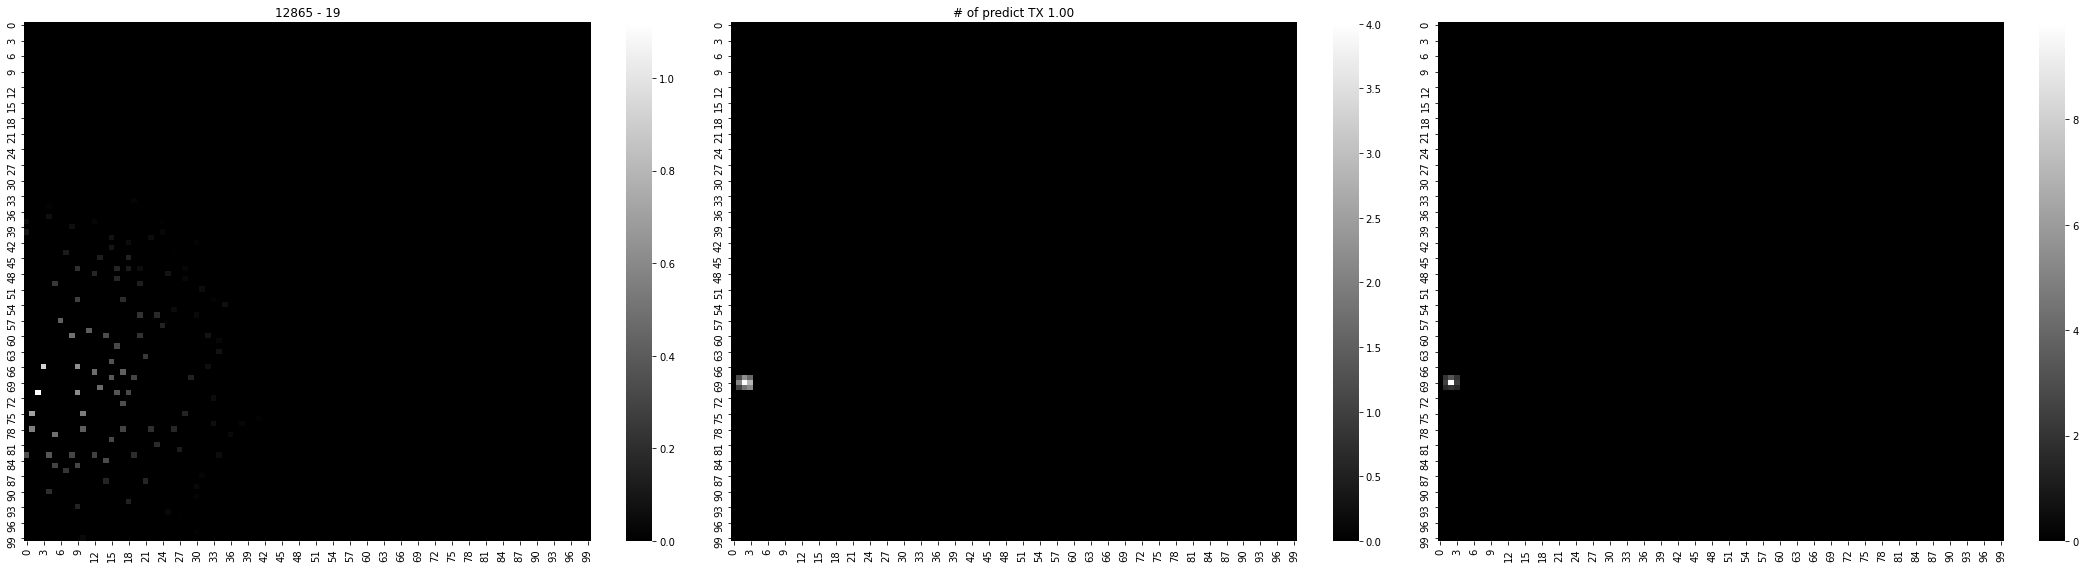

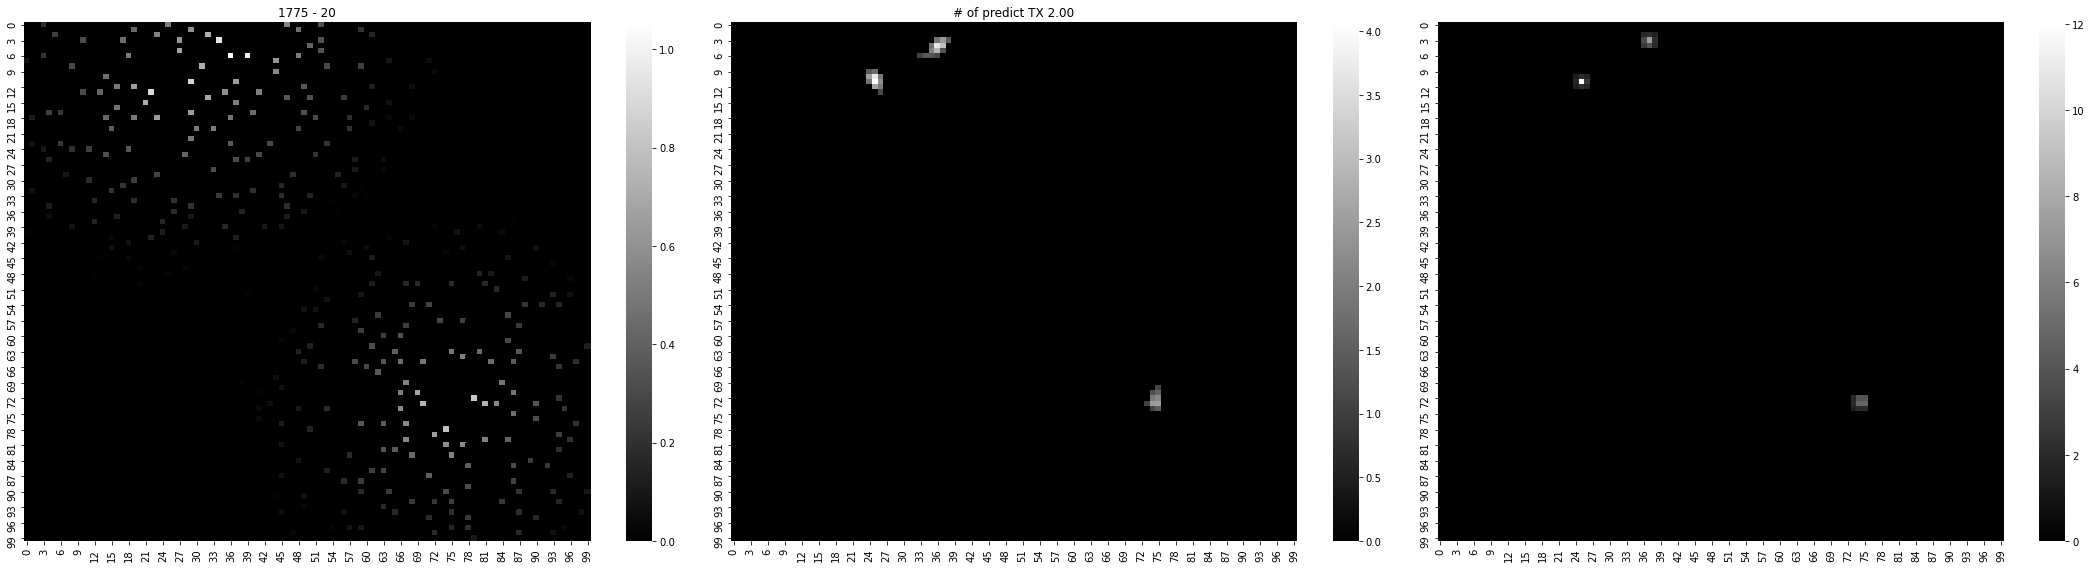

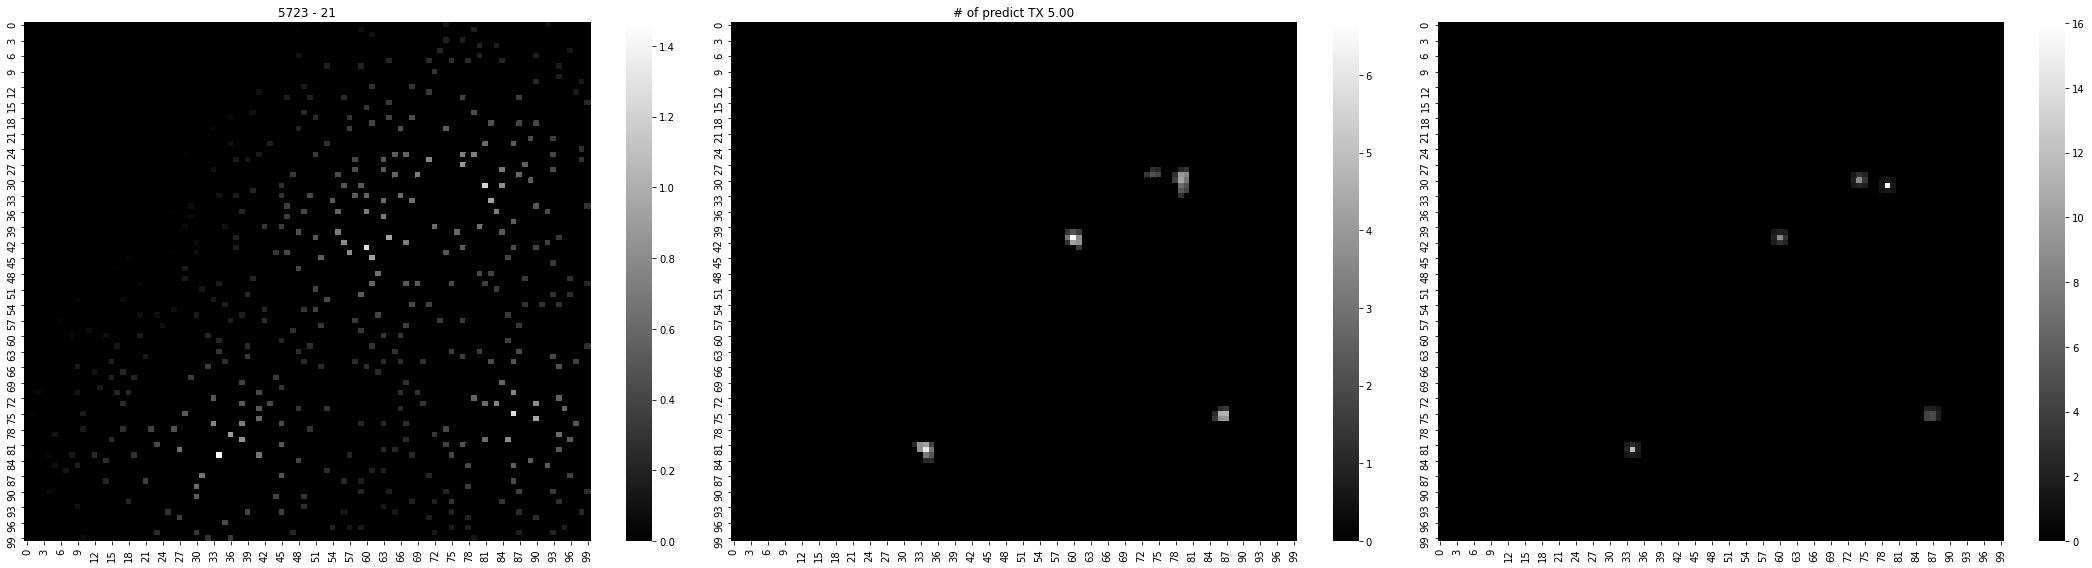

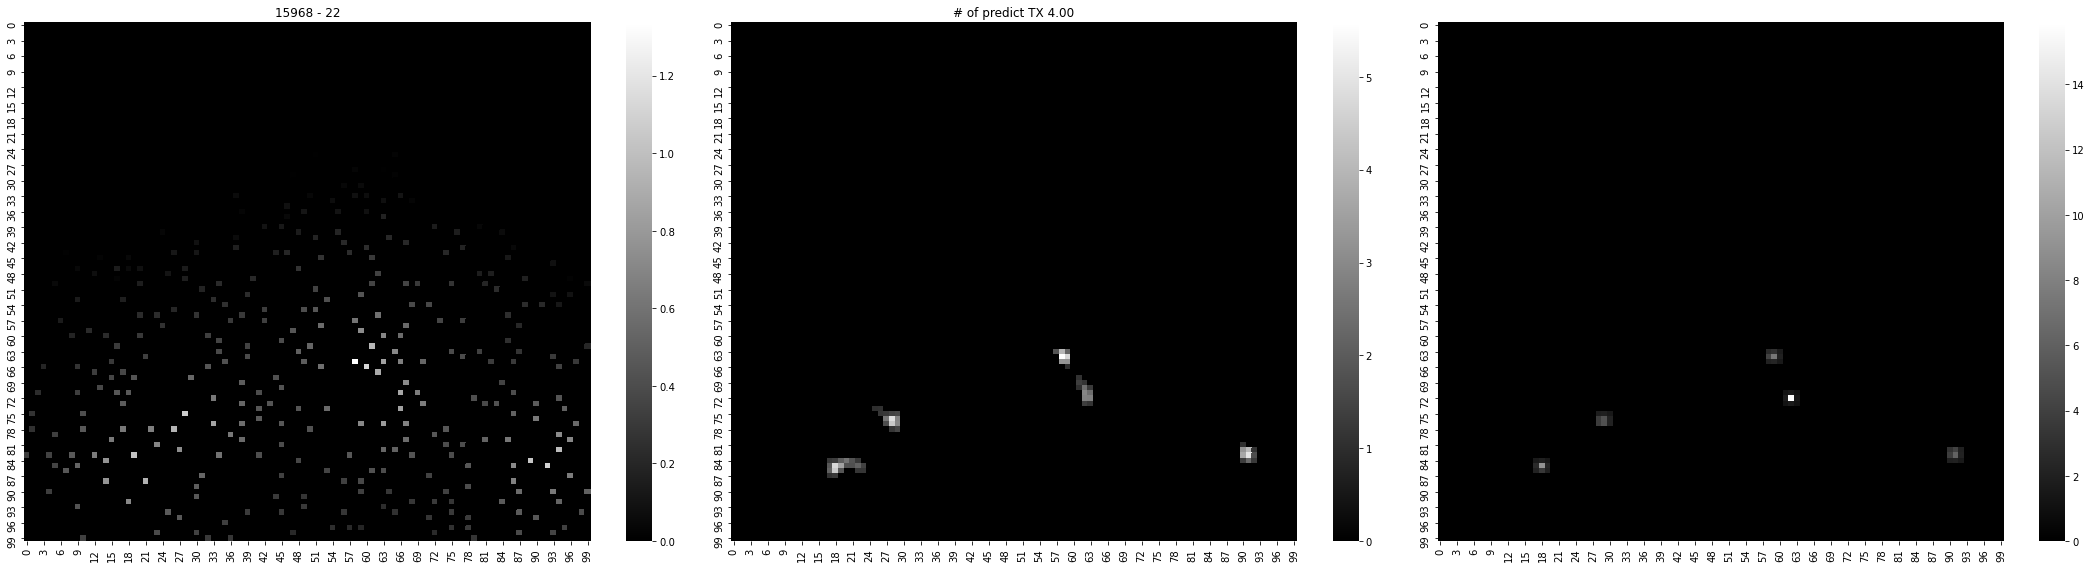

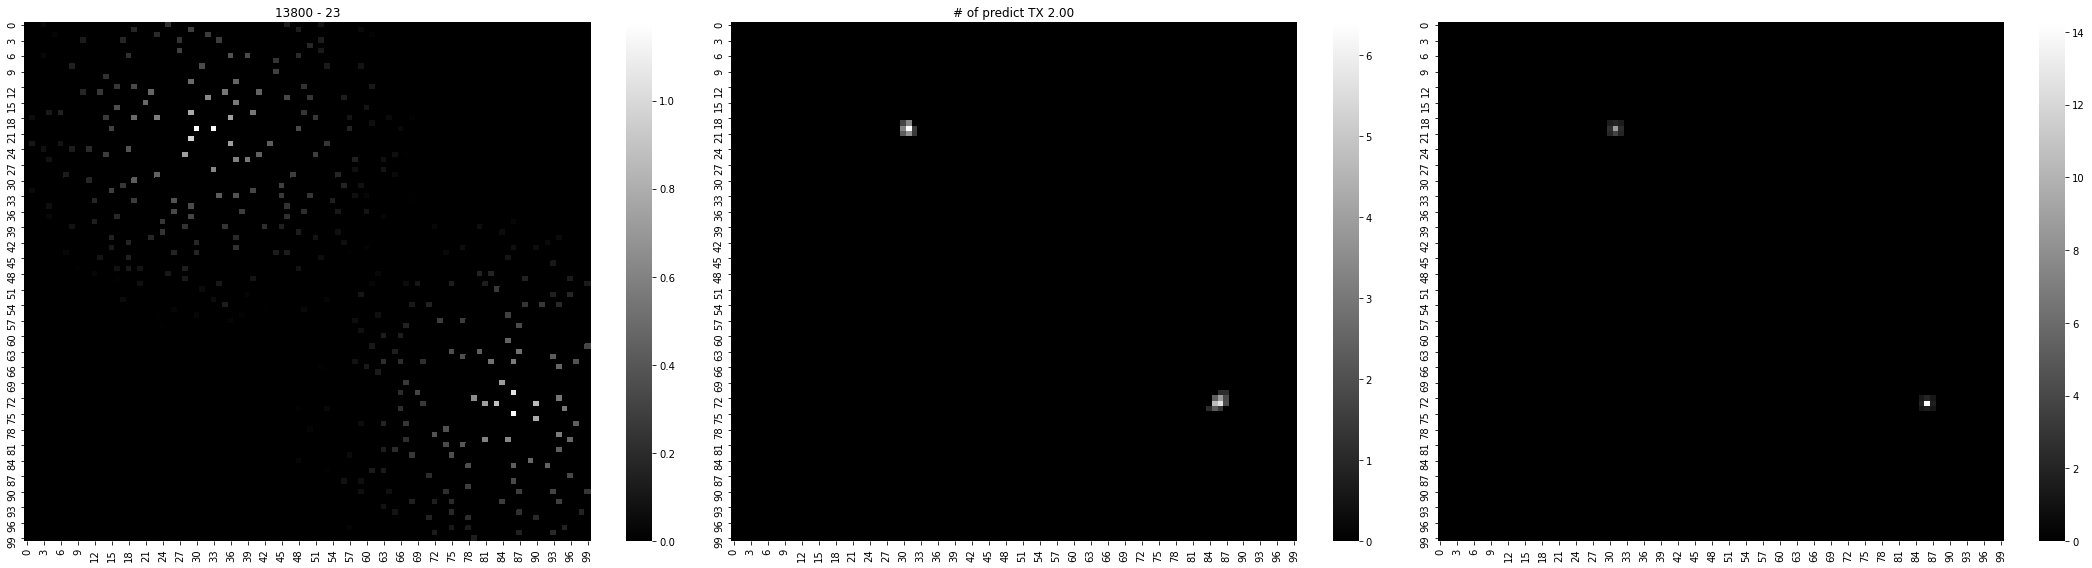

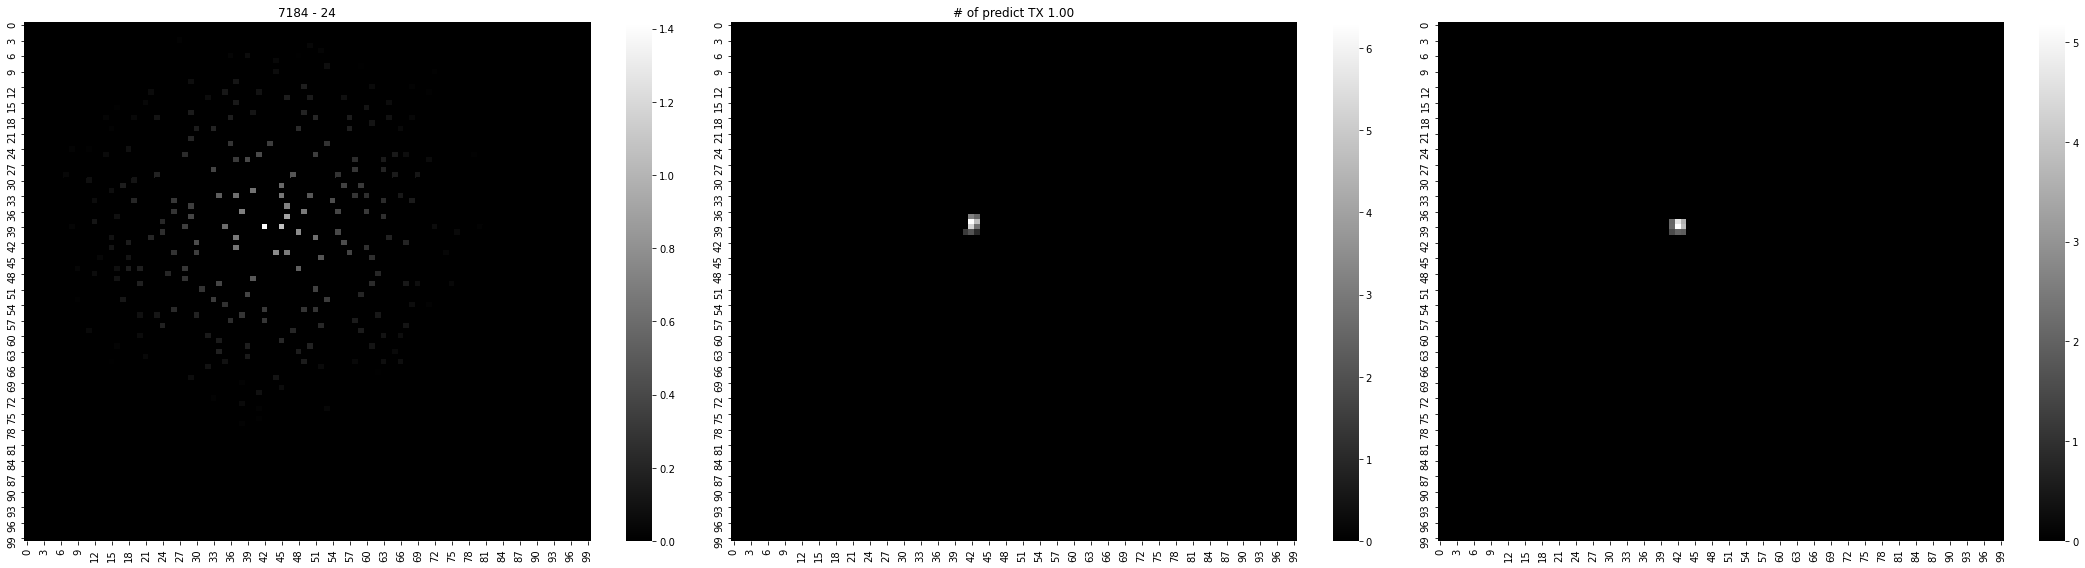

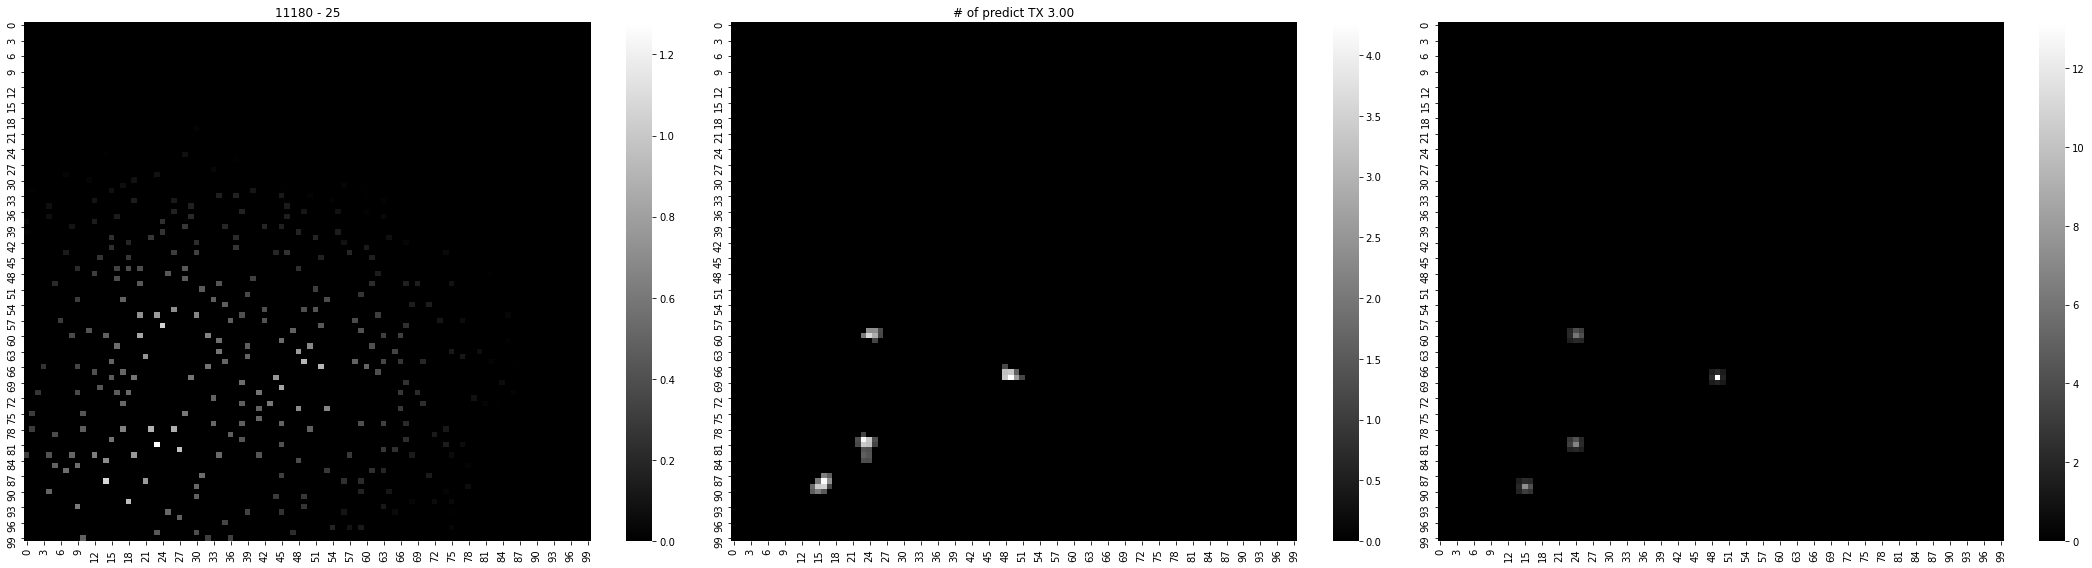

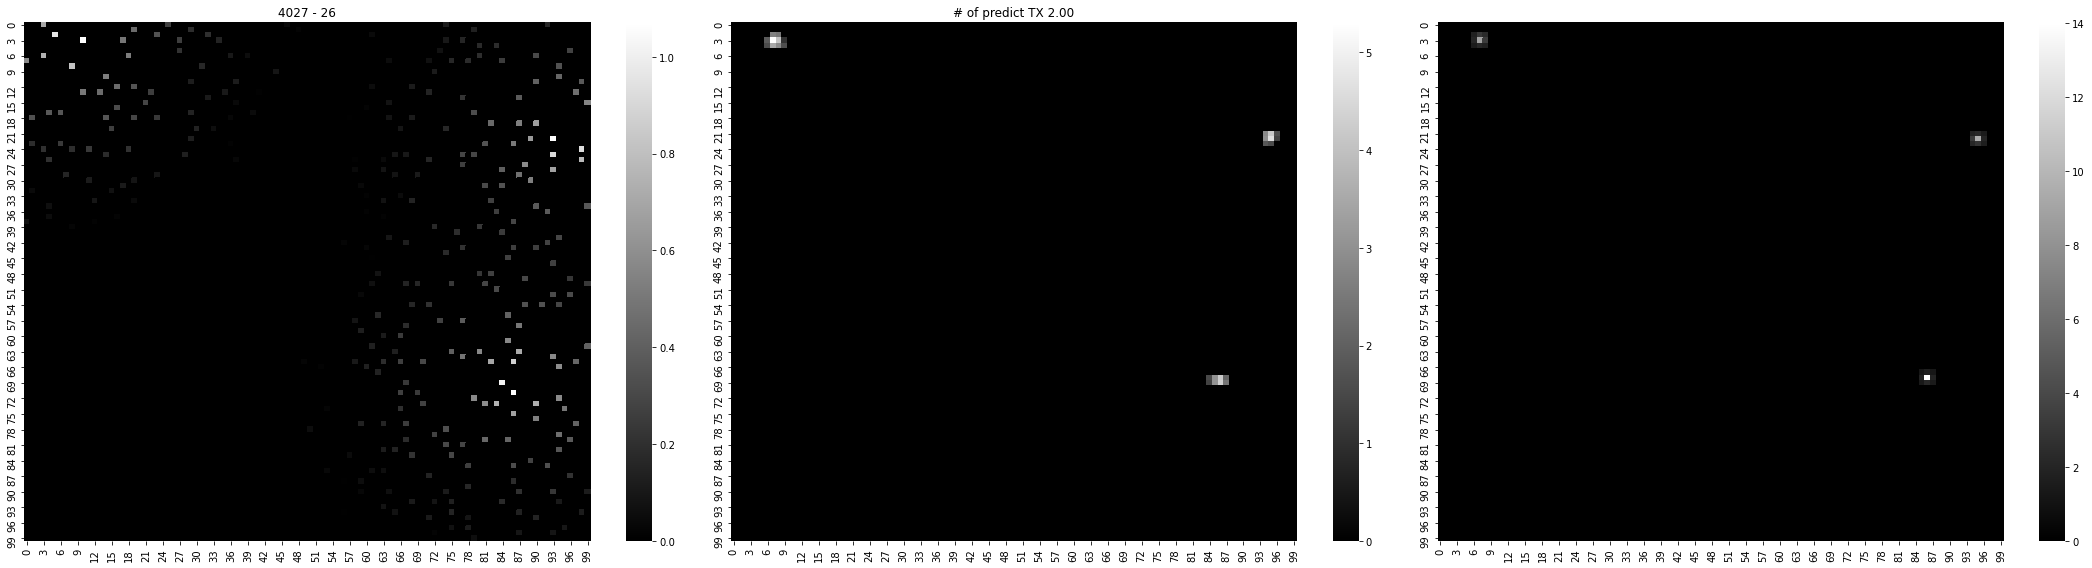

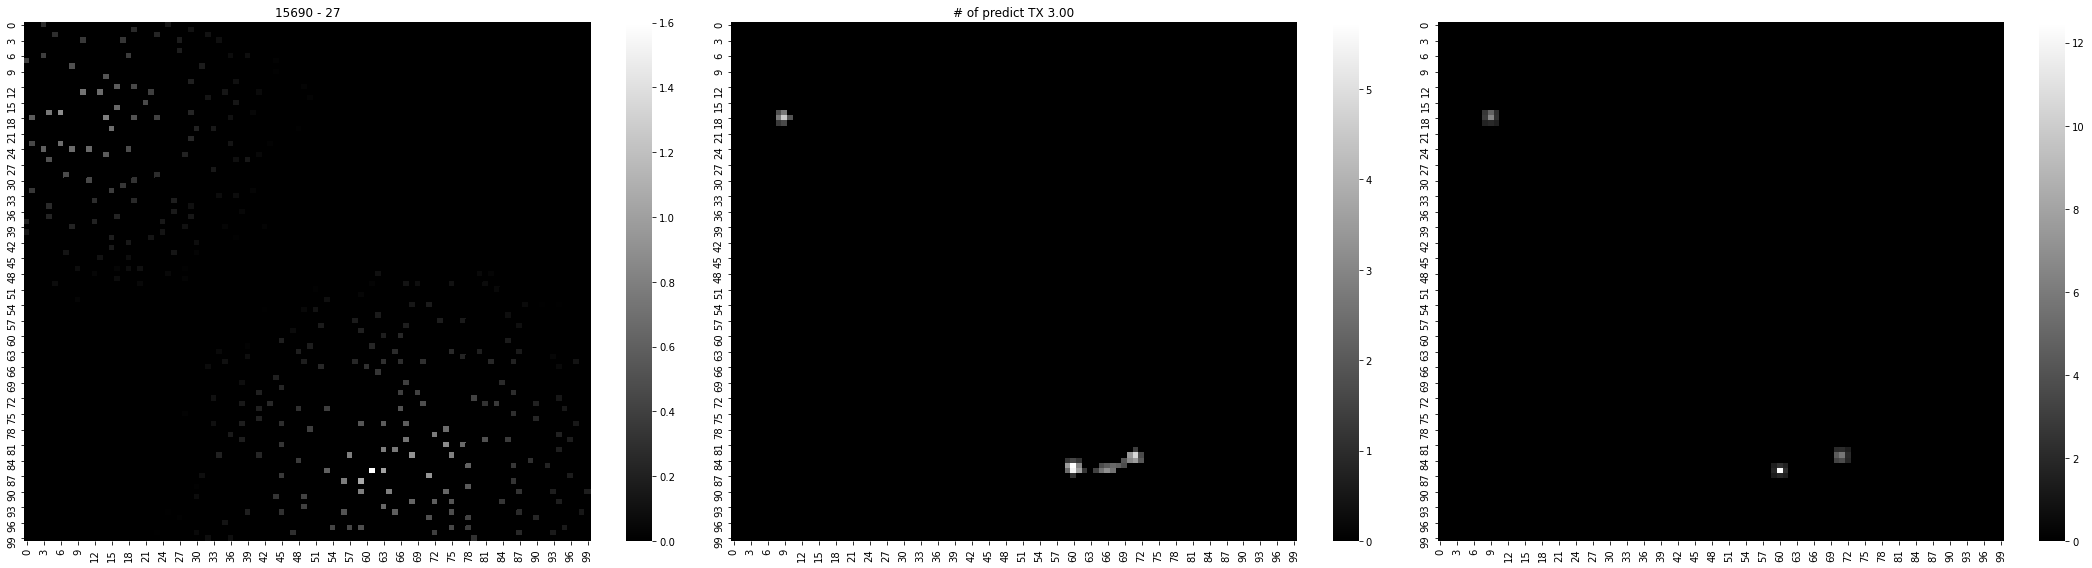

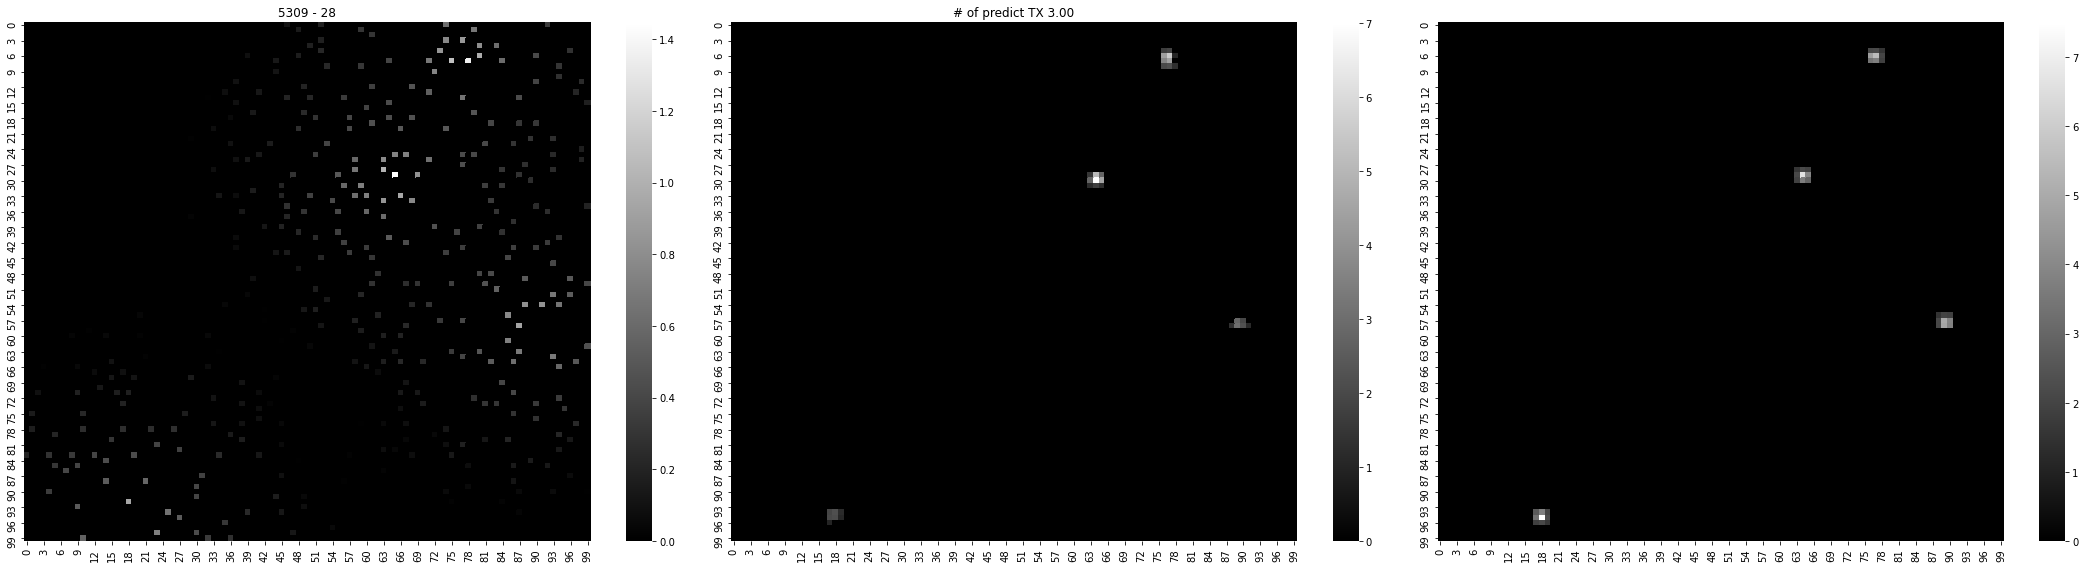

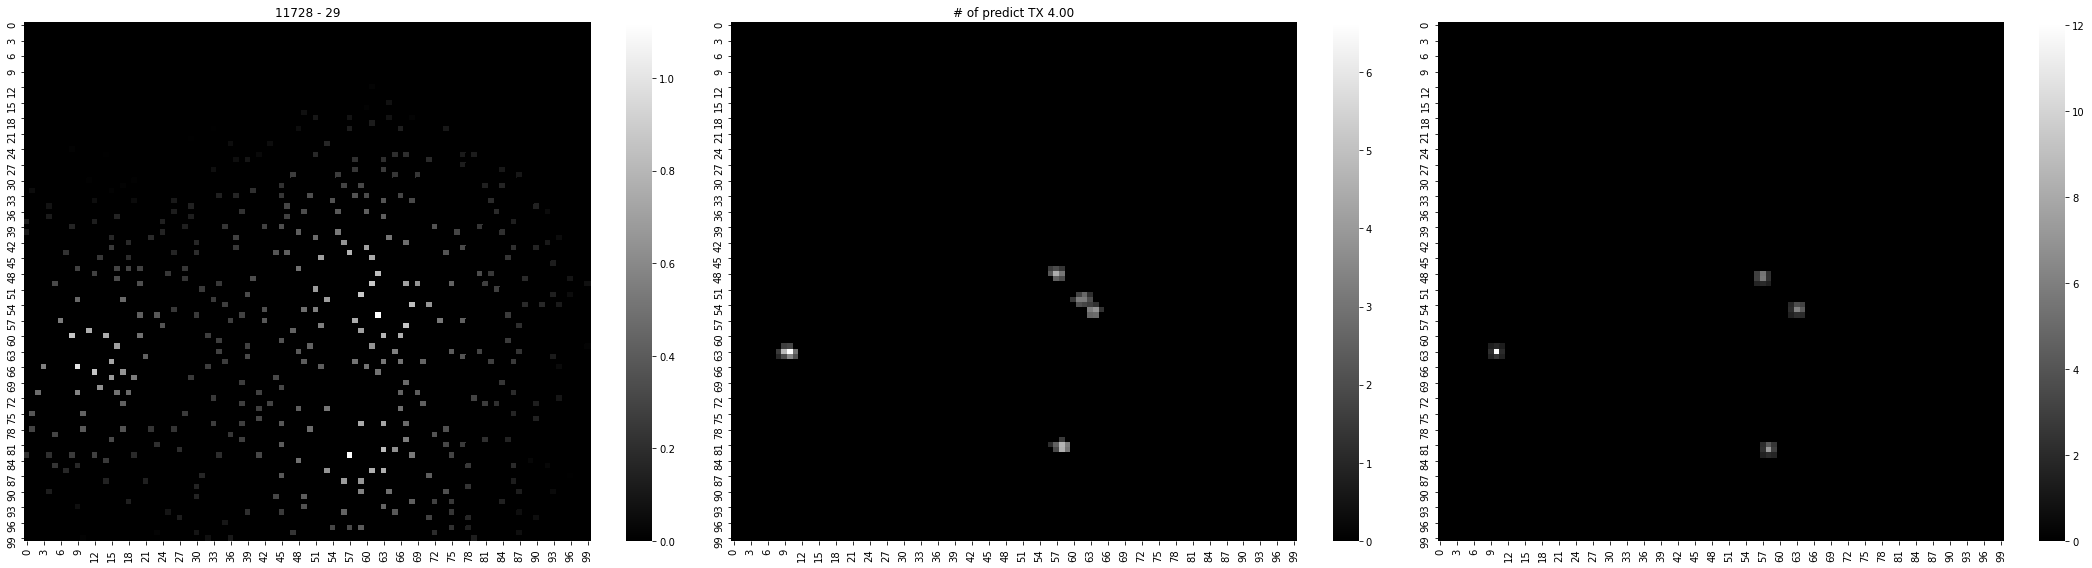

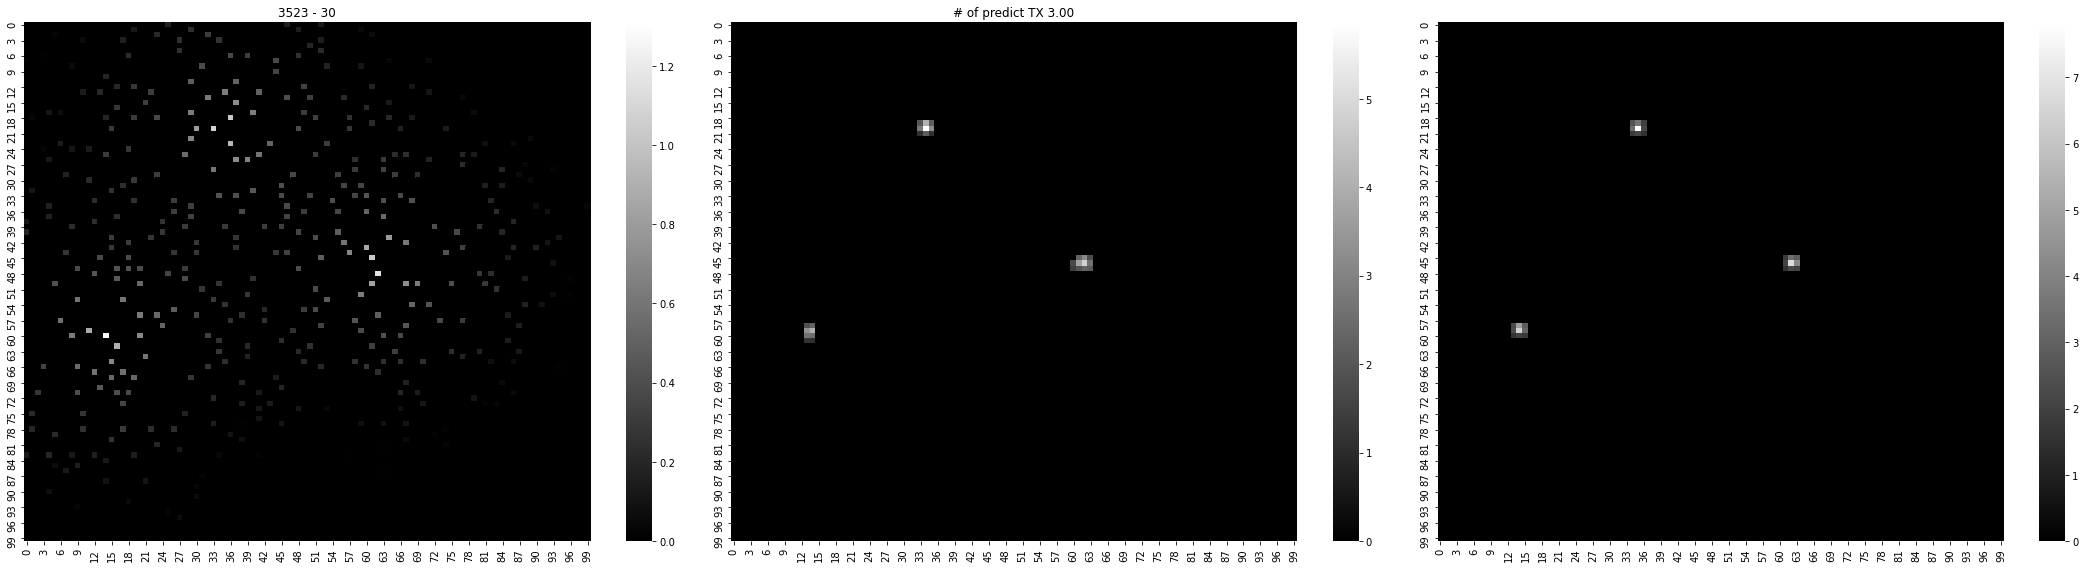

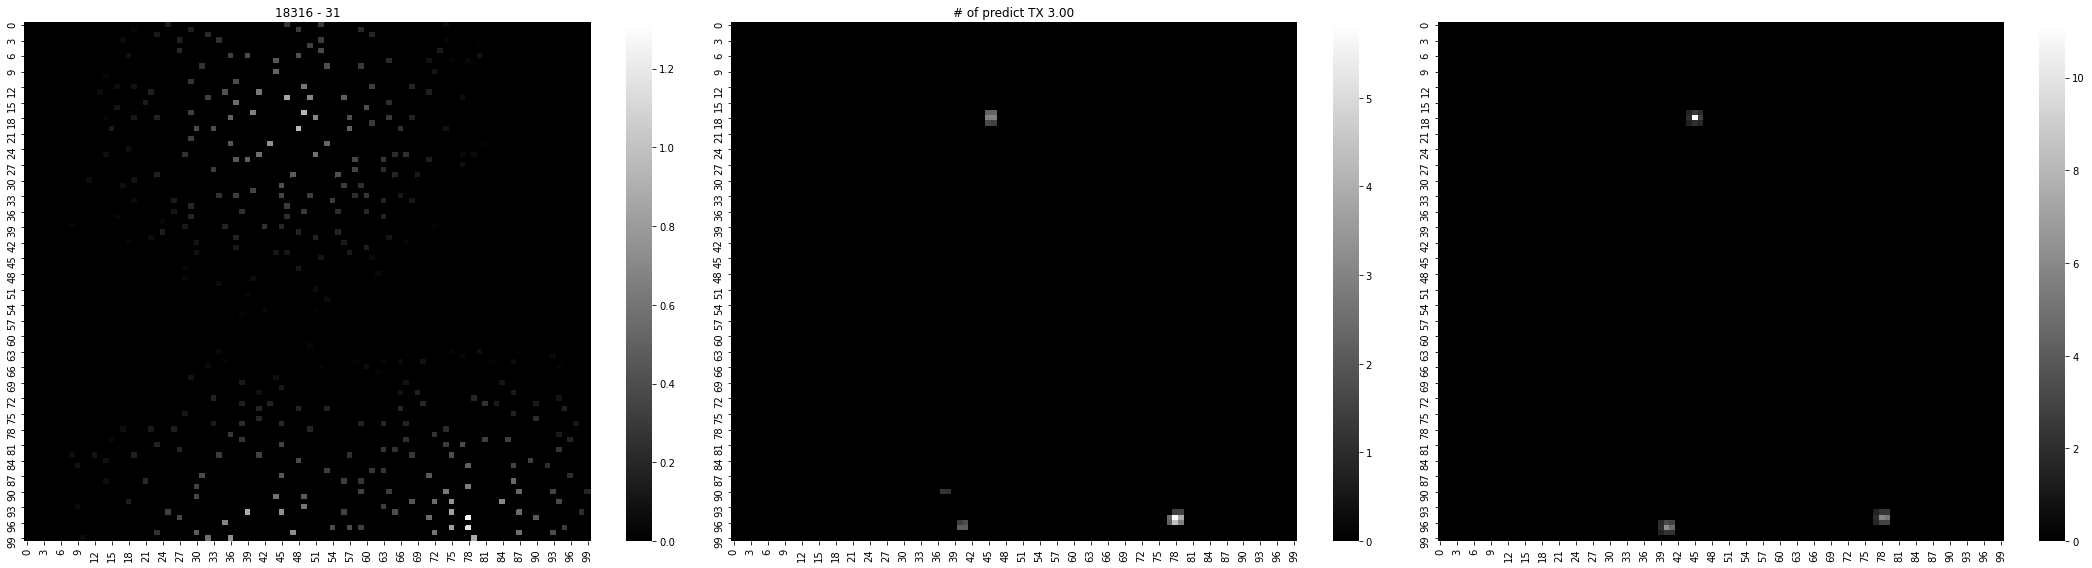

In [19]:
# visualize the batch

for i in range(len(pred_matrix)):
    myplot(X[i], pred_matrix[i], pred_ntx[i], y[i], indx[i], i)
    print(i, end=' ')

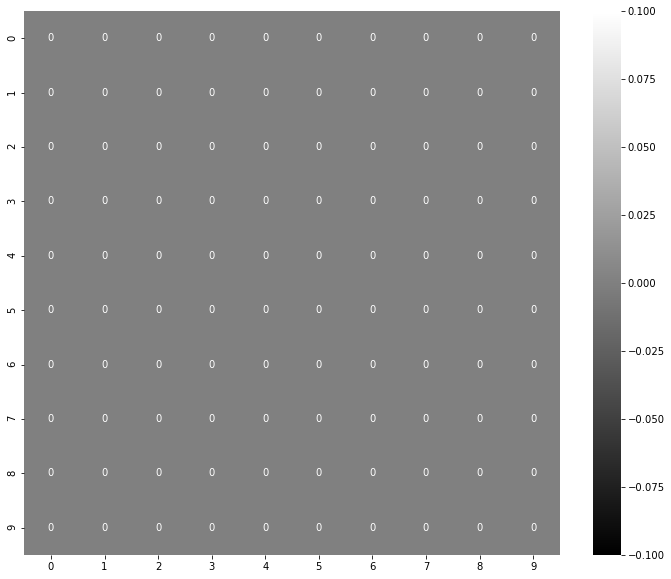

In [20]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(pred_matrix[i, 0][:10,:10], cmap='gray', annot=True)

# Mics

<class 'numpy.ndarray'> (100, 100) <class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100) <class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100) <class 'numpy.ndarray'> (100, 100)
<class 'numpy.ndarray'> (100, 100) <class 'numpy.ndarray'> (100, 100)


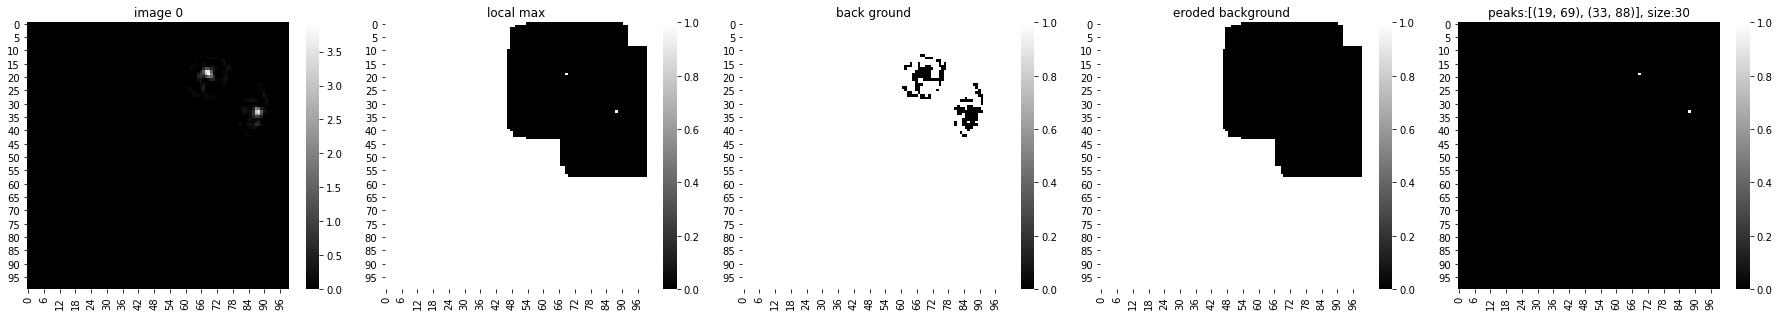

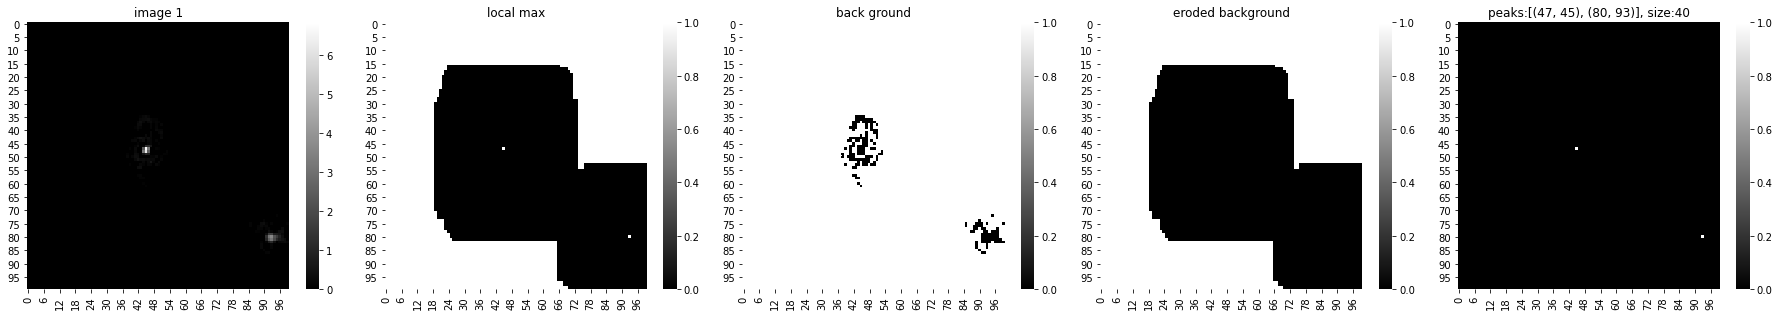

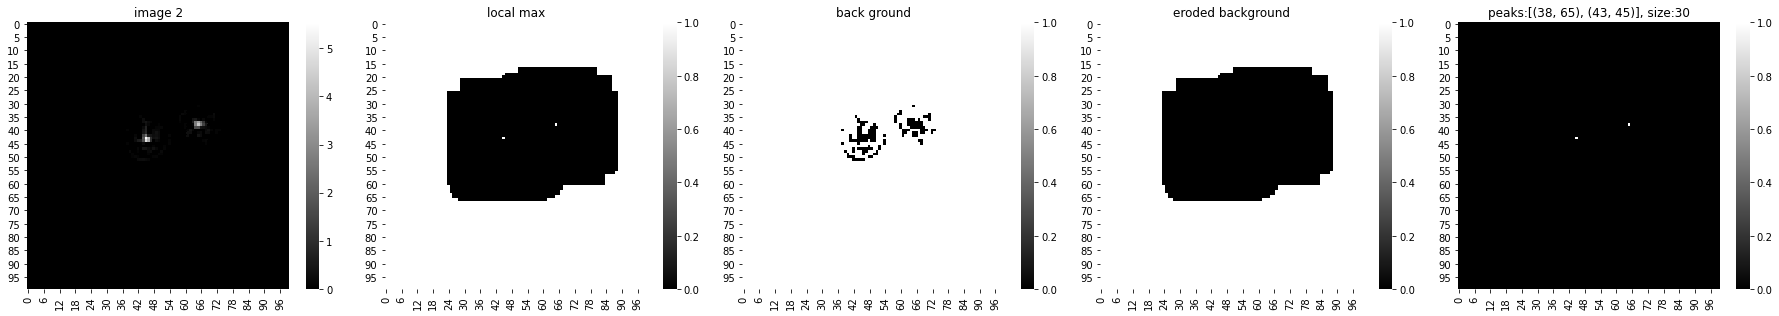

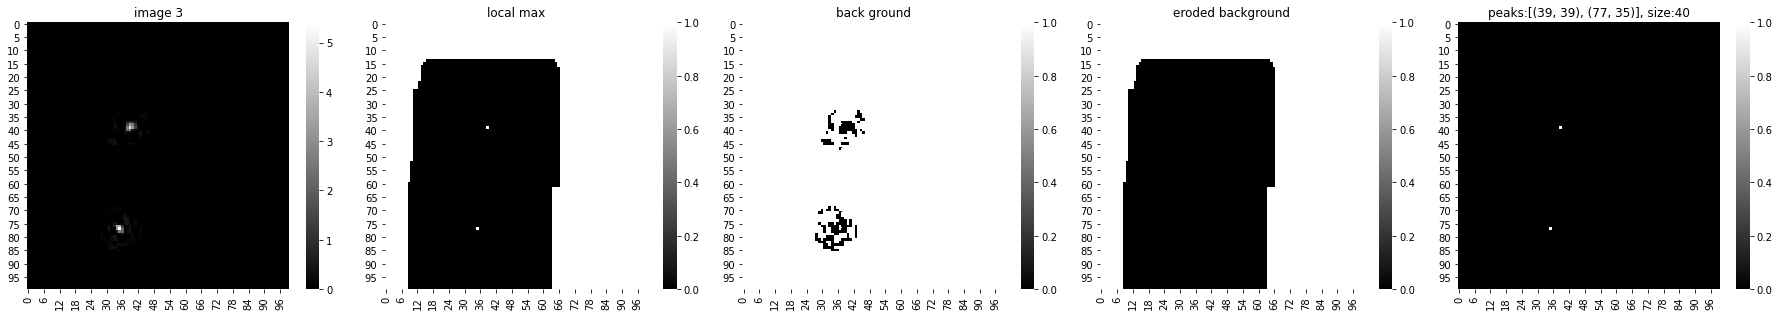

In [25]:
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion

for i in range(4):
    image = pred_matrix[i][0]
    threshold = 0.05
    peaks, size = Utility.detect_peak(image, 2)

    threshold_mask = image < threshold
    image[threshold_mask] = 0

    neighborhood = np.array([[True for _ in range(size)] for _ in range((size))])

    #apply the local maximum filter; all pixel of maximal value 
    #in their neighborhood are set to 1
    local_max = maximum_filter(image, footprint=neighborhood)==image
    #local_max is a mask that contains the peaks we are 
    #looking for, but also the background.
    #In order to isolate the peaks we must remove the background from the mask.
    #we create the mask of the background
    background = (image < 0.05)
    #a little technicality: we must erode the background in order to 
    #successfully subtract it form local_max, otherwise a line will 
    #appear along the background border (artifact of the local maximum filter)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)
    #we obtain the final mask, containing only peaks, 
    #by removing the background from the local_max mask (xor operation)
    print(type(local_max), local_max.shape, type(eroded_background), eroded_background.shape)
    detected_peaks = local_max ^ eroded_background

    fig, axes = plt.subplots(1, 5, figsize=(25, 4.5))
    sns.heatmap(image, cmap='gray', annot=False, ax = axes[0])
    sns.heatmap(local_max, cmap='gray', annot=False, ax = axes[1])
    sns.heatmap(background, cmap='gray', annot=False, ax = axes[2])
    sns.heatmap(eroded_background, cmap='gray', annot=False, ax = axes[3])
    sns.heatmap(detected_peaks, cmap='gray', annot=False, ax = axes[4])
    axes[0].set_title('image {}'.format(i))
    axes[1].set_title('local max')
    axes[2].set_title('back ground')
    axes[3].set_title('eroded background')
    axes[4].set_title('peaks:{}, size:{}'.format(str(peaks), size))
    fig.tight_layout()

In [26]:
indx = np.where(detected_peaks == True)

In [29]:
a = tensor([[1,2]])
b = tensor([[1, 2], [3, 4]])

## Loss function

In [99]:
# my implementation of cross entropy loss

def mysoftmax(X):
    '''
    Args:
        X -- np.ndarray, n=2
    Return:
        np.ndarray, n=2
    '''
    X = np.exp(X)
    summ = np.sum(X, axis=1)
    for i in range(len(X)):
        X[i] /= summ[i]
    return X


def mylogsoftmax(X):
    '''
    Args:
        array -- np.ndarray, n=2
    Return:
        np.ndarray, n=2
    '''
    X = mysoftmax(X)
    return np.log(X)


def mynllloss(X, y):
    '''
    Args:
        X -- np.ndarray, n=2
        y -- np.ndarray, n=1
    Return:
        float
    '''
    weight = np.ones(len(y))
    L = [0] * len(X)
    denominator = 0
    for i in range(len(X)):
        L[i] = -weight[y[i]] * X[i][y[i]]
        denominator += weight[y[i]]
    summ = 0
    for i in range(len(X)):
        summ += L[i] / denominator
    return summ


pred_ntx2 = pred_ntx.data.cpu().numpy()
y_num2 = y_num.data.cpu().numpy()

softmax     = nn.Softmax(dim=1)
log_softmax = nn.LogSoftmax(dim=1)
nllloss     = nn.NLLLoss()

loss = cross_entro_loss(pred_ntx, y_num - 1)
print(loss.item())

loss = nllloss(log_softmax(pred_ntx), y_num - 1)
print(loss.item())

loss = mynllloss(mylogsoftmax(pred_ntx2), y_num2 - 1)
print(loss)

1.6348114013671875
1.6348114013671875
1.634811419993639


In [153]:
# my implementation of mean square error loss

def mymseloss(pred, y):
    '''
    Args:
        pred -- np.ndarray, n=2
        y    -- np.ndarray, n=2
    Return:
        float
    '''
    n = len(pred) * len(pred[0])
    summ = np.sum((pred - y)**2)
    return summ / n

In [152]:
# my implementation of binary cross entropy loss

def mysigmoid(X):
    '''
    Args:
        X -- np.ndarray, in float32
    Return:
        np.ndarray
    '''
    X = np.where(X < -88, -88, X)    # the maximum value of float32 is 3x10^38 (around e^88)
    return 1 / (1 + np.exp(-X))


def mybceloss(output, target):
    '''binary cross entropy loss
    Args:
        output -- np.ndarray -- (batchsize, *)
        target -- np.ndarray -- (batchsize, *)
    '''
    output = np.where(output < np.exp(-100), np.exp(-100), output)  # BCELoss clamps its log function outputs to be greater than or equal to -100
    L = [0] * len(output)
    for i in range(len(output)):
        L[i] = target[i] * np.log(output[i]) + (1 - target[i]) * np.log(1 - output[i])
        L[i] = -np.mean(L[i])
    return np.mean(L)


bce_loss = nn.BCEWithLogitsLoss()
loss = bce_loss(pred_matrix2, y2)
print(loss.item())

pred_matrix2_copy = pred_matrix2.data.cpu().numpy()
y2_copy = y2.data.cpu().numpy()
loss = mybceloss(mysigmoid(pred_matrix2_copy), y2_copy)
print(loss)

0.0004791822284460068
0.00047918136
